In [1]:
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from analysis_count_0g import read_n, classify_imgs2
import matplotlib.pyplot as plt
import operator
%matplotlib inline

['/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '-f', 'true', 'true', 'true', 'true', 'true', 'model_runs/-f/count_log.csv', 'model_runs/-f/countmodel_0.ckpt', 'model_runs/-f/countmodel_', 'true', 'false', 'false', 'true']
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` 

In [16]:
model_name = "3task_0216"
num_runs = 1
test_trials = 500
iter_list = [0,1000,2000,3000,4000,5000,6000]#np.arange(0,31000,1000)#[3200, 4800, 6400, 9600, 12800]#, 200, 300, 400, 600, 800, 1200]#, 1600, 2400, 3200, 4800, 6400, 9600, 12800, 19200, 25600, 38400, 51200, 76800, 102400]#, 153600, 204800, 307200, 409600, 614400, 819200, 1000000]
            #[0, 400, 800, 1600, 3200, 6400, 12800, 25600]#, 51200, 76800, 102400]#, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 2000000, 3000000, 4000000]
             #[0, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 600000]
#iter_list = np.arange(0,11100000,100000)
glimpse_list = np.arange(0,10,1)
max_blobs = 9
min_blobs = 1

num_iters = len(iter_list)
num_glimpses = len(glimpse_list)
blob_list = np.arange(0,10,1)
output_size = max_blobs - min_blobs + 2 # 10
data_directory = "data/" + model_name + "/"
m = 0.5
num_imgs = test_trials*(output_size-1)

confidence_all_runs = np.zeros([num_runs, num_iters, output_size-1, num_glimpses, 1, output_size]) 
choice_all_runs = np.zeros([num_runs, num_iters, output_size-1, num_glimpses, 1, output_size])
countword_all_runs = np.zeros([num_runs, num_iters, num_imgs, output_size+1])
pointblob_all_runs = np.zeros([num_runs, num_iters, num_imgs, output_size+1])
point_target_all_runs = np.zeros([num_runs, num_iters, num_imgs, num_glimpses])
blob_point_all_runs = np.zeros([num_runs, num_iters, num_imgs, output_size+1])
class_all_runs = np.zeros([num_runs, num_iters, num_imgs])
point_results_all_runs = np.zeros([num_runs, num_iters, num_imgs, num_glimpses])

In [17]:
def fill_matrix(path, iteration):
    """Fill the confidence and choice matrices for one run at one iteration."""
    
    data = None
    num_imgs = test_trials*(output_size-1) # batch_size
    imgs_data = classify_imgs2(iteration, True, num_imgs, path=path) # new_imgs = True
        
    confidence_one_run = np.zeros([output_size-1, num_glimpses, 1, output_size])
    choice_one_run = np.zeros([output_size-1, num_glimpses, 1, output_size])
    countword_one_run = np.zeros([num_imgs, output_size+1])
    pointblob_one_run = np.zeros([num_imgs, output_size+1])
    point_target_one_run = np.zeros([num_imgs, num_glimpses])
    blob_point_one_run = np.zeros([num_imgs, output_size+1])
    class_one_run = np.zeros(num_imgs)
    point_results_one_run = np.zeros([num_imgs, num_glimpses]) # 1 to 9
    
    for nb in range(output_size-1):
        confidence_hist = np.zeros([num_glimpses, 1, output_size])
        choice_hist = np.zeros([num_glimpses, 1, output_size])
        num_imgs_with_num_blobs = 0.00001
        
        for idx, data in enumerate(imgs_data):
            if data["label"][nb] == 1: # data is for an image with nb+1 blobs
                num_imgs_with_num_blobs += 1
                countword_one_run[idx][0]=nb+1
                pointblob_one_run[idx][0]=nb+1
                
                for g, glimpse in enumerate(glimpse_list):
                    # Histogram of softmaxes
                    confidence_hist[glimpse] += data["classifications"][glimpse]
                    # Histogram of choices
                    choice = np.argmax(data["classifications"][glimpse])
                    choice_list = [0] * (output_size)
                    choice_list[choice] = 1
                    choice_hist[glimpse] += choice_list
                    # Count Word
                    countword_one_run[idx][glimpse+1]=choice
                    # Point Blob
                    pointblob_one_run[idx][glimpse+1]=int(data["corrects"][glimpse])
                
                pointblob_one_run[idx][nb+2]=nb+1
                point_target_one_run[idx] = data["corrects"]
                point_target_one_run[idx][nb+1] = nb+1
                class_one_run[idx] = data["class"]+1
                
        confidence_hist = confidence_hist / num_imgs_with_num_blobs
        confidence_one_run[nb] = confidence_hist.tolist()
        choice_hist = choice_hist / num_imgs_with_num_blobs
        choice_one_run[nb] = choice_hist.tolist()
        
    for idx, data in enumerate(imgs_data):
        for g in range(1,num_glimpses+1):
            blob_point_one_run[idx][g] = int(data["blob_point"][g-1])
        blob_point_one_run[idx][0] = data["class"]+1
        #gg=0
        #while (gg<int(data["class"]+2)):
        #for gg in range(int(data["class"]+2)):
            #if point_target_one_run[idx][gg] == blob_point_one_run[idx][gg]:
                #gg+=1
         
        #if gg==data["class"]+1:
               #point_results_one_run[int(data["class"])-1]+=1            
    
    return confidence_one_run, choice_one_run, countword_one_run, point_target_one_run, blob_point_one_run, pointblob_one_run, point_results_one_run, class_one_run

In [18]:
for run in range(num_runs):
    path = 'model_runs/' + model_name + '_run_' + str(run + 1) 
#     path = 'model_runs/DRAM_test_square'
    for i, iteration in enumerate(iter_list):
        confidence_all_runs[run, i], choice_all_runs[run, i], countword_all_runs[run, i], point_target_all_runs[run, i], blob_point_all_runs[run, i], pointblob_all_runs[run, i],point_results_all_runs[run, i], class_all_runs[run, i] = fill_matrix(path, iteration)

INFO:tensorflow:Restoring parameters from model_runs/3task_0216_run_1/countmodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_0216_run_1/countmodel_1000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_0216_run_1/countmodel_2000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_0216_run_1/countmodel_3000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_0216_run_1/countmodel_4000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_0216_run_1/countmodel_5000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_0216_run_1/countmodel_6000.ckpt


In [17]:
# Count
sort_cws = np.zeros([num_runs, num_iters, num_imgs, output_size+1])

for i in range(num_runs):
    for j in range(num_iters):
        sort_cws[i][j]=sorted(countword_all_runs[i, j, :], key = operator.itemgetter(0,1,2,3,4,5,6,7,8,9,10), reverse = False) # sorted count words

stop_idx=np.ones([num_runs, num_iters, num_imgs])*(-1)

for i in range(num_runs):
    for j in range(num_iters):
        for k in range (num_imgs):
            for p in range (1, output_size+1):
                if countword_all_runs[i][j][k][p]==0: # record end position
                    stop_idx[i][j][k]=p
                    break # stop at the first zero 
            
count_results=np.zeros([num_runs, num_iters, 9, 11])  
count_class=np.ones([num_runs, num_iters, num_imgs])*(-1) #-1: not-well-formed answer (string error)

for i in range(num_runs):
    for j in range(num_iters):
        for k in range(num_imgs):
            # not-well-formed
            if stop_idx[i][j][k]==-1: # no "I'm done!" signal
                count_results[i][j][int(countword_all_runs[i][j][k][0])-1][10]+=1
            # all zeros
            elif stop_idx[i][j][k]==1:
                count_results[i][j][int(countword_all_runs[i][j][k][0])-1][0]+=1   
                count_class[i][j][k]=0
            else:
                for p in range(1,int(stop_idx[i][j][k])): 
                    if p!=countword_all_runs[i][j][k][p]:
                        count_results[i][j][int(countword_all_runs[i][j][k][0])-1][10]+=1
                        break 
                    elif p==stop_idx[i][j][k]-1:
                        idx=int(max(countword_all_runs[i][j][k][1:int(stop_idx[i][j][k])+1]))
                        count_results[i][j][int(countword_all_runs[i][j][k][0])-1][idx]+=1
                        count_class[i][j][k]=stop_idx[i][j][k]-1
                        
# How high the network can count? (0.67)
high_cot = np.zeros([num_runs, num_iters]) 
for i in range(num_runs):
    for j in range(num_iters):
        k=0
        while (k<output_size-1): 
            if count_results[i][j][k][k+1]/test_trials>=0.67:
                high_cot[i][j]+=1
                k+=1
            else:
                k=output_size

# Count Accuracy
count_accuracy = np.zeros([num_runs, output_size-1, num_iters])
for i in range(num_runs):
    for j in range(output_size-1):
        for k in range(num_iters):
            count_accuracy[i][j][k]=count_results[i][k][j][j+1]/test_trials
            
# How high the network can count? (0.90)
high_cot_2 = np.zeros([num_runs, num_iters]) 
for i in range(num_runs):
    for j in range(num_iters):
        k=0
        while (k<output_size-1): 
            if count_results[i][j][k][k+1]/test_trials>=0.90:
                high_cot_2[i][j]+=1
                k+=1
            else:
                k=output_size

# Count Accuracy
count_accuracy_2 = np.zeros([num_runs, output_size-1, num_iters])
for i in range(num_runs):
    for j in range(output_size-1):
        for k in range(num_iters):
            count_accuracy_2[i][j][k]=count_results[i][k][j][j+1]/test_trials

In [25]:
a=[[0,1,2,3],[1,2,3,4],[0,2,3,4],[1,4,2,3]]
b=sorted(a, key = operator.itemgetter(0,1,2,3), reverse = False) # sorted count words

b

[[0, 1, 2, 3], [0, 2, 3, 4], [1, 2, 3, 4], [1, 4, 2, 3]]

In [18]:
# Point
sort_pws = np.zeros([num_runs, num_iters, num_imgs, output_size+1])

for i in range(num_runs):
    for j in range(num_iters):
        sort_pws[i][j]=sorted(blob_point_all_runs[i, j, :], key = operator.itemgetter(-1,1,2,3,4,5,6,7,8,9,10), reverse = False) # sorted count words

pstop_idx=np.ones([num_runs, num_iters, num_imgs])*(-1)

for i in range(num_runs):
    for j in range(num_iters):
        for k in range (num_imgs):
            for p in range (2, output_size+1):
                if sort_pws[i][j][k][p]!=-1 and sort_pws[i][j][k][p]==sort_pws[i][j][k][p-1]: # record end position
                    pstop_idx[i][j][k]=p
                    break # stop at the first repeated word

point_results=np.zeros([num_runs, num_iters, 9, 10])  

for i in range(num_runs):
    for j in range(num_iters):
        for k in range(num_imgs):
            # not-well-formed
            if pstop_idx[i][j][k]==-1: # no "I'm done!" signal
                point_results[i][j][k//test_trials][9]+=1         
            else:
                for p in range(1,int(pstop_idx[i][j][k])): 
                    if p!=sort_pws[i][j][k][p]:
                        point_results[i][j][k//test_trials][9]+=1
                        break 
                    elif p==pstop_idx[i][j][k]-1:
                        idx=int(max(sort_pws[i][j][k][1:int(pstop_idx[i][j][k])+1]))
                        point_results[i][j][k//test_trials][idx-1]+=1
                        
# Point Accuracy
point_accuracy = np.zeros([num_runs, output_size-1, num_iters])
for i in range(num_runs):
    for j in range(output_size-1):
        for k in range(num_iters):
            point_accuracy[i][j][k]=point_results[i][k][j][j]/test_trials

In [7]:
# Coding Types of Errors
error = np.zeros([num_runs, num_iters, 8])
# error[0]: correct; error[1]: string error; error[2]: done error; error[3]: skip; error[4]: stop short; error[5]: double count; error[6]:continue; error[7]: Others
for i in range(num_runs):
    for j in range(num_iters):
        for k in range(num_imgs):
            cot_idx=int(count_class[i][j][k]) # the last count word produced by NN
            if cot_idx==countword_all_runs[i][j][k][0]: # correct
                error[i][j][0]+=1         
            elif cot_idx ==-1: # string error (count words in an incorrect order)
                error[i][j][1]+=1
            elif cot_idx ==0: # done error (say "I'm done!" at the very beginning)
                error[i][j][2]+=1
            elif cot_idx<countword_all_runs[i][j][k][0]: # count too far
                if blob_point_all_runs[i][j][k][cot_idx]==blob_point_all_runs[i][j][k][cot_idx+1]:
                    if blob_point_all_runs[i][j][k][cot_idx]>cot_idx:
                        for p in range(1, cot_idx):
                            if blob_point_all_runs[i][j][k][p]>=blob_point_all_runs[i][j][k][p+1]:
                                error[i][j][7]+=1 # others 
                                break
                            elif p==cot_idx-1:
                                error[i][j][3]+=1 # skip error
                    elif blob_point_all_runs[i][j][k][cot_idx]==cot_idx:
                        for p in range(1, cot_idx):
                            if blob_point_all_runs[i][j][k][p]+1!=blob_point_all_runs[i][j][k][p+1]:
                                error[i][j][7]+=1 # others
                                break
                            elif p==cot_idx-1:
                                error[i][j][4]+=1 # stop short
                else:
                    error[i][j][7]+=1 # others       
            else: # count too short
                if blob_point_all_runs[i][j][k][cot_idx]==blob_point_all_runs[i][j][k][cot_idx+1]:
                    if blob_point_all_runs[i][j][k][cot_idx]<cot_idx:
                        for p in range(1, cot_idx):
                            if blob_point_all_runs[i][j][k][p]>blob_point_all_runs[i][j][k][p+1]:
                                error[i][j][7]+=1 # others
                                break
                            elif blob_point_all_runs[i][j][k][p]<blob_point_all_runs[i][j][k][p+1]-1:
                                error[i][j][7]+=1 # others
                                break
                            elif p==cot_idx-1:
                                error[i][j][5]+=1 # double count      
                else:
                    for q in range(1, int(countword_all_runs[i][j][k][0]+1)):
                        if blob_point_all_runs[i][j][k][q]!=pointblob_all_runs[i][j][k][q]:
                            error[i][j][7]+=1 # others       
                        elif q==countword_all_runs[i][j][k][0]:
                            error[i][j][6]+=1 # continue

In [8]:
np.save(data_directory + "count_results_hist", count_results)
np.save(data_directory + "count_class_hist", count_class)
np.save(data_directory + "high_cot_hist", high_cot)
np.save(data_directory + "high_cot_2_hist", high_cot_2)
np.save(data_directory + "count_accuracy_hist", count_accuracy)
np.save(data_directory + "count_accuracy_2_hist", count_accuracy)
np.save(data_directory + "point_results_hist", point_results)
np.save(data_directory + "point_accuracy_hist", point_accuracy)
np.save(data_directory + "error_hist", error)

In [9]:
#point_target_all_runs[0,0,0]
#pointblob_all_runs[0,20,5]

In [10]:
#blob_point_all_runs[0,20,5]

In [11]:
#countword_all_runs[0,20,18]

# Count Analysis

In [12]:
# Count
sort_cws = np.zeros([num_runs, num_iters, num_imgs, output_size+1])

for i in range(num_runs):
    for j in range(num_iters):
        sort_cws[i][j]=sorted(countword_all_runs[i, j, :], key = operator.itemgetter(0,1,2,3,4,5,6,7,8,9,10), reverse = False) # sorted count words

stop_idx=np.ones([num_runs, num_iters, num_imgs])*(-1)

for i in range(num_runs):
    for j in range(num_iters):
        for k in range (num_imgs):
            for p in range (1, output_size+1):
                if countword_all_runs[i][j][k][p]==0: # record end position
                    stop_idx[i][j][k]=p
                    break # stop at the first zero 
            
count_results=np.zeros([num_runs, num_iters, 9, 11])  
count_class=np.ones([num_runs, num_iters, num_imgs])*(-1) #-1: not-well-formed answer (string error)

for i in range(num_runs):
    for j in range(num_iters):
        for k in range(num_imgs):
            # not-well-formed
            if stop_idx[i][j][k]==-1: # no "I'm done!" signal
                count_results[i][j][int(countword_all_runs[i][j][k][0])-1][10]+=1
            # all zeros
            elif stop_idx[i][j][k]==1:
                count_results[i][j][int(countword_all_runs[i][j][k][0])-1][0]+=1   
                count_class[i][j][k]=0
            else:
                for p in range(1,int(stop_idx[i][j][k])): 
                    if p!=countword_all_runs[i][j][k][p]:
                        count_results[i][j][int(countword_all_runs[i][j][k][0])-1][10]+=1
                        break 
                    elif p==stop_idx[i][j][k]-1:
                        idx=int(max(countword_all_runs[i][j][k][1:int(stop_idx[i][j][k])+1]))
                        count_results[i][j][int(countword_all_runs[i][j][k][0])-1][idx]+=1
                        count_class[i][j][k]=stop_idx[i][j][k]-1

In [13]:
def plot_count_results(run, it):
    """Plot the count heatmap."""
    matrix = np.zeros([9,11])
    matrix = results[run, it]
    plot_title = "Count at Run %d after %d Iters" % (run + 1, iter_list[it])
    plot_count_heatmap(matrix, plot_title)

def plot_count_heatmap(matrix, plot_title):
    """Plot heatmap."""
    labels_1 = ["0","1","2","3","4","5","6","7","8","9","NWF"]
    labels_2 = ["1","2","3","4","5","6","7","8","9"]
    data = [go.Heatmap(
        z=matrix,
        colorscale="Jet",
    )]

    layout = go.Layout(
        title=plot_title,
        xaxis=dict(
            range=[0 - m, 11 + m],
            title="Count Results",
            #dtick=1,
            tickangle=0,
            ticktext=labels_1,
            tickvals=[i * 1 for i in range(len(labels_1))],
            tickcolor='#FFF'
        ),
        yaxis=dict(
            range=[0 - m, 8 + m],
            title="True Class",
            #dtick=1,
            ticktext=labels_2,
            tickvals=[i * 1 for i in range(len(labels_2))],
            tickcolor='#FFF'
        ),        
        width=500,
        height=500,
        plot_bgcolor="#000",
        paper_bgcolor="#000",
        font=dict(
            color="#FFF"
        ),
        titlefont=dict(
            color="#FFF"
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def plot_count_results(run, it):
    """Plot the count heatmap."""
    matrix = np.zeros([9,11])
    for g in range (num_runs):
        matrix = results[run, it]
        plot_title = "Count at Run %d after %d Iters" % (run + 1, iter_list[it])
    plot_count_heatmap(matrix, plot_title)

In [14]:
#for run in range(num_runs):
    #for it in range(num_iters):
        #plot_count_results(run,it)

In [15]:
import plotly
plotly.tools.set_credentials_file(username='mtfang0707', api_key='18LL0DZ6dDhgqxIQ3yPQ')
import plotly.plotly as py
import plotly.figure_factory as ff

#fig = ff.create_annotated_heatmap(results[0][4])
#py.iplot(fig)

In [16]:
def plot_count_results_wv(run, it):
    """Plot the count heatmap with values."""
    data = count_results[run, it]
    title = "Count at Run %d after %d Iters" % (run + 1, iter_list[it])
    xlabel= "Count Results"
    ylabel="True Class"
    plt.figure(figsize=(output_size+1, output_size-1))
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    c = plt.pcolor(data, edgecolors='k', linewidths=2, cmap='Reds', vmin=0, vmax=test_trials)
    xbars = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'NWF')
    x_pos=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]
    plt.xticks(x_pos, xbars, fontsize='10', horizontalalignment='center')
    ybars = ('1', '2', '3', '4', '5', '6', '7', '8', '9')
    y_pos=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]
    plt.yticks(y_pos, ybars, fontsize='10', horizontalalignment='center')
 
    def show_values(pc, fmt="%.0f", **kw):
        pc.update_scalarmappable()
        ax = pc.get_axes()
        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            color = (0.0, 0.0, 0.0) # value color
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

    show_values(c)
    plt.colorbar(c)

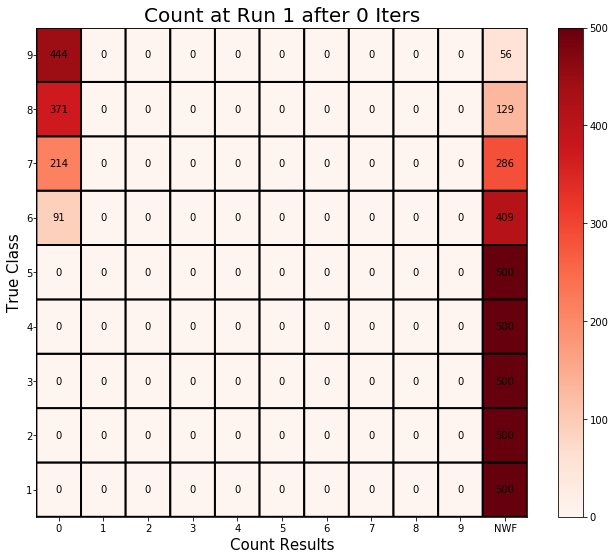

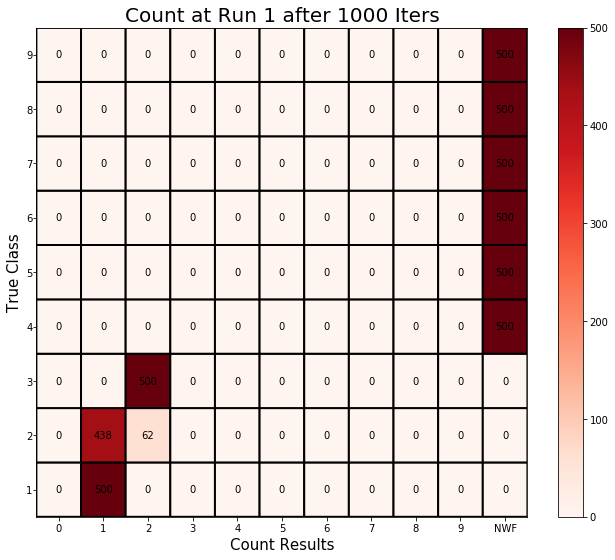

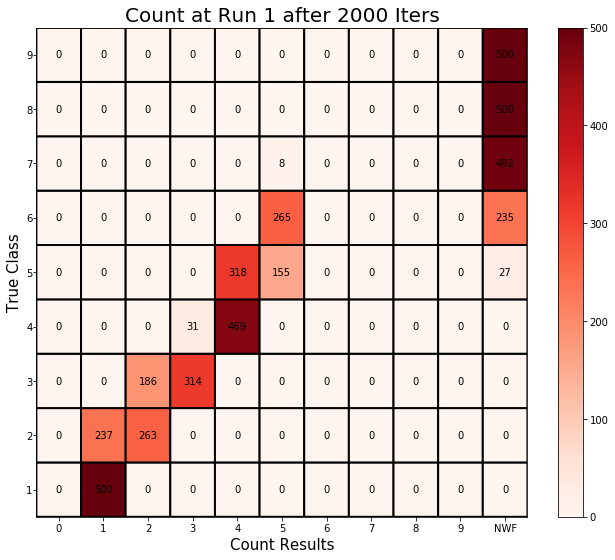

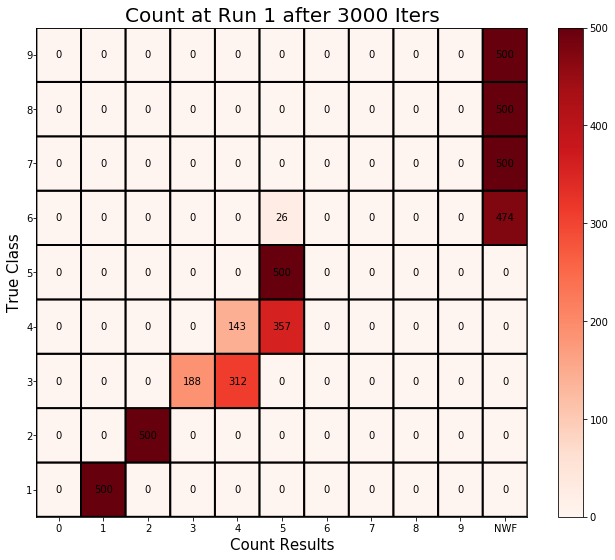

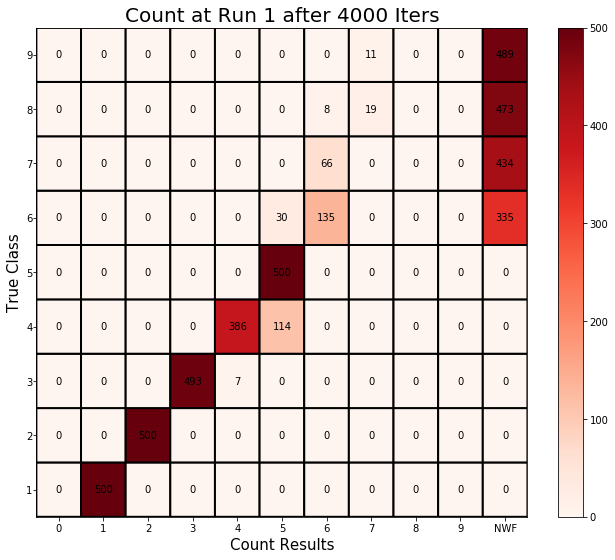

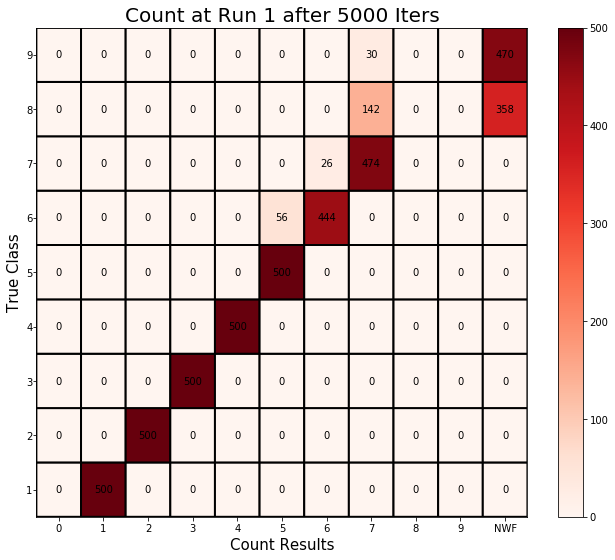

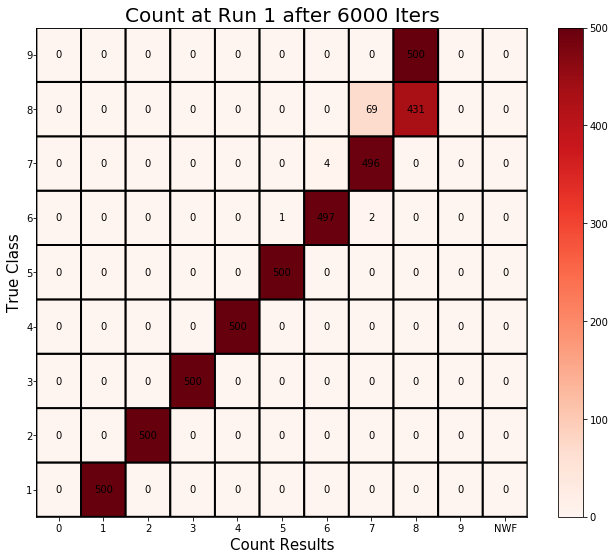

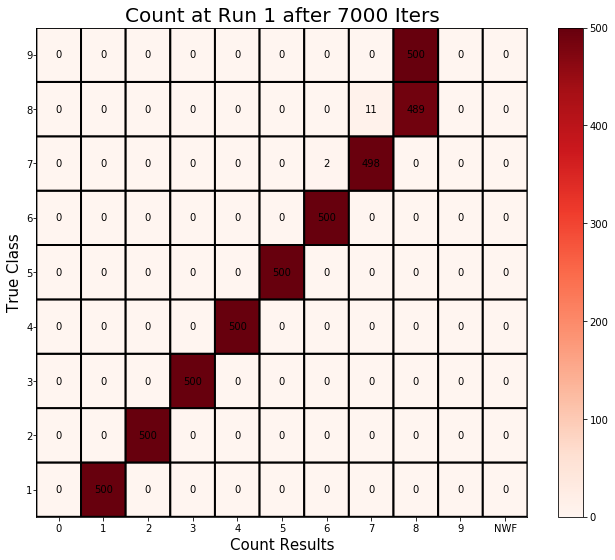

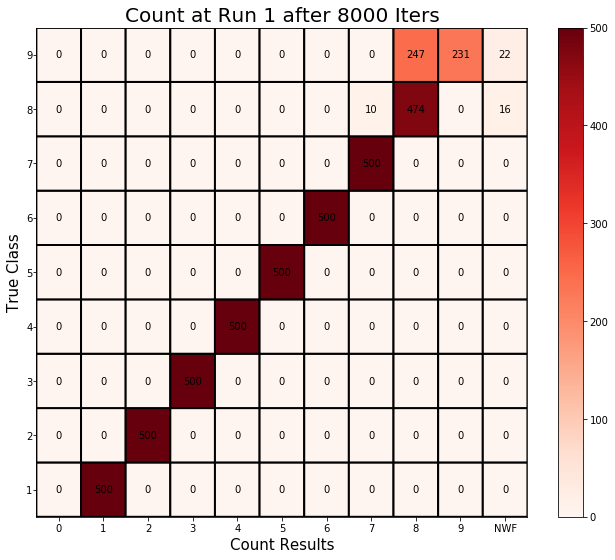

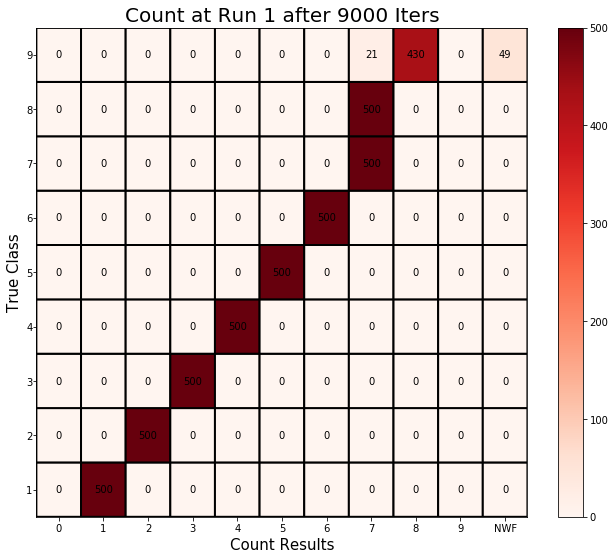

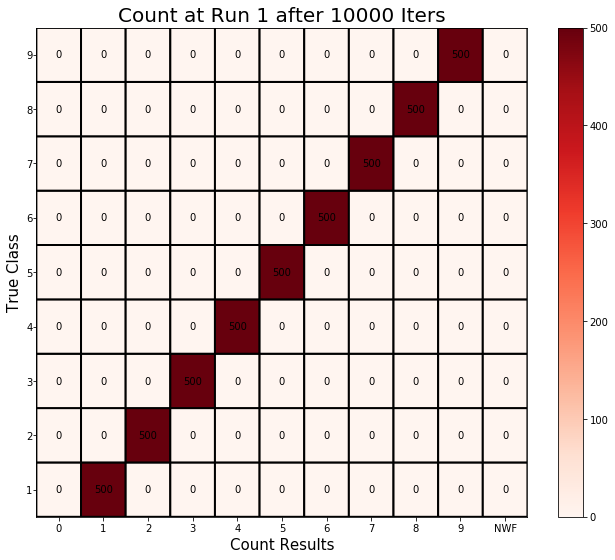

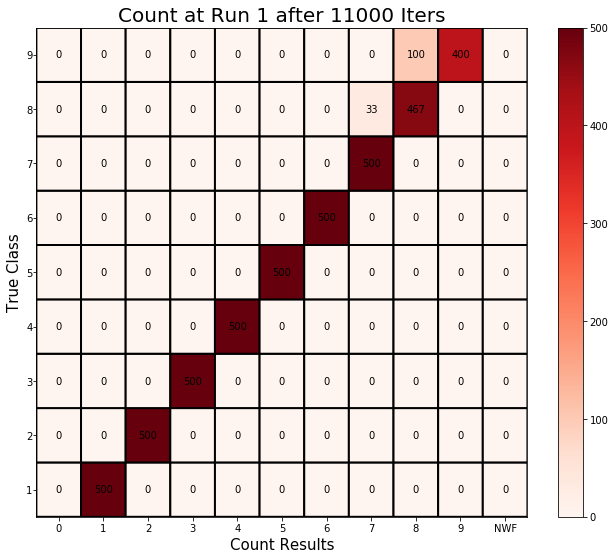

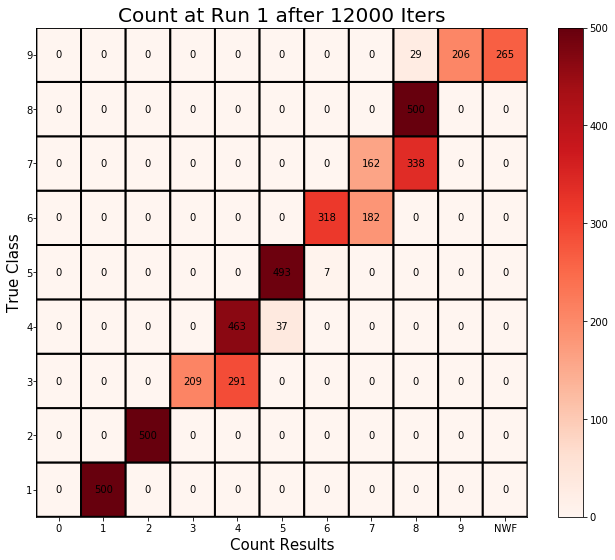

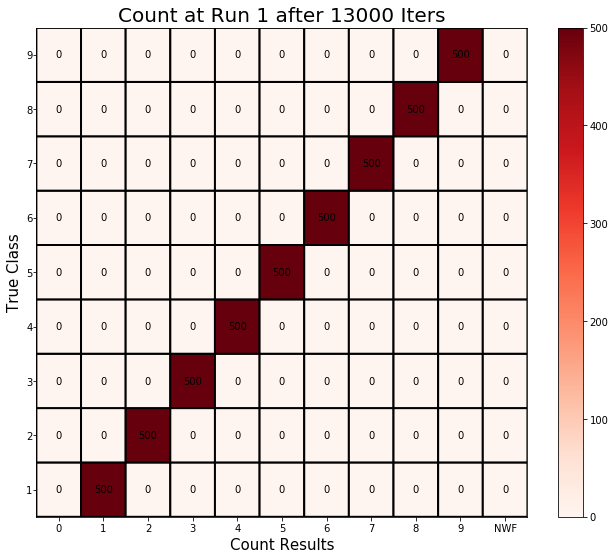

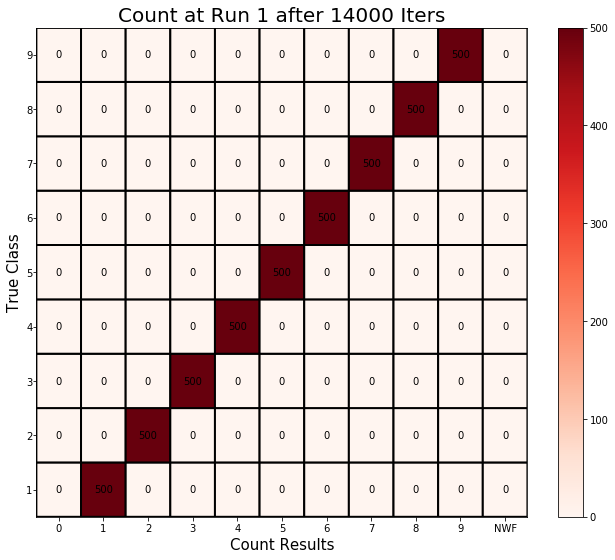

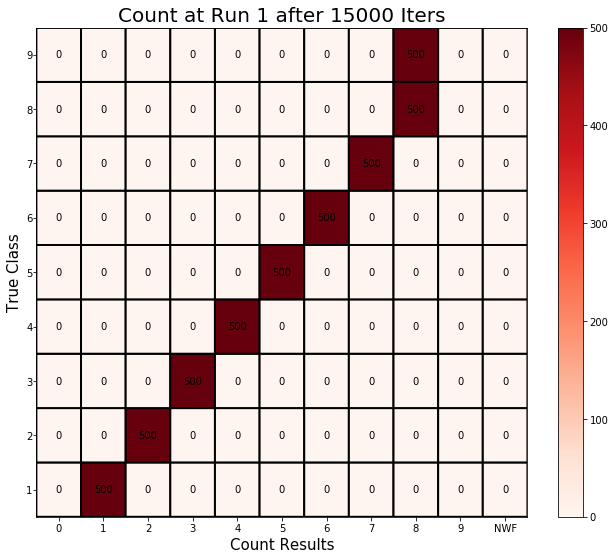

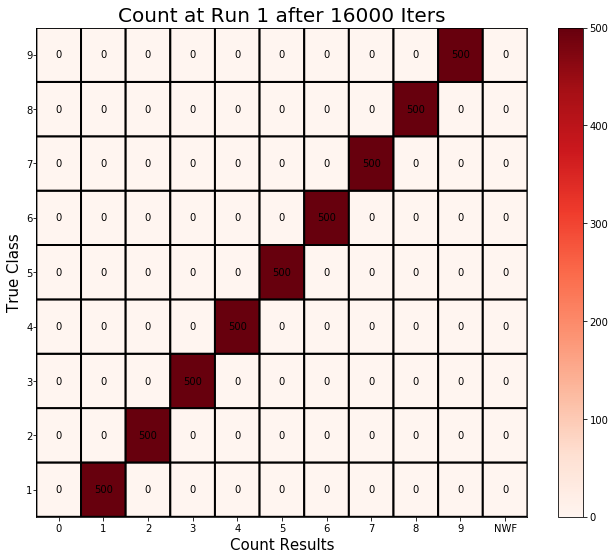

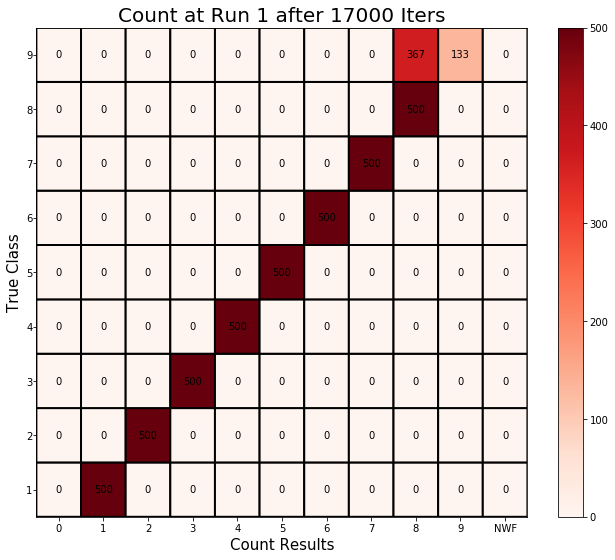

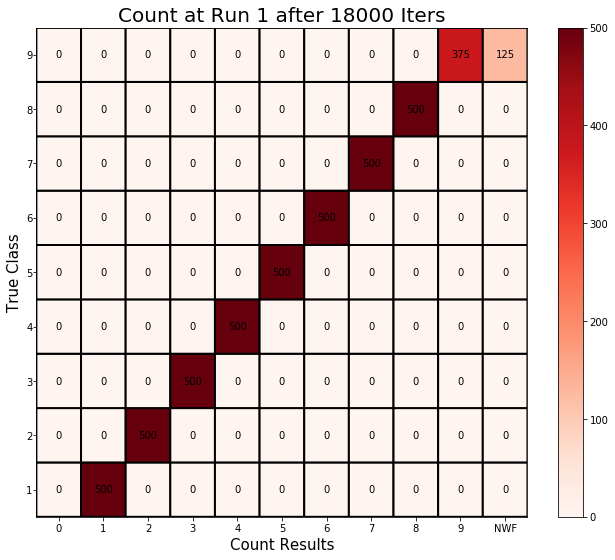

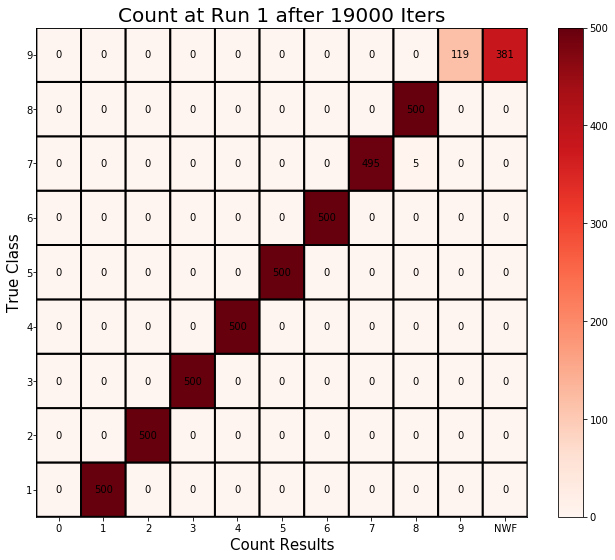

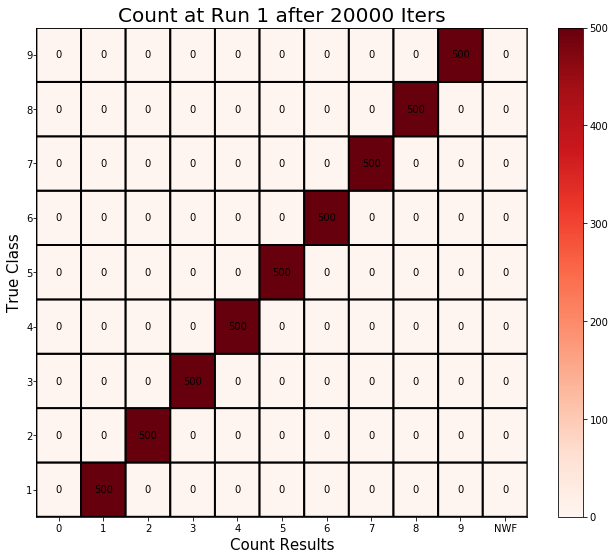

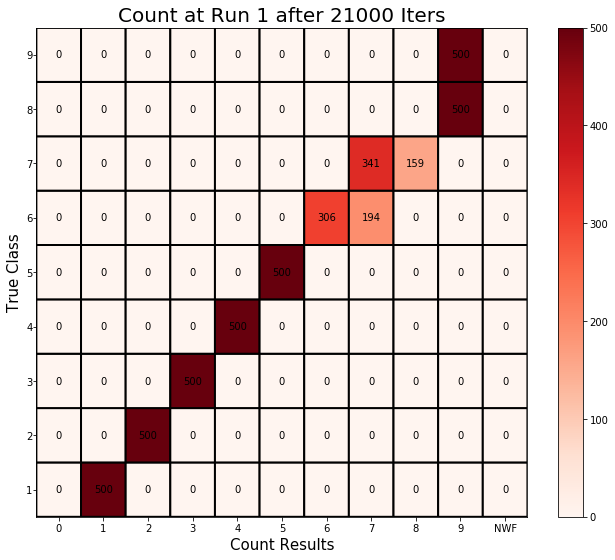

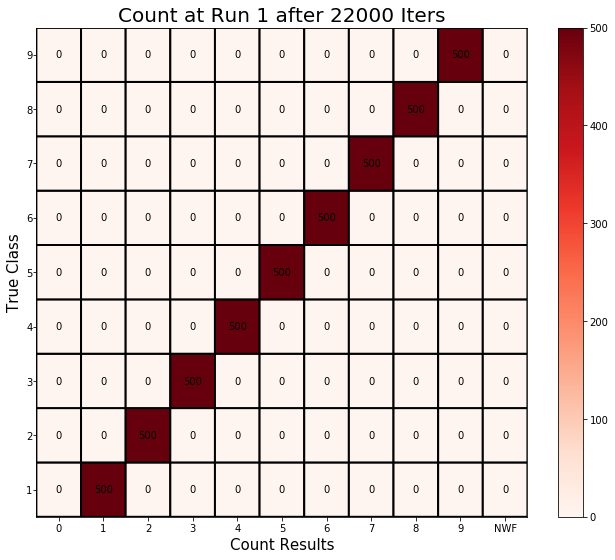

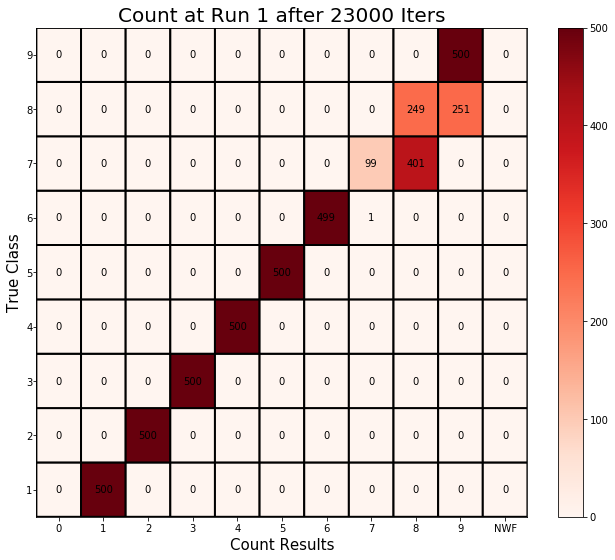

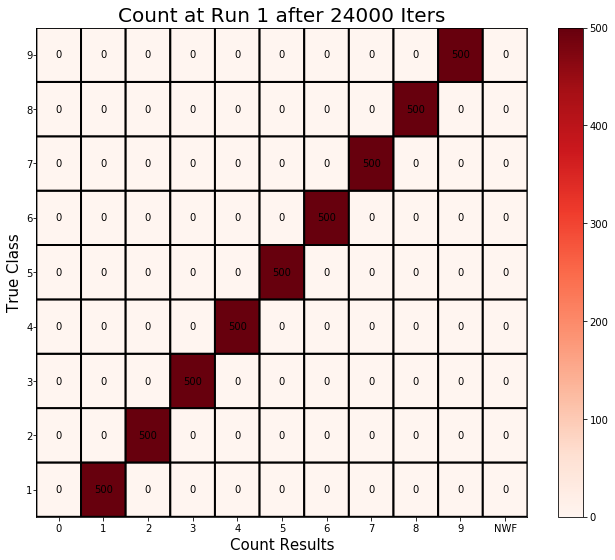

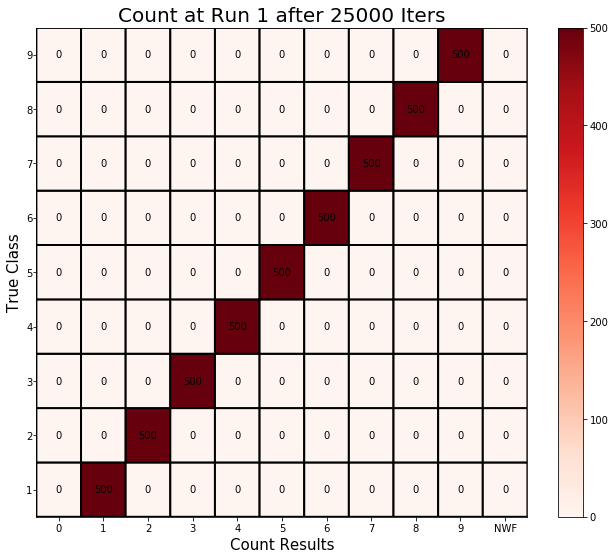

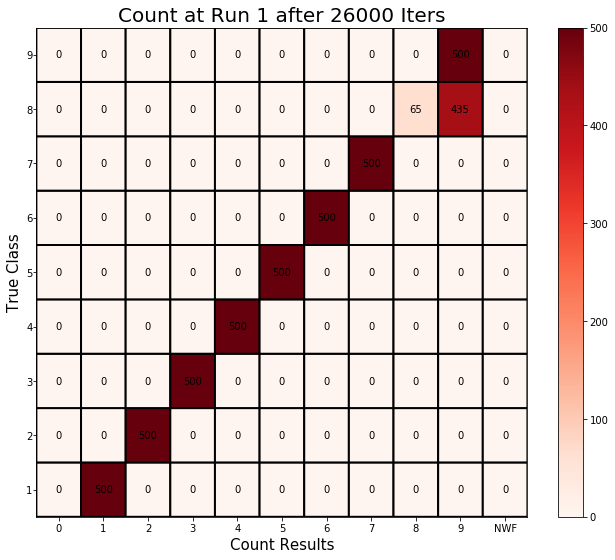

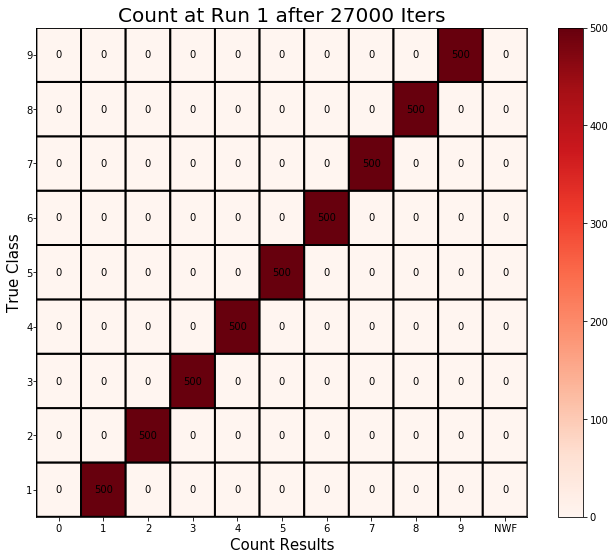

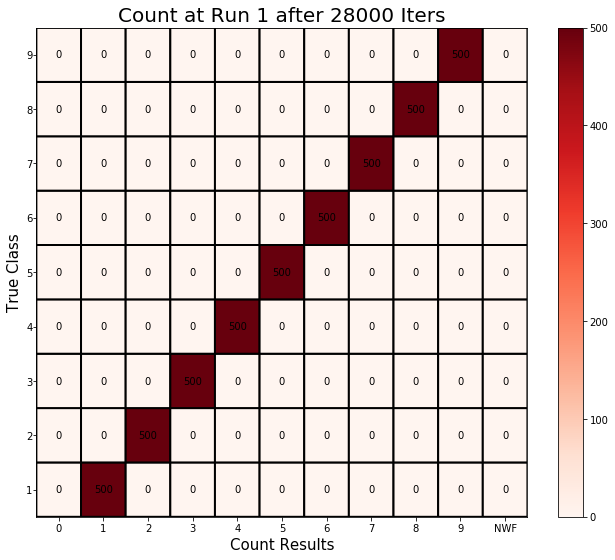

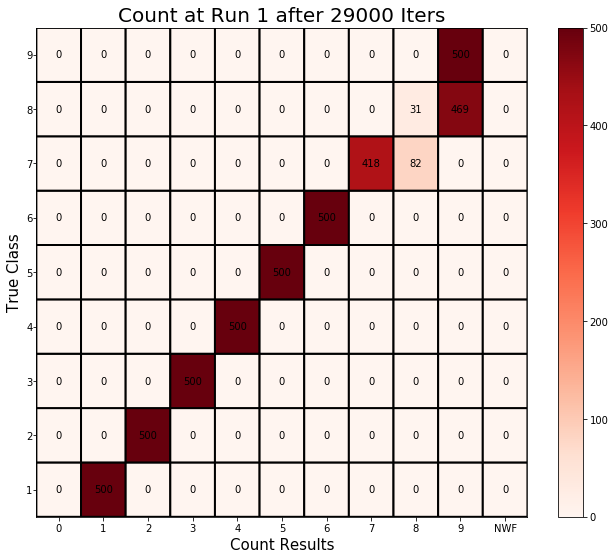

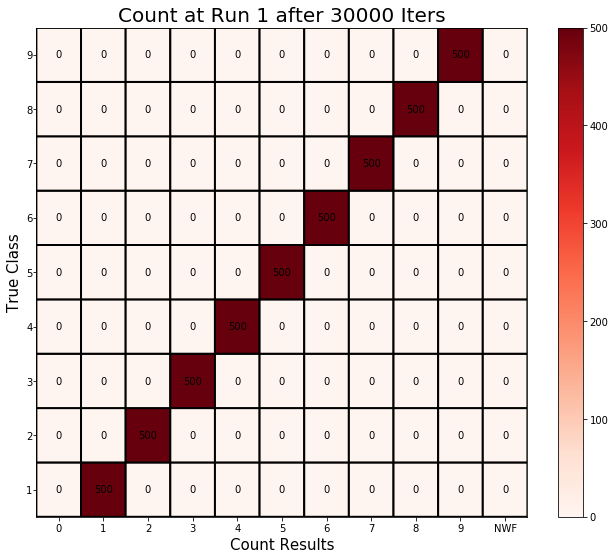

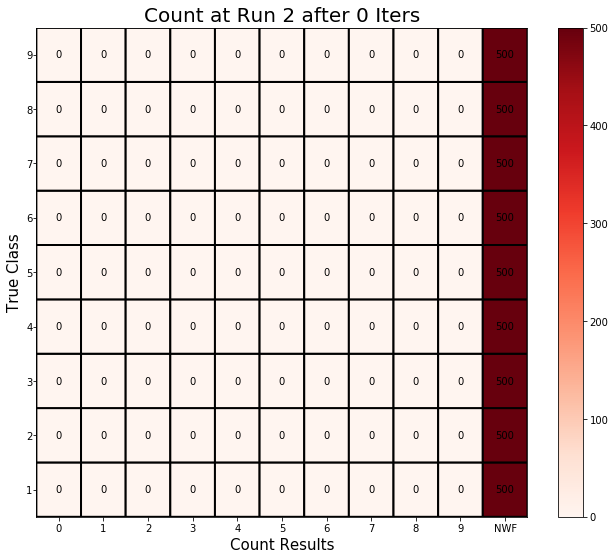

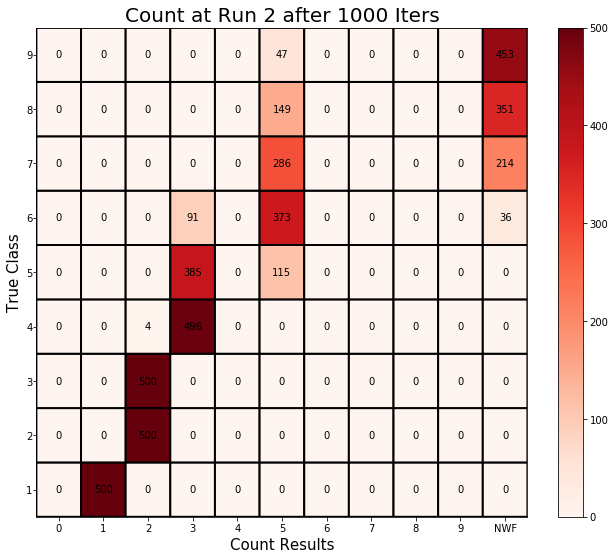

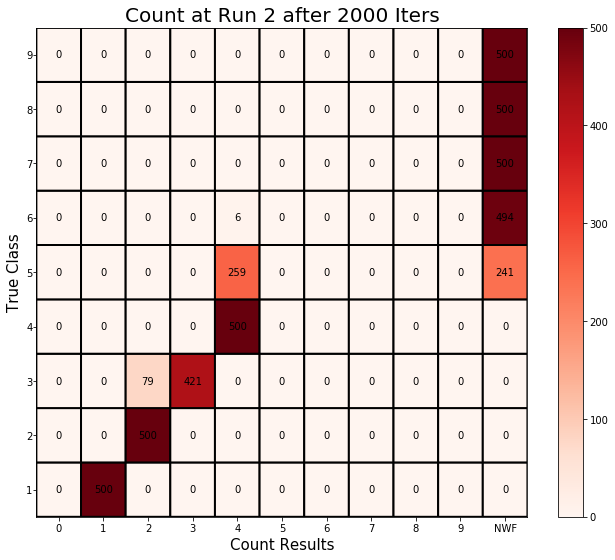

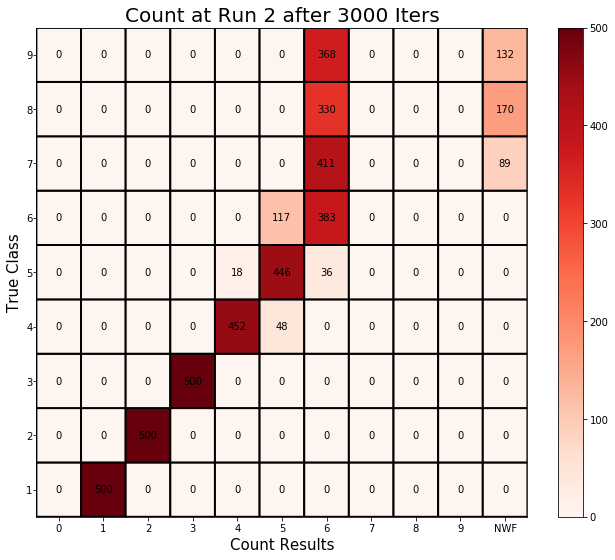

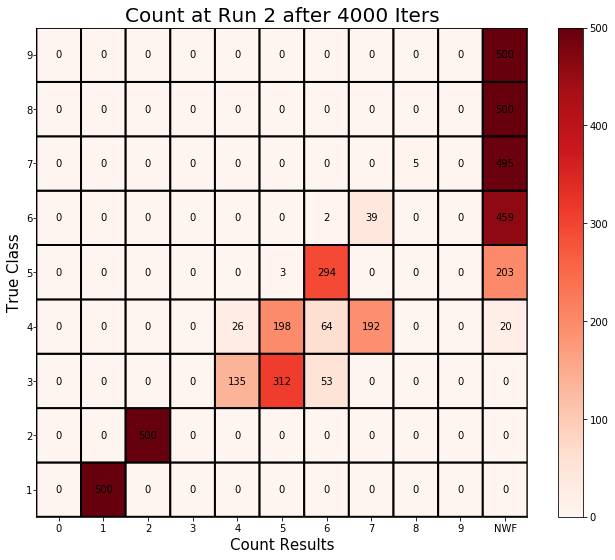

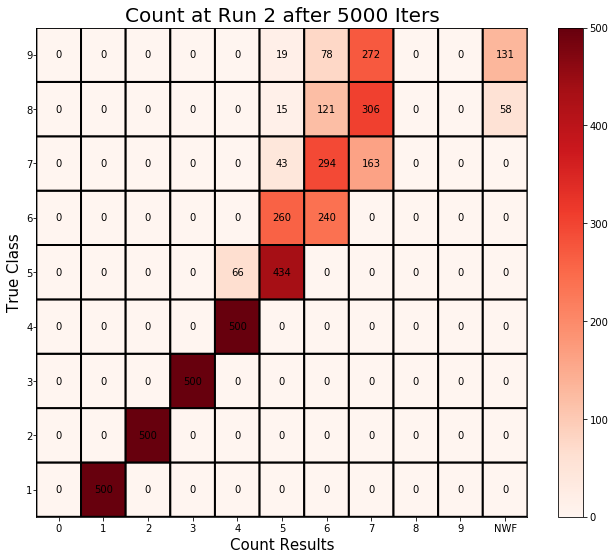

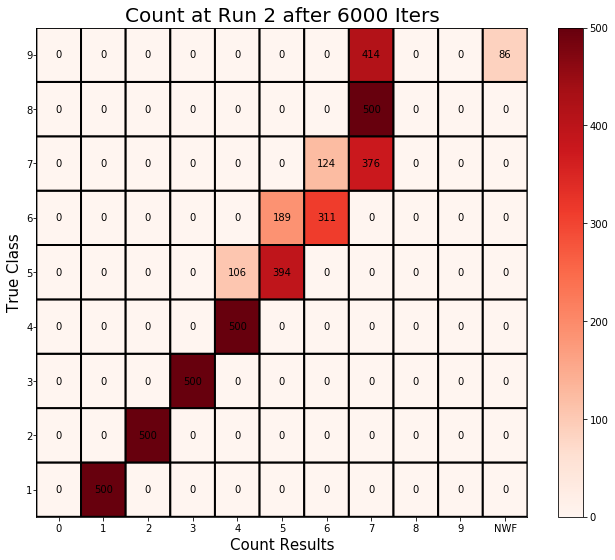

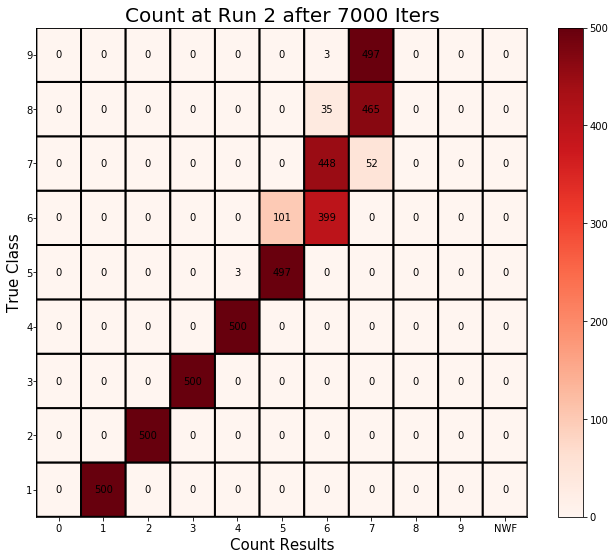

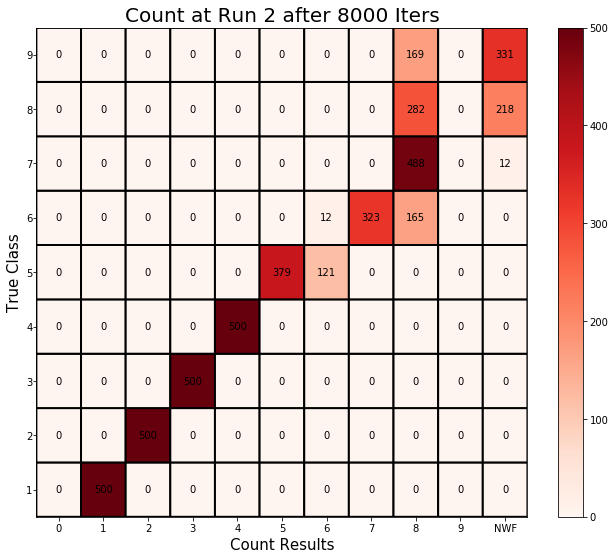

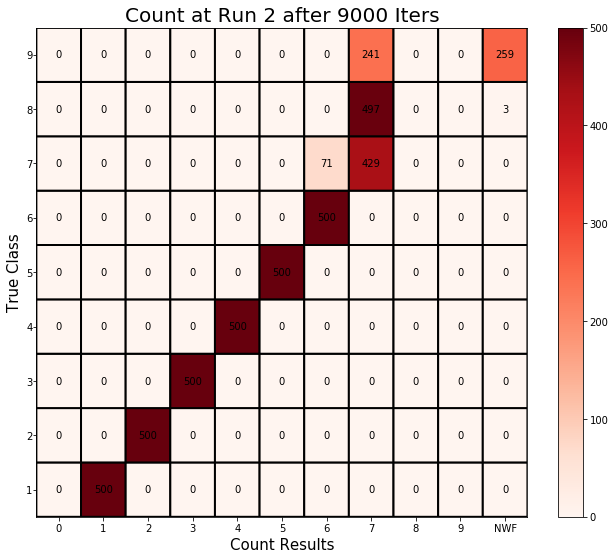

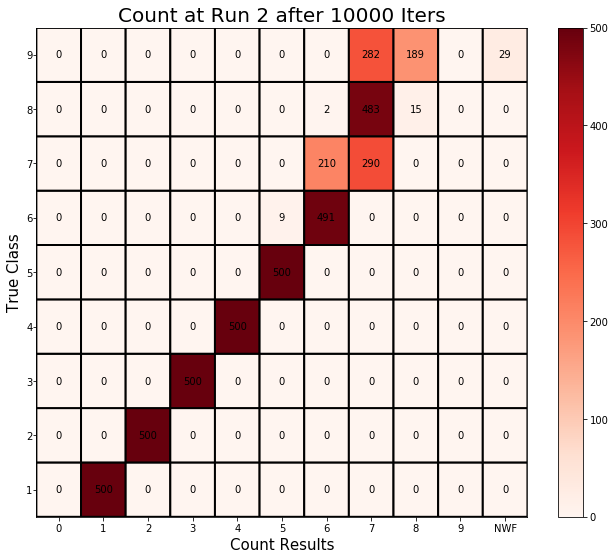

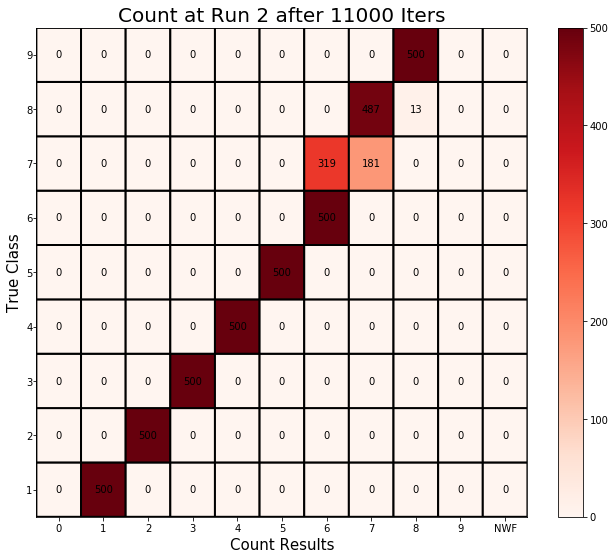

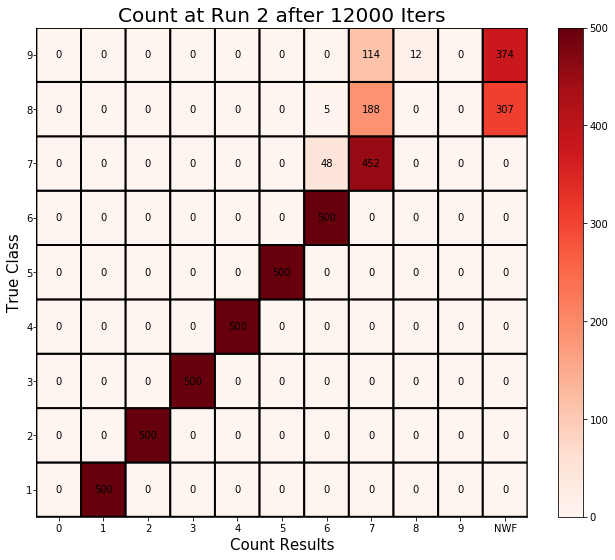

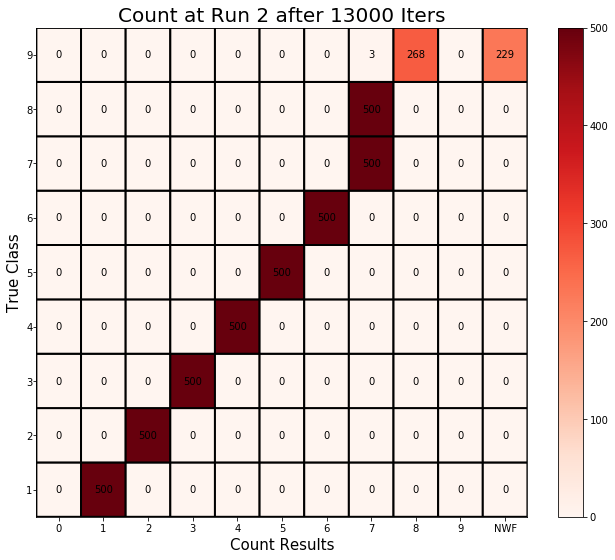

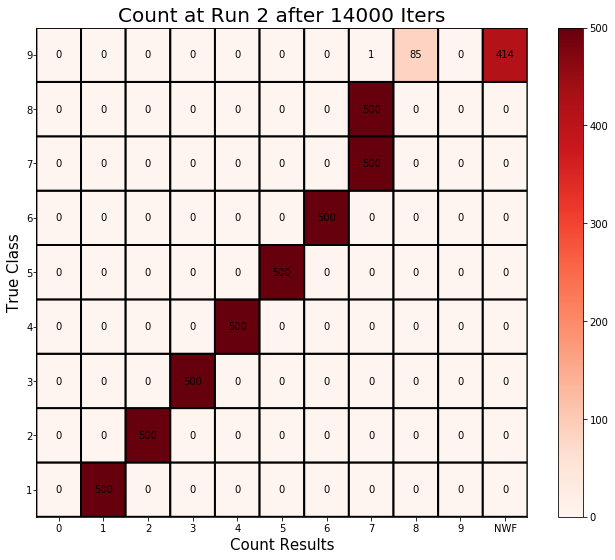

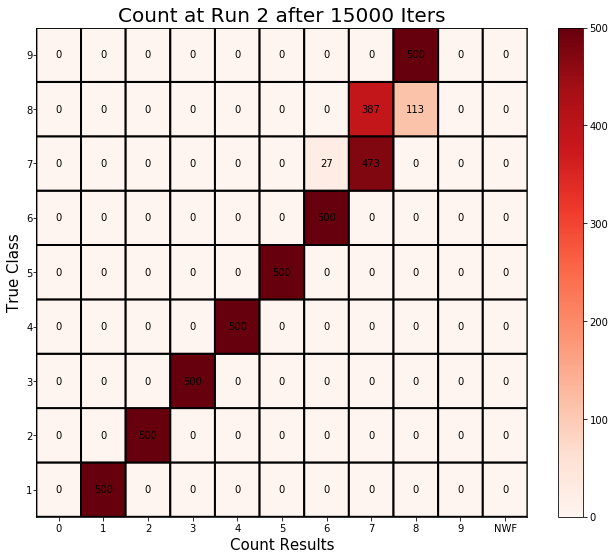

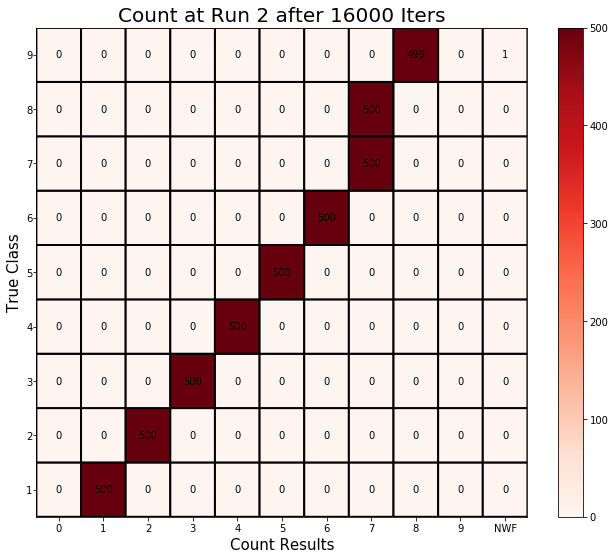

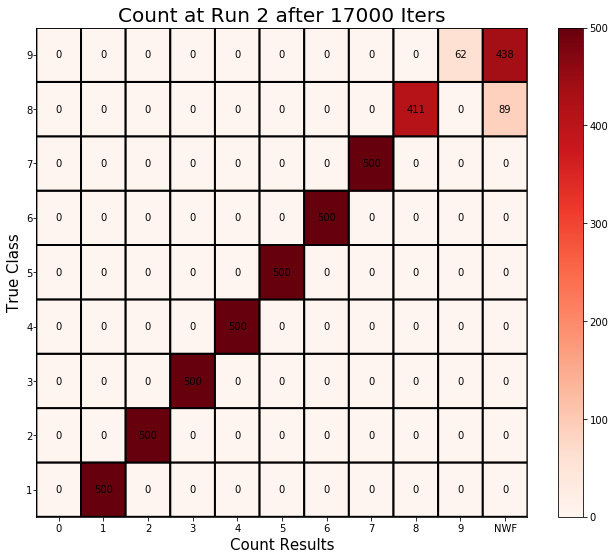

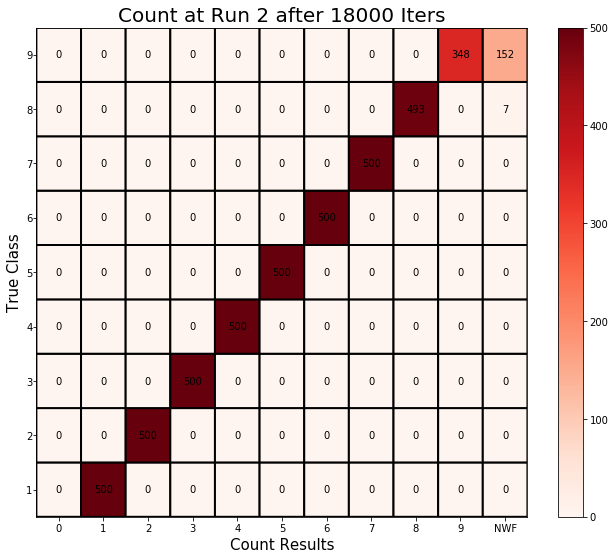

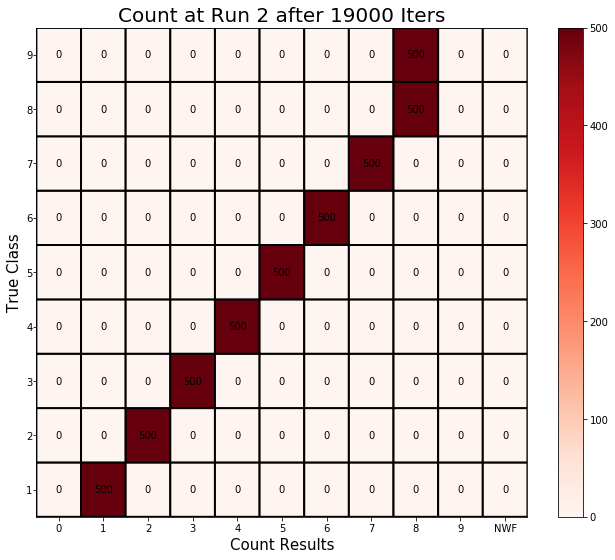

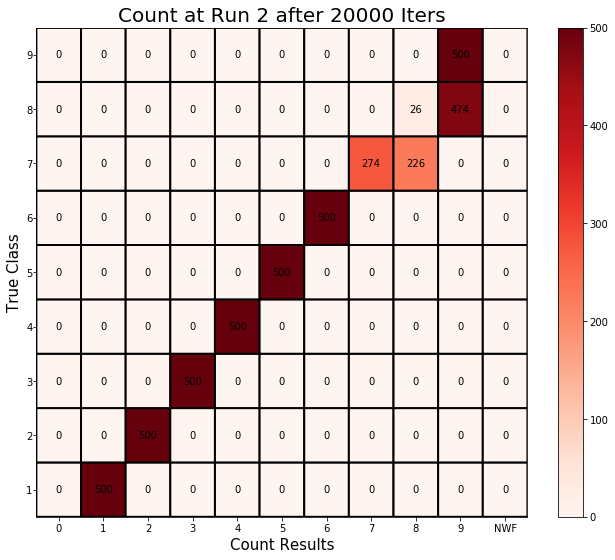

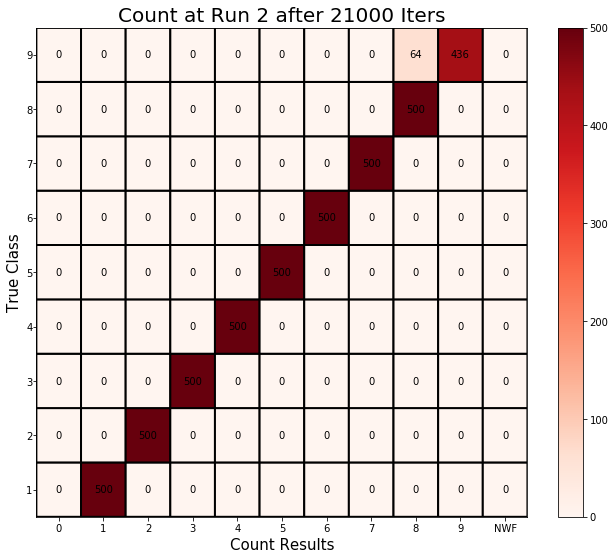

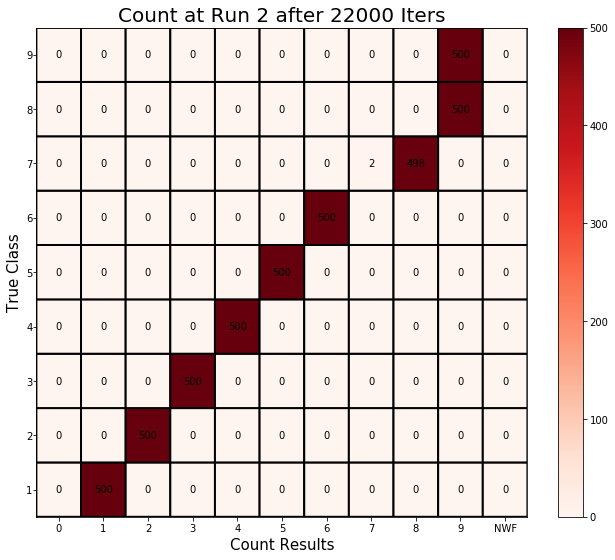

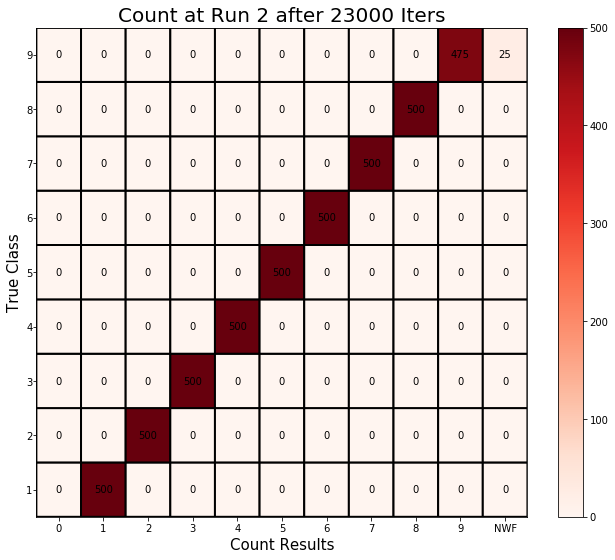

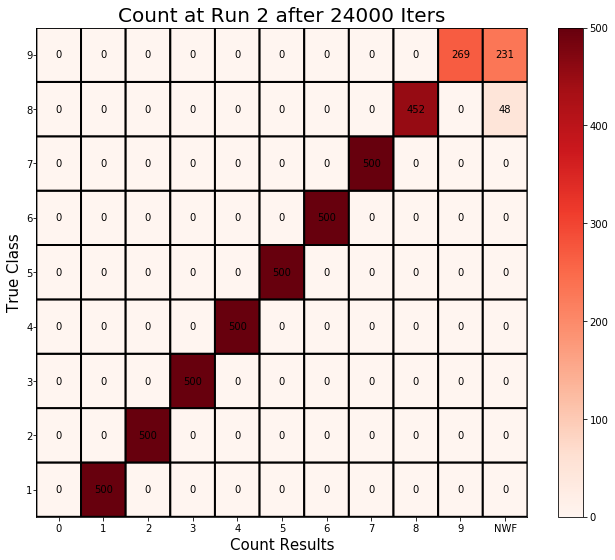

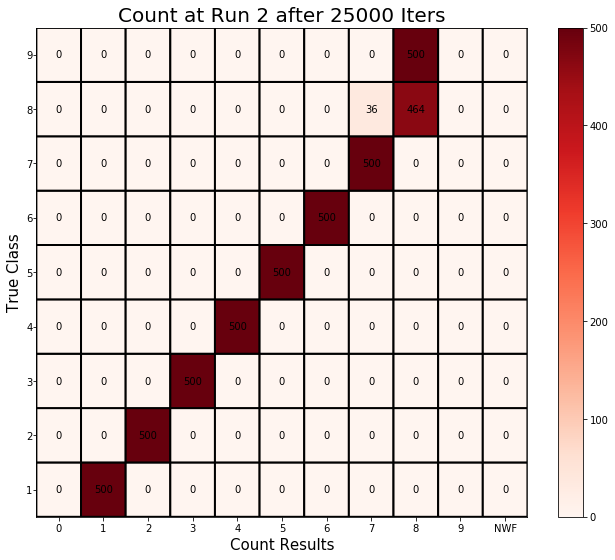

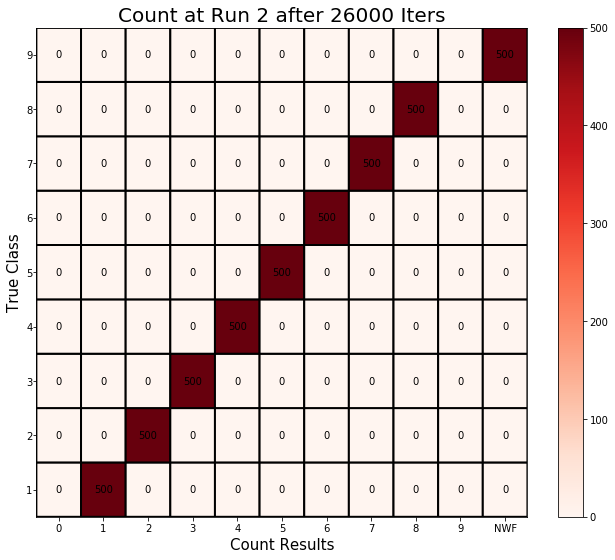

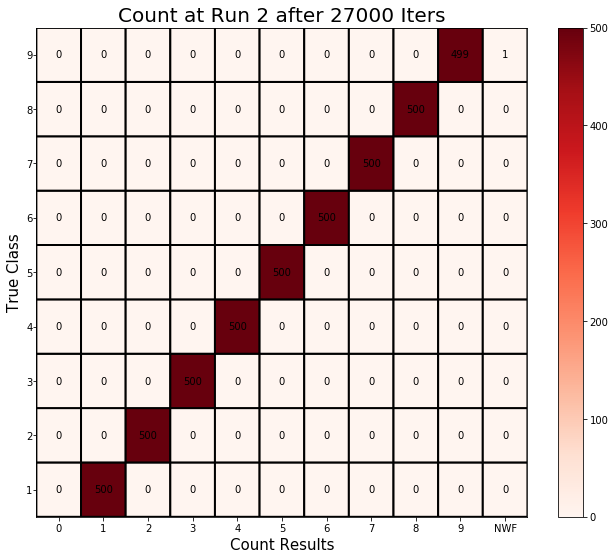

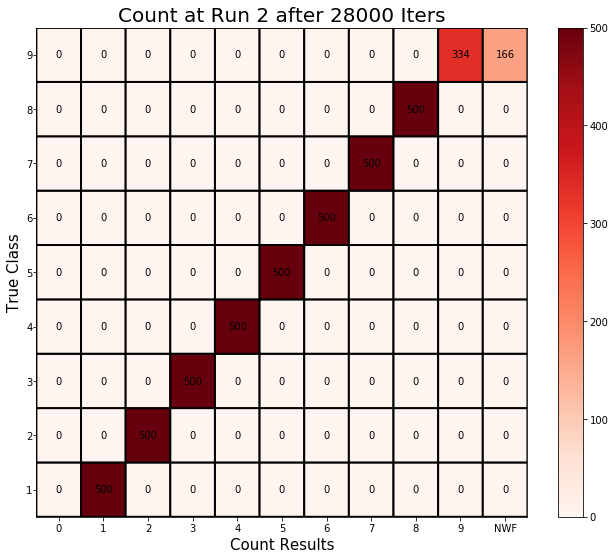

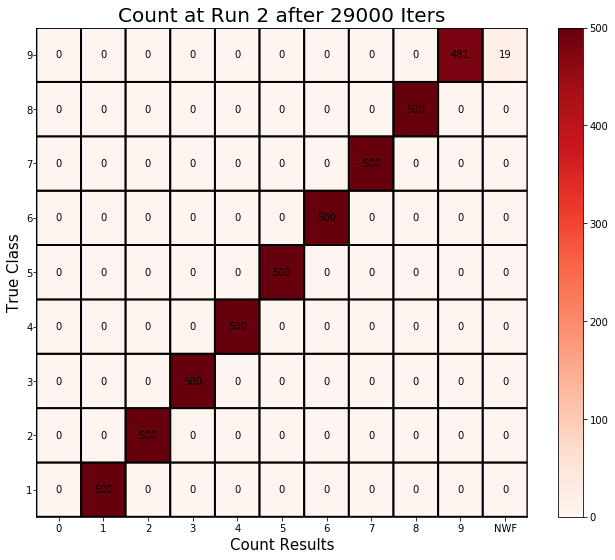

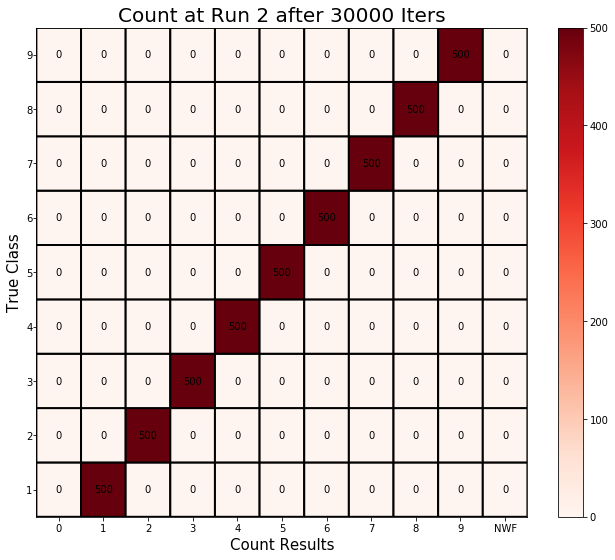

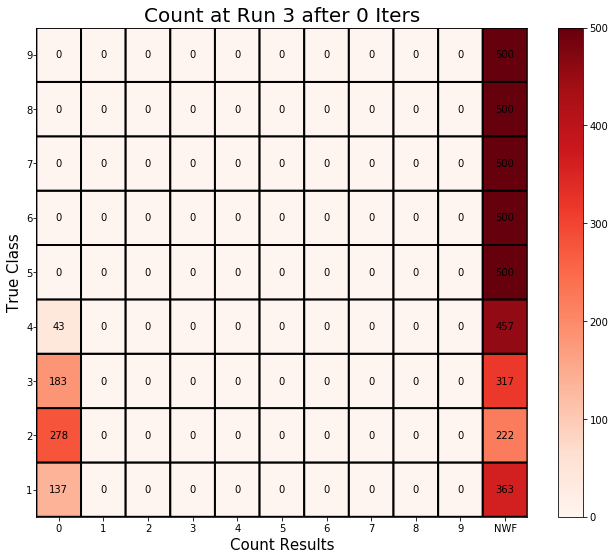

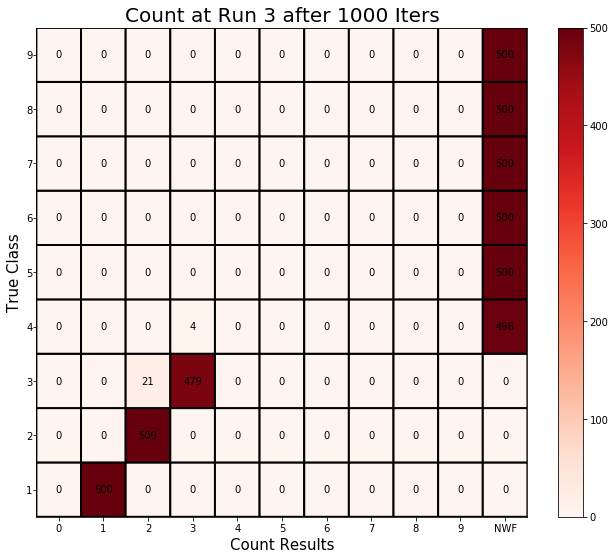

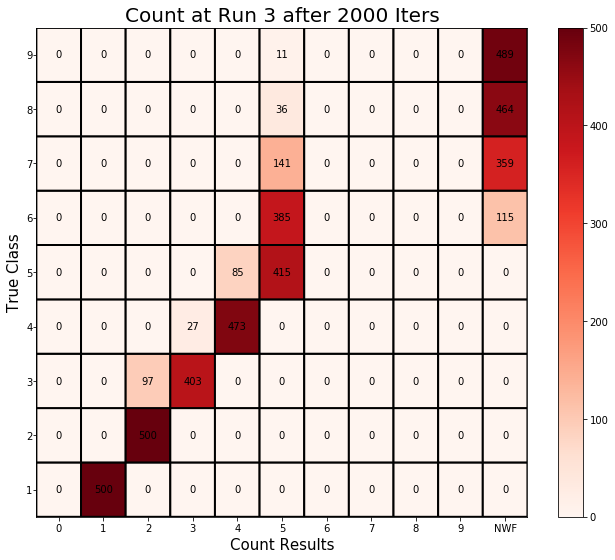

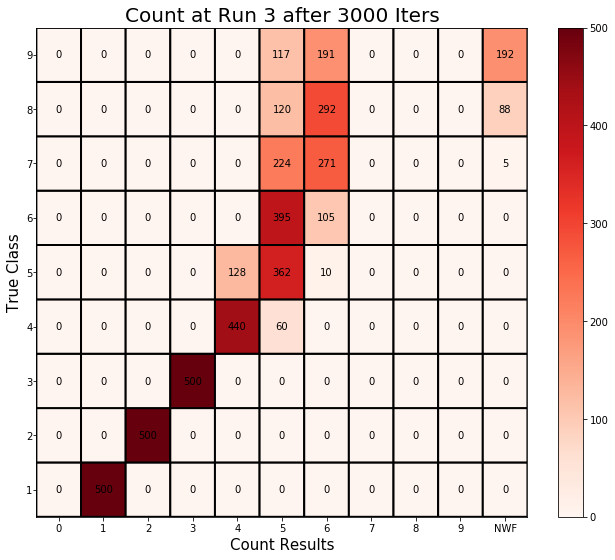

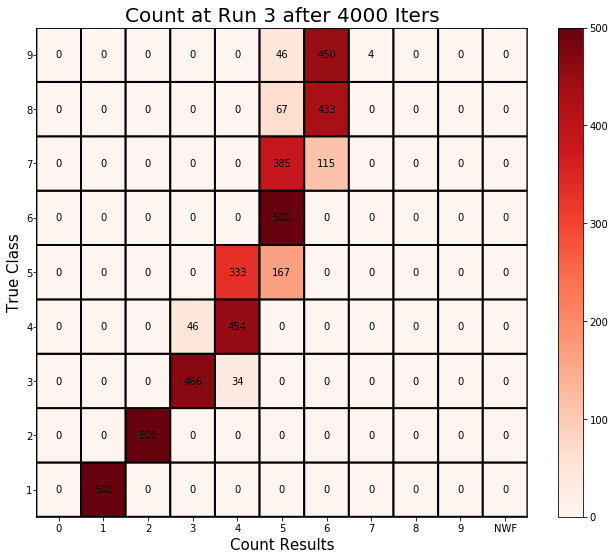

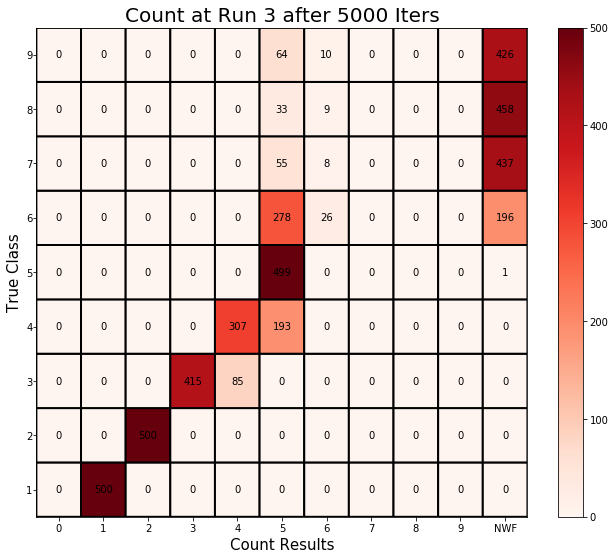

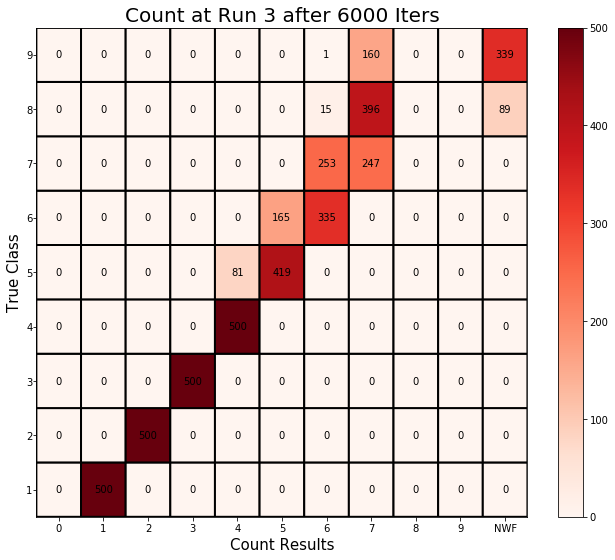

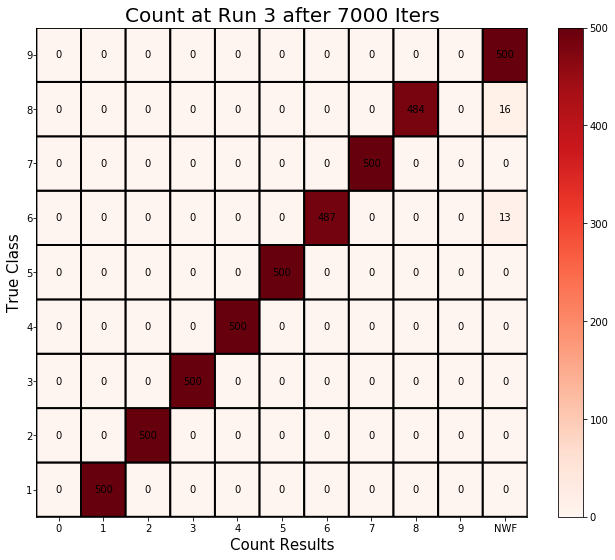

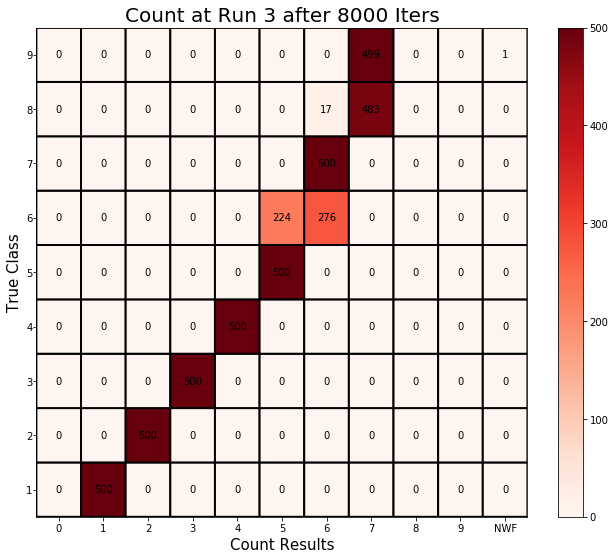

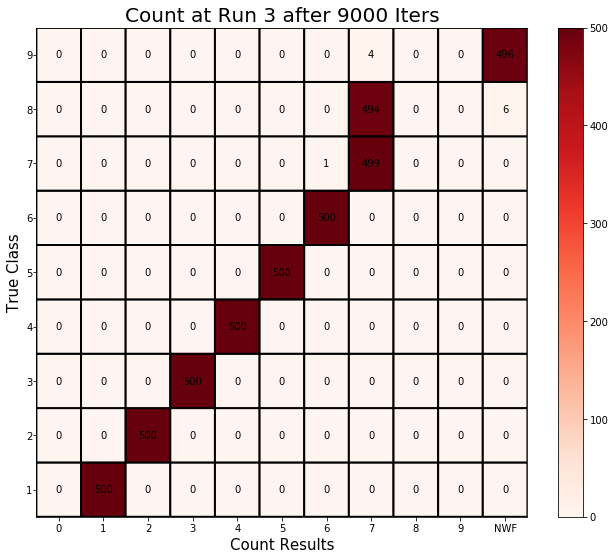

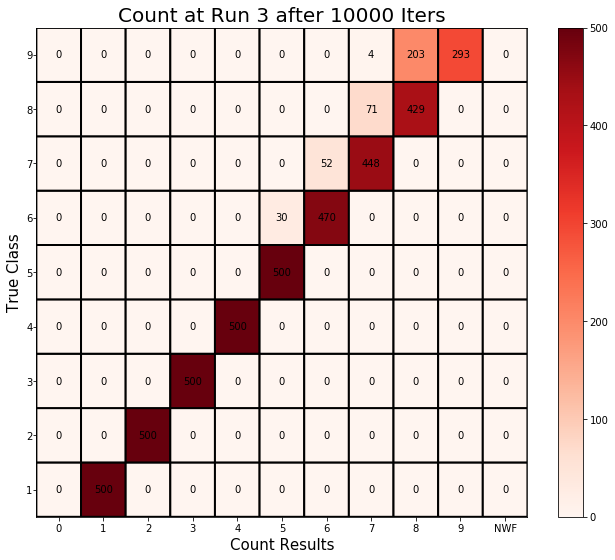

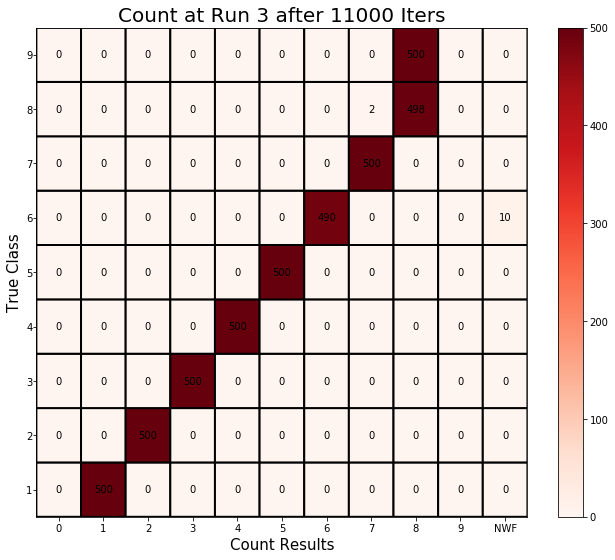

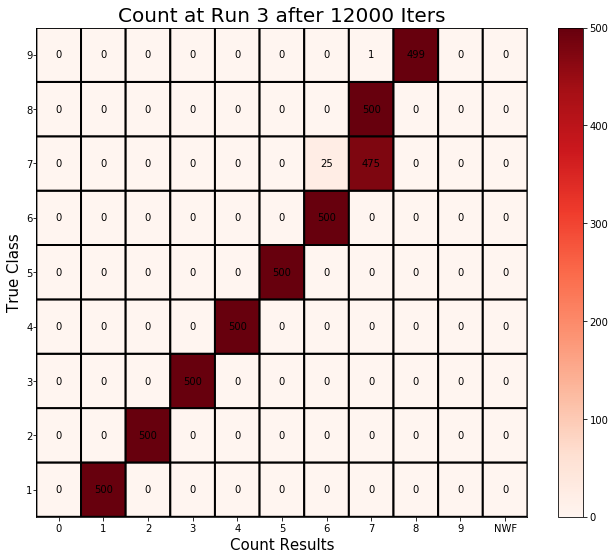

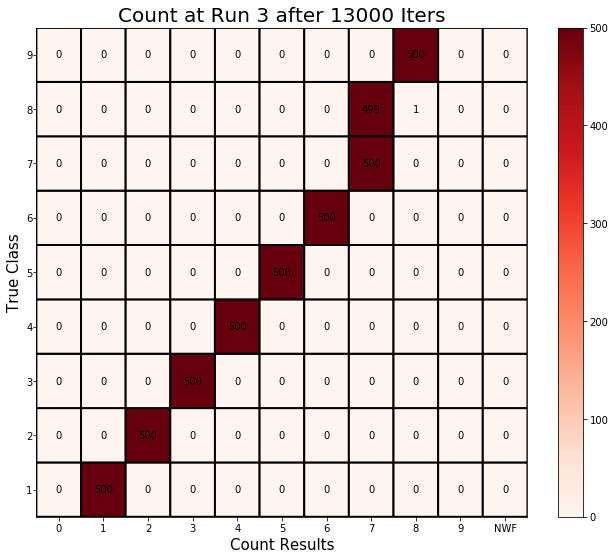

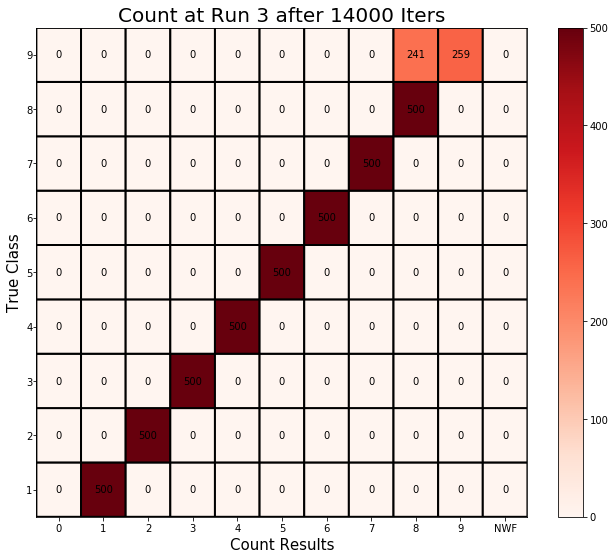

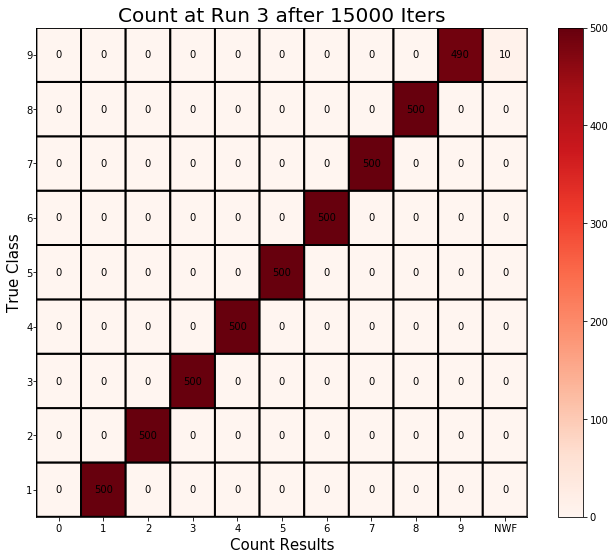

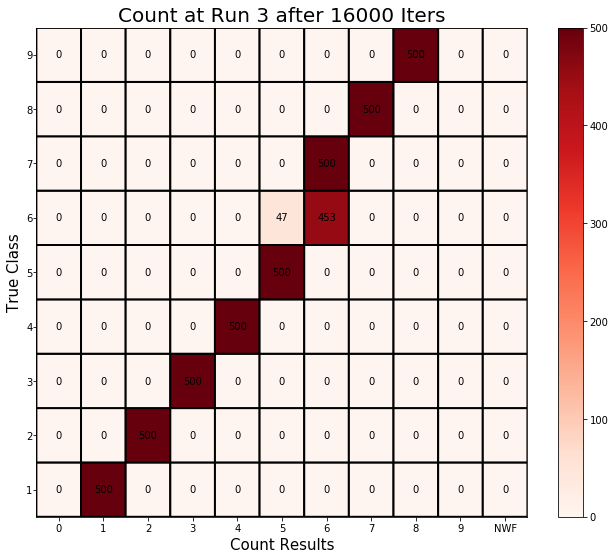

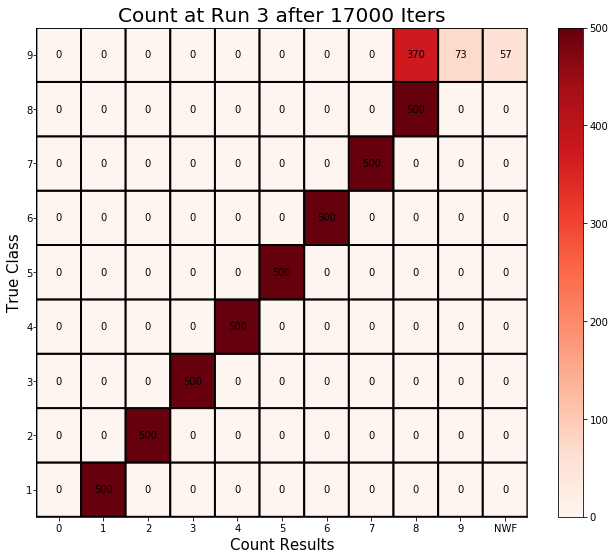

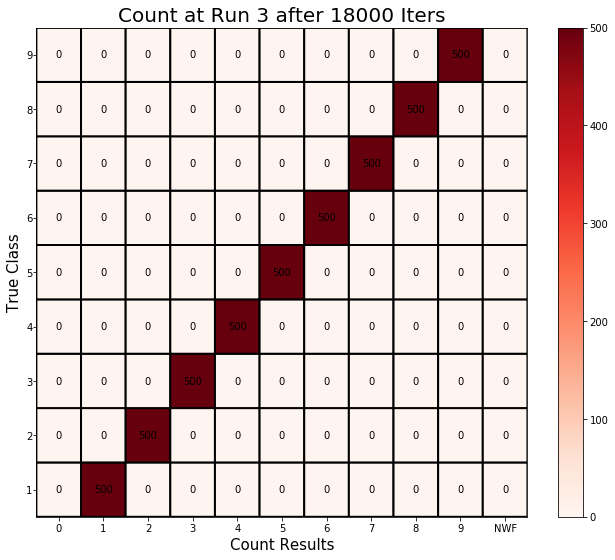

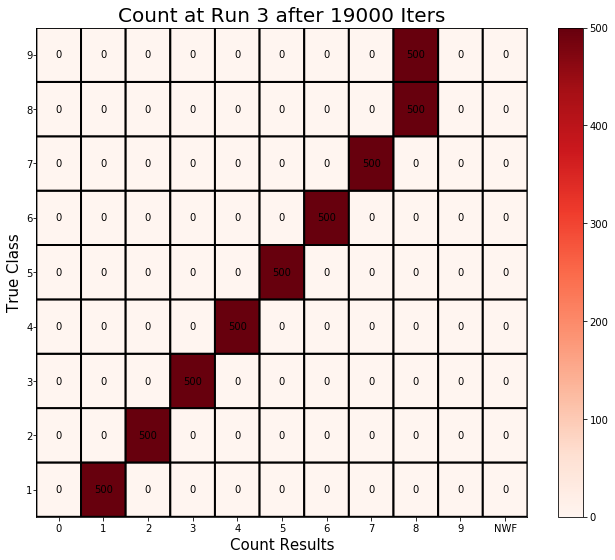

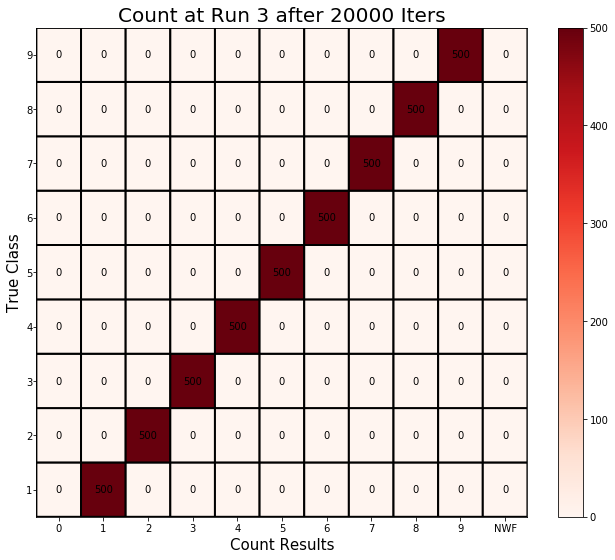

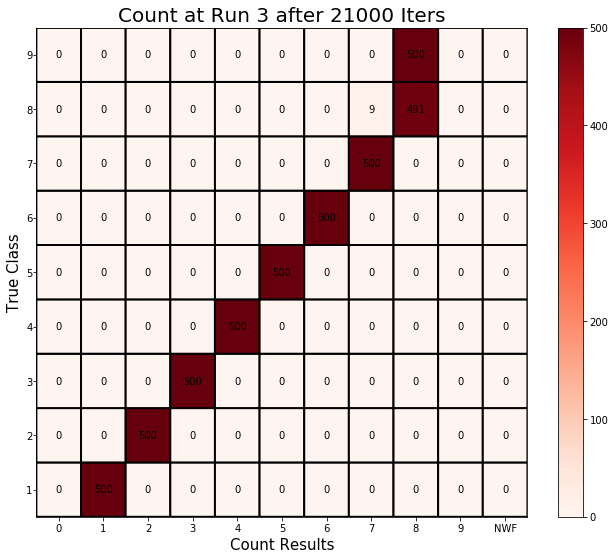

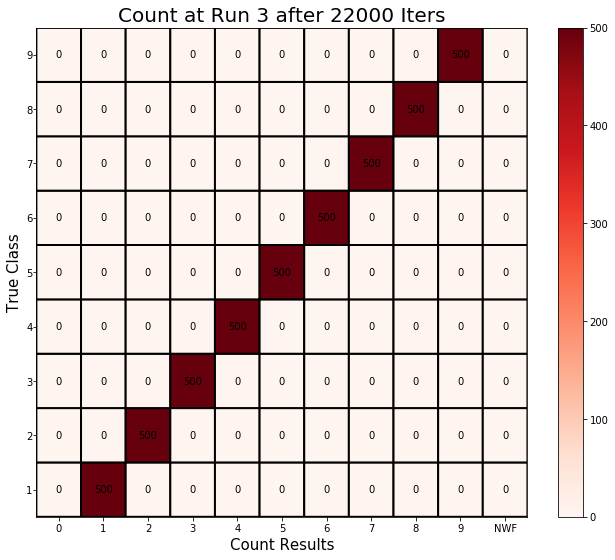

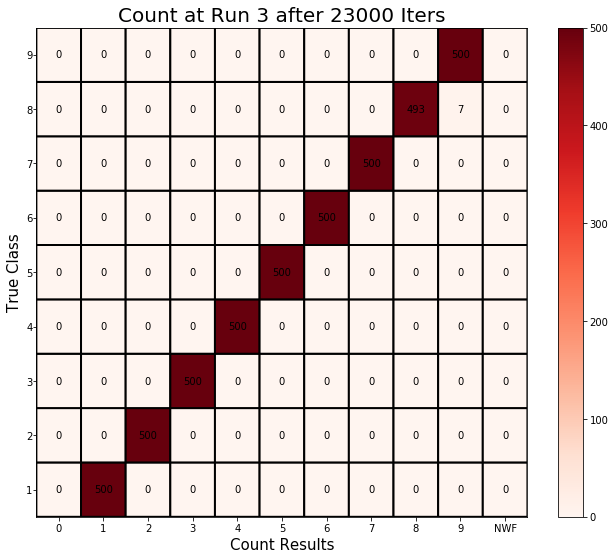

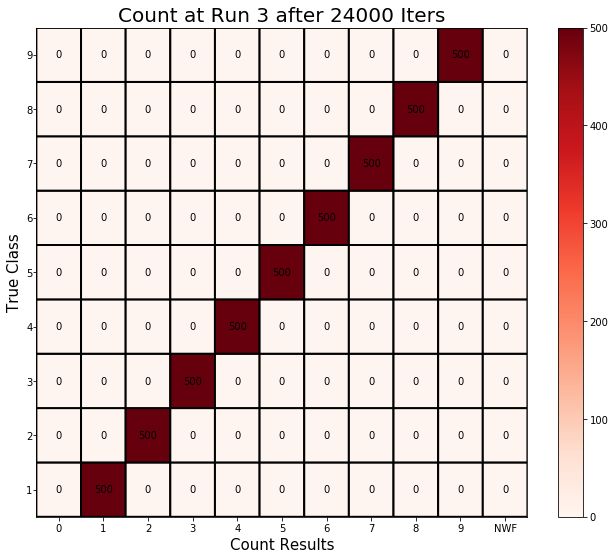

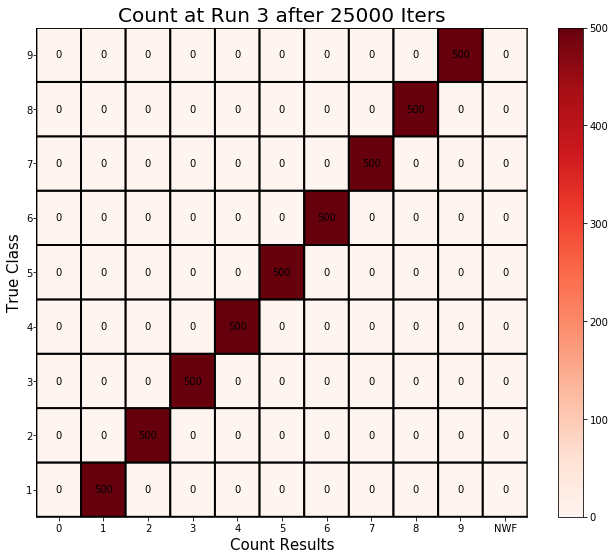

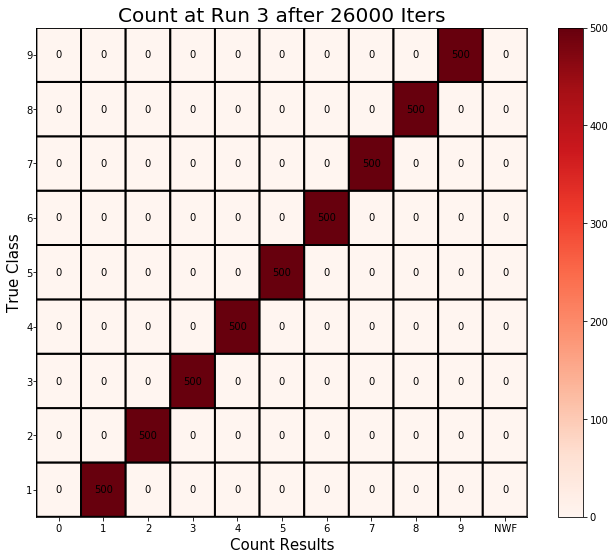

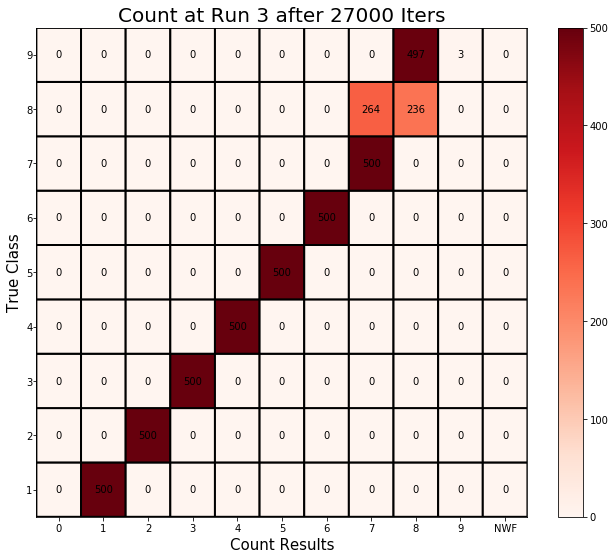

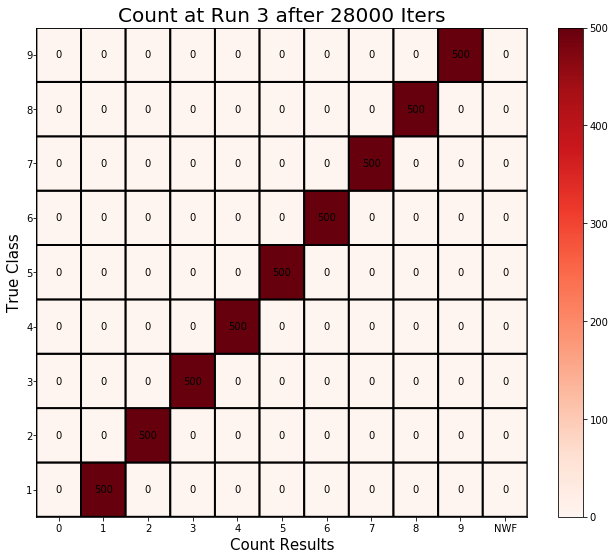

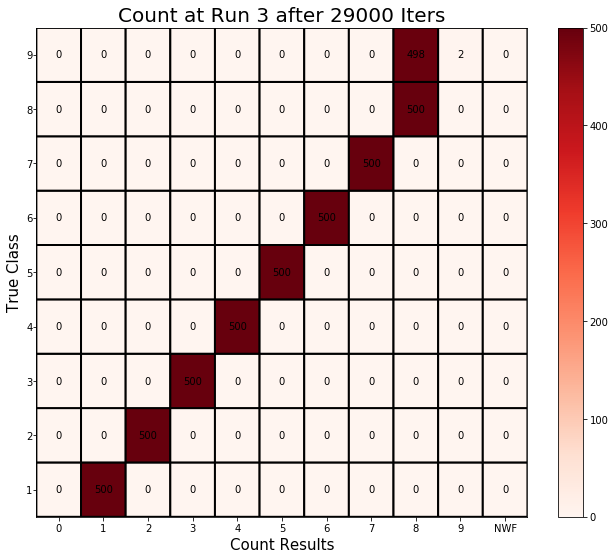

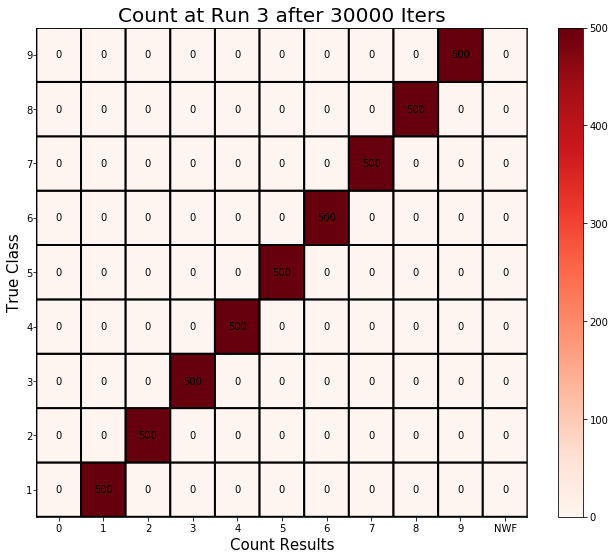

In [17]:
for run in range(num_runs):
    for it in range(num_iters):
        plot_count_results_wv(run,it)

In [18]:
# How high the network can count?
high_cot = np.zeros([num_runs, num_iters]) 
for i in range(num_runs):
    for j in range(num_iters):
        k=0
        while (k<output_size-1): 
            if count_results[i][j][k][k+1]/test_trials>=0.67:
                high_cot[i][j]+=1
                k+=1
            else:
                k=output_size

def plot_highest_count(run):
    """Plot the highest count."""
    x = iter_list
    y = high_cot[run]
    plot_title = "The highest count at Run %d" % (run + 1)
    plt.title(plot_title)
    plt.plot(x, y, '.-', color='r')
    plt.axis([iter_list[0]-test_trials, iter_list[num_iters-1]+test_trials, 0, 10])
    plt.xlabel('Iteration')
    plt.ylabel('Highest count word')
    plt.show()

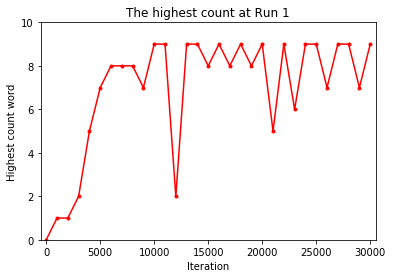

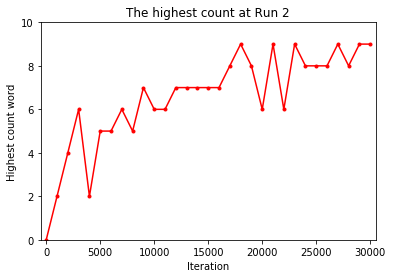

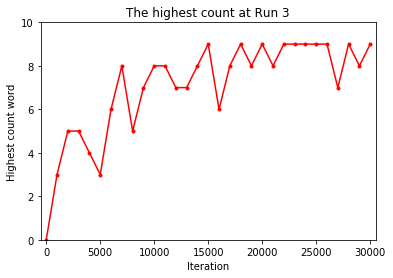

In [19]:
for run in range(num_runs):
    plot_highest_count(run)

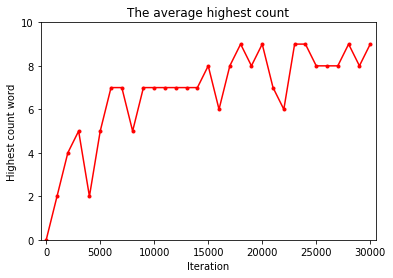

In [20]:
count_results_avg = np.mean(count_results, axis=0)
# AVERAGE: How high the network can count?
high_cot_avg = np.zeros(num_iters) 
for j in range(num_iters):
    k=0
    while (k<output_size-1): 
        if count_results_avg[j][k][k+1]/test_trials>=0.67:
            high_cot_avg[j]+=1
            k+=1
        else:
            k=output_size

def plot_highest_count_avg():
    """Plot the highest count."""
    x = iter_list
    y = high_cot_avg
    plot_title = "The average highest count"
    plt.title(plot_title)
    plt.plot(x, y, '.-', color='r')
    plt.axis([iter_list[0]-test_trials, iter_list[num_iters-1]+test_trials, 0, 10])
    plt.xlabel('Iteration')
    plt.ylabel('Highest count word')
    plt.show()
    
plot_highest_count_avg()

In [21]:
count_accuracy = np.zeros([num_runs, output_size-1, num_iters])
for i in range(num_runs):
    for j in range(output_size-1):
        for k in range(num_iters):
            count_accuracy[i][j][k]=count_results[i][k][j][j+1]/test_trials

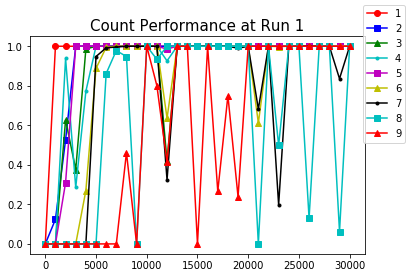

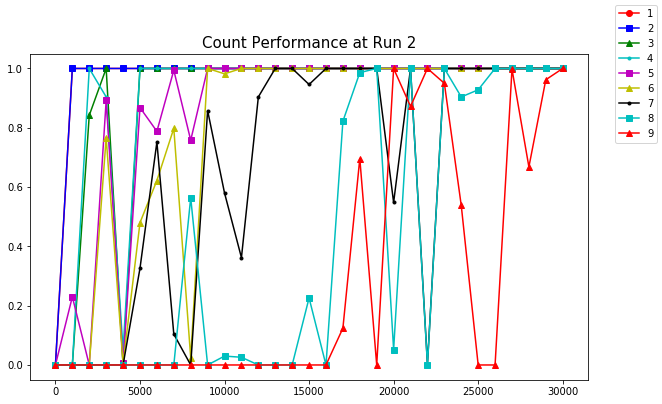

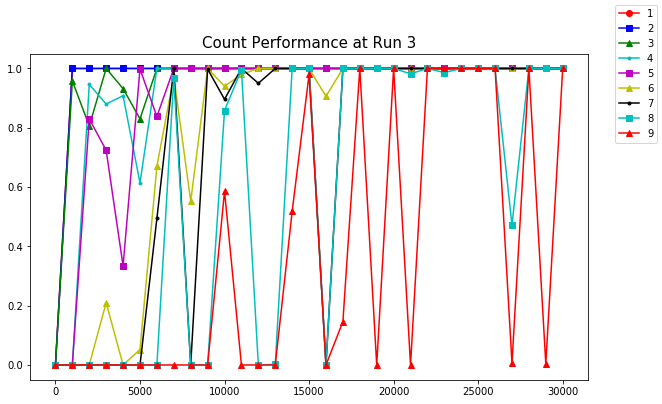

In [22]:
for i in range(num_runs):
    fig, axs = plt.subplots(1, 1)
    plt.rcParams["figure.figsize"] = [10,6]
    x = np.linspace(iter_list[0], iter_list[num_iters-1], num_iters)
    y1 = count_accuracy[i,0]
    y2 = count_accuracy[i,1]
    y3 = count_accuracy[i,2]
    y4 = count_accuracy[i,3]
    y5 = count_accuracy[i,4]
    y6 = count_accuracy[i,5]
    y7 = count_accuracy[i,6]
    y8 = count_accuracy[i,7]
    y9 = count_accuracy[i,8]
    l1, l2, l3, l4, l5, l6, l7, l8, l9 = axs.plot(x, y1, 'ro-', x, y2, 'bs-', x, y3, 'g^-', x, y4, 'c.-', x, y5, 'ms-', x, y6, 'y^-', x, y7, 'k.-', x, y8, 'cs-', x, y9, 'r^-')

    fig.legend((l1, l2, l3, l4, l5, l6, l7, l8, l9), ('1', '2', '3', '4', '5', '6', '7', '8', '9'), 'left')
    plot_title = "Count Performance at Run %d" % (i + 1)
    plt.title(plot_title, fontsize=15)

# Point Analysis

In [19]:
pstop_idx=np.ones([num_runs, num_iters, num_imgs])*(-1)

for i in range(num_runs):
    for j in range(num_iters):
        for k in range (num_imgs):
            for p in range (2, output_size+1):
                if blob_point_all_runs[i][j][k][p]!=-1 and blob_point_all_runs[i][j][k][p]==blob_point_all_runs[i][j][k][p-1]: # record end position
                    pstop_idx[i][j][k]=p
                    break # stop at the first repeated word

point_results=np.zeros([num_runs, num_iters, 9, 10])  

for i in range(num_runs):
    for j in range(num_iters):
        for k in range(num_imgs):
            # not-well-formed
            if pstop_idx[i][j][k]==-1: # no "I'm done!" signal
                point_results[i][j][int(blob_point_all_runs[i,j,k,0])-1][9]+=1         
            else:
                for p in range(1,int(pstop_idx[i][j][k])): 
                    if p!=blob_point_all_runs[i][j][k][p]:
                        point_results[i][j][int(blob_point_all_runs[i,j,k,0])-1][9]+=1
                        break 
                    elif p==pstop_idx[i][j][k]-1:
                        idx=int(max(blob_point_all_runs[i][j][k][1:int(pstop_idx[i][j][k])+1]))
                        point_results[i][j][int(blob_point_all_runs[i,j,k,0])-1][idx-1]+=1  

In [20]:
def plot_point_results_wv(run, it):
    """Plot the point heatmap with values."""
    data = point_results[run, it]
    title = "Point at Run %d after %d Iters" % (run + 1, iter_list[it])
    xlabel= "Point Results"
    ylabel="True Class"
    plt.figure(figsize=(output_size, output_size-1))
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    c = plt.pcolor(data, edgecolors='k', linewidths=2, cmap='Reds', vmin=0, vmax=test_trials)
    xbars = ('1', '2', '3', '4', '5', '6', '7', '8', '9', 'NWF')
    x_pos=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]
    plt.xticks(x_pos, xbars, fontsize='10', horizontalalignment='center')
    ybars = ('1', '2', '3', '4', '5', '6', '7', '8', '9')
    y_pos=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]
    plt.yticks(y_pos, ybars, fontsize='10', horizontalalignment='center')
 
    def show_values(pc, fmt="%.0f", **kw):
        pc.update_scalarmappable()
        ax = pc.get_axes()
        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            color = (0.0, 0.0, 0.0) # value color
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

    show_values(c)
    plt.colorbar(c)

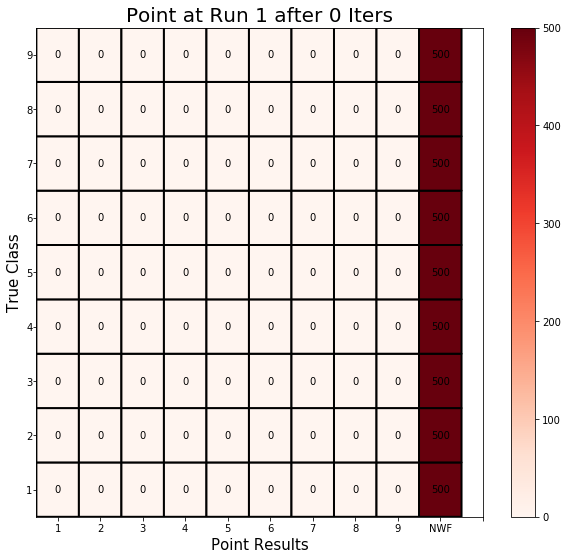

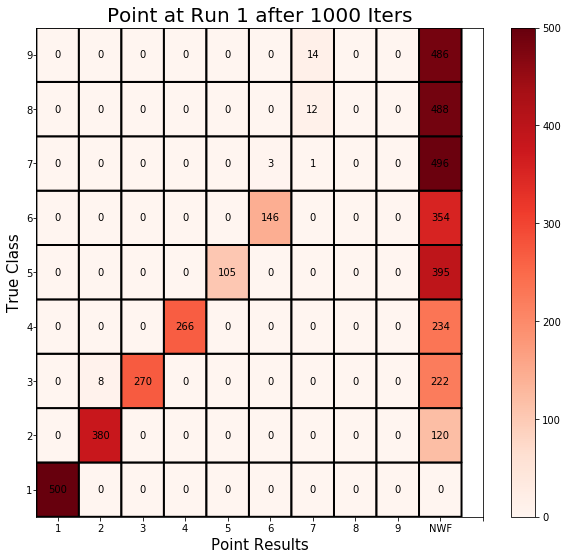

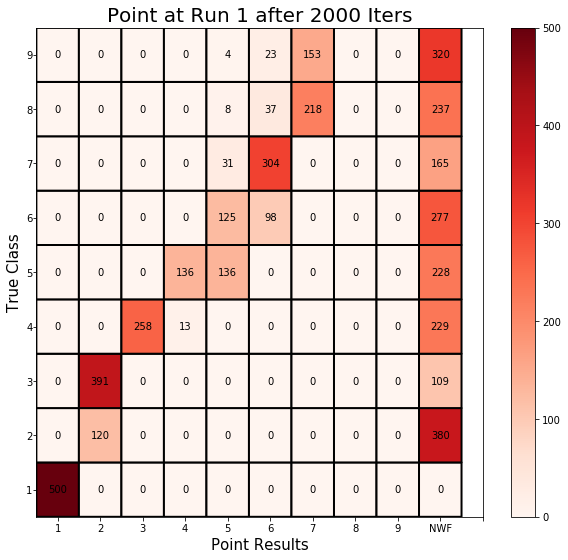

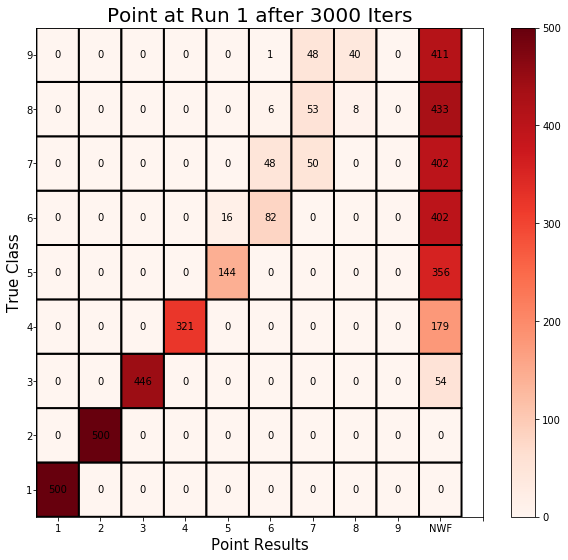

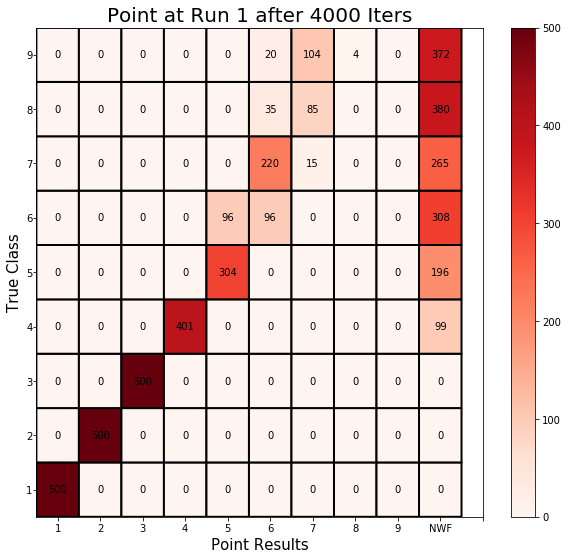

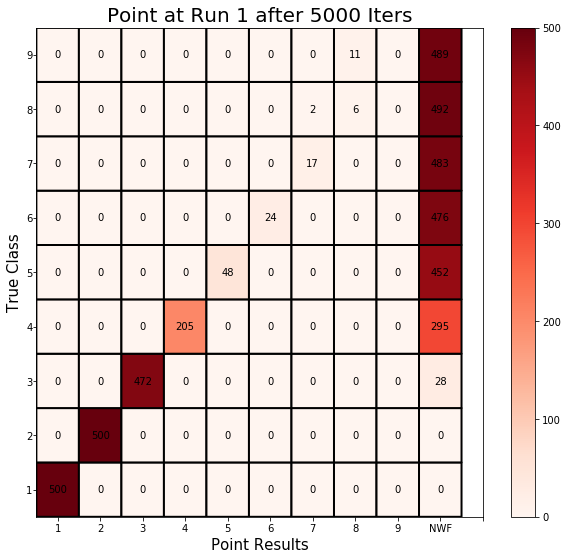

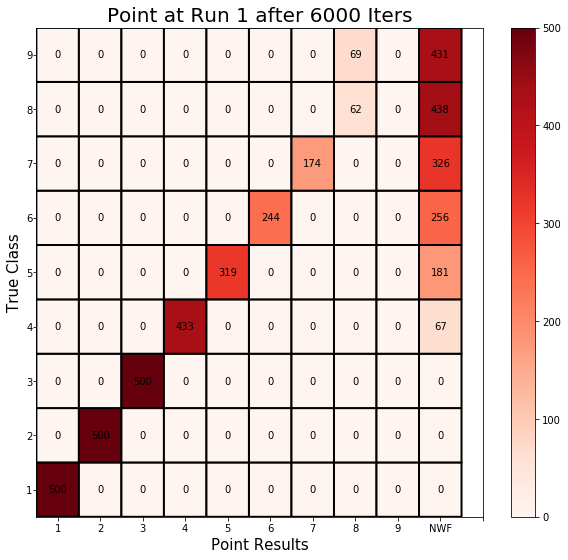

In [21]:
for run in range(num_runs):
    for it in range(num_iters):
        plot_point_results_wv(run,it)

In [22]:
point_accuracy = np.zeros([num_runs, output_size-1, num_iters])
for i in range(num_runs):
    for j in range(output_size-1):
        for k in range(num_iters):
            point_accuracy[i][j][k]=point_results[i][k][j][j]/test_trials

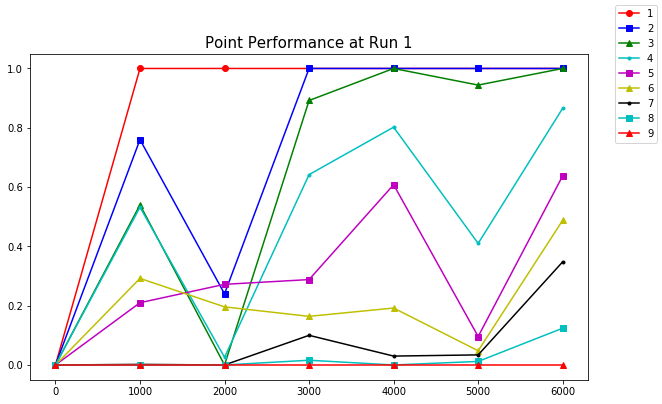

In [23]:
for i in range(num_runs):
    fig, axs = plt.subplots(1, 1)
    x = np.linspace(iter_list[0], iter_list[num_iters-1], num_iters)
    y1 = point_accuracy[i,0]
    y2 = point_accuracy[i,1]
    y3 = point_accuracy[i,2]
    y4 = point_accuracy[i,3]
    y5 = point_accuracy[i,4]
    y6 = point_accuracy[i,5]
    y7 = point_accuracy[i,6]
    y8 = point_accuracy[i,7]
    y9 = point_accuracy[i,8]
    l1, l2, l3, l4, l5, l6, l7, l8, l9 = axs.plot(x, y1, 'ro-', x, y2, 'bs-', x, y3, 'g^-', x, y4, 'c.-', x, y5, 'ms-', x, y6, 'y^-', x, y7, 'k.-', x, y8, 'cs-', x, y9, 'r^-')
     
    fig.legend((l1, l2, l3, l4, l5, l6, l7, l8, l9), ('1', '2', '3', '4', '5', '6', '7', '8', '9'), 'left')
    plot_title = "Point Performance at Run %d" % (i + 1)
    plt.title(plot_title, fontsize=15)
    plt.rcParams["figure.figsize"] = [10,6]
    
    #plt.tight_layout()
    plt.show()

# Coding Types of Errors

In [28]:
error = np.zeros([num_runs, num_iters, 8])
# error[0]: correct; error[1]: string error; error[2]: done error; error[3]: skip; error[4]: stop short; error[5]: double count; error[6]:continue; error[7]: Others
for i in range(num_runs):
    for j in range(num_iters):
        for k in range(num_imgs):
            cot_idx=int(count_class[i][j][k]) # the last count word produced by NN
            if cot_idx==countword_all_runs[i][j][k][0]: # correct
                error[i][j][0]+=1         
            elif cot_idx ==-1: # string error (count words in an incorrect order)
                error[i][j][1]+=1
            elif cot_idx ==0: # done error (say "I'm done!" at the very beginning)
                error[i][j][2]+=1
            elif cot_idx<countword_all_runs[i][j][k][0]: # count too far
                if blob_point_all_runs[i][j][k][cot_idx]==blob_point_all_runs[i][j][k][cot_idx+1]:
                    if blob_point_all_runs[i][j][k][cot_idx]>cot_idx:
                        for p in range(1, cot_idx):
                            if blob_point_all_runs[i][j][k][p]>=blob_point_all_runs[i][j][k][p+1]:
                                error[i][j][7]+=1 # others 
                                break
                            elif p==cot_idx-1:
                                error[i][j][3]+=1 # skip error
                    elif blob_point_all_runs[i][j][k][cot_idx]==cot_idx:
                        for p in range(1, cot_idx):
                            if blob_point_all_runs[i][j][k][p]+1!=blob_point_all_runs[i][j][k][p+1]:
                                error[i][j][7]+=1 # others
                                break
                            elif p==cot_idx-1:
                                error[i][j][4]+=1 # stop short
                else:
                    error[i][j][7]+=1 # others       
            else: # count too short
                if blob_point_all_runs[i][j][k][cot_idx]==blob_point_all_runs[i][j][k][cot_idx+1]:
                    if blob_point_all_runs[i][j][k][cot_idx]<cot_idx:
                        for p in range(1, cot_idx):
                            if blob_point_all_runs[i][j][k][p]>blob_point_all_runs[i][j][k][p+1]:
                                error[i][j][7]+=1 # others
                                break
                            elif blob_point_all_runs[i][j][k][p]<blob_point_all_runs[i][j][k][p+1]-1:
                                error[i][j][7]+=1 # others
                                break
                            elif p==cot_idx-1:
                                error[i][j][5]+=1 # double count      
                else:
                    for q in range(1, int(countword_all_runs[i][j][k][0]+1)):
                        if blob_point_all_runs[i][j][k][q]!=pointblob_all_runs[i][j][k][q]:
                            error[i][j][7]+=1 # others       
                        elif q==countword_all_runs[i][j][k][0]:
                            error[i][j][6]+=1 # continue

In [29]:
def plot_error(run, it):
    """Plot the error categories."""
    N = 8
    ind = np.arange(N)    # the x locations for the groups
    width = 0.5       # the width of the bars: can also be len(x) sequence

    p = plt.bar(ind, error[run, it], width)
    plt.ylabel('Percent of Trials with Error Made')
    plt.title('Errors Made at Run %d after %d Iters' % (run + 1, iter_list[it]))
    plt.xticks(ind, ('Correct', 'String Error', 'Done Error', 'Skip', 'Stop Short', 'Double Count', 'Continue', 'Others'), rotation=30)
    plt.yticks(np.arange(0, 1900, 100))
    for a,b in zip(ind, error[run, it]):
        plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
    plt.show()

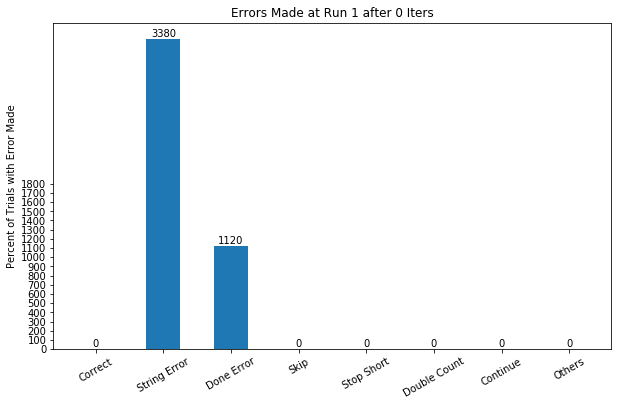

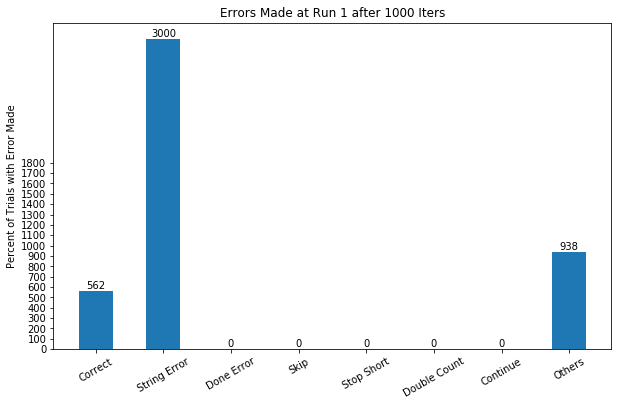

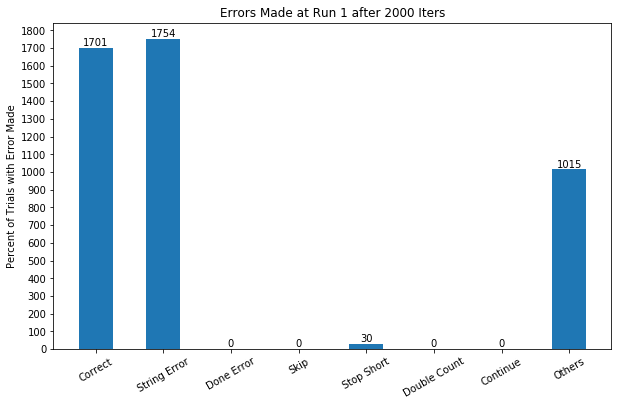

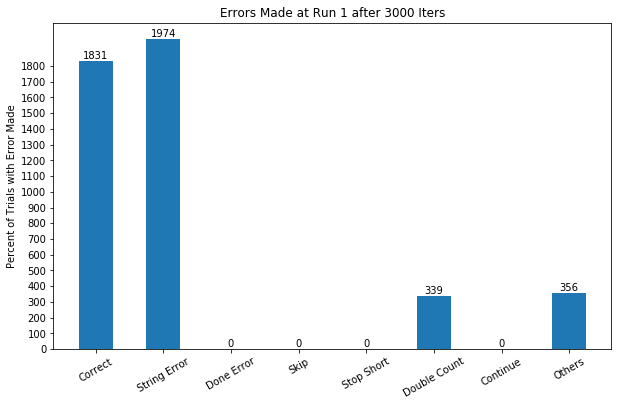

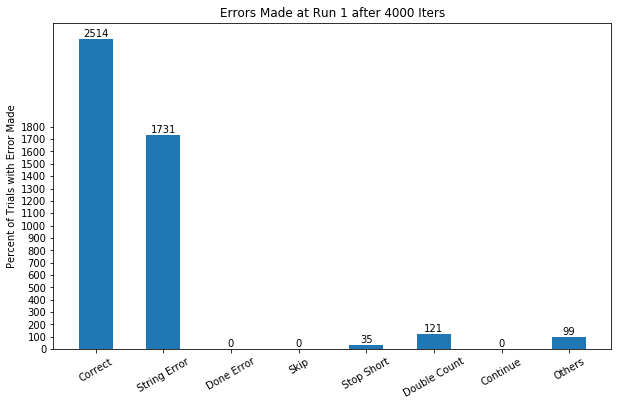

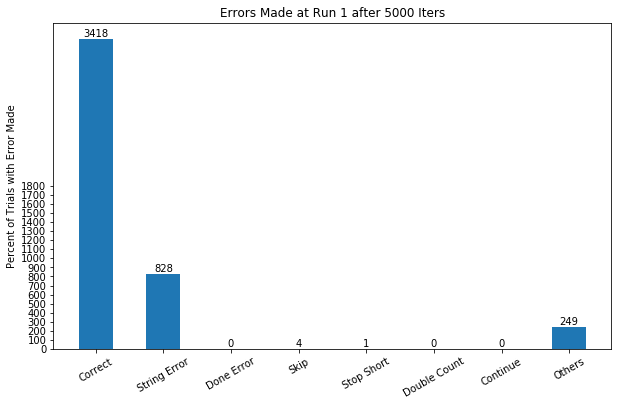

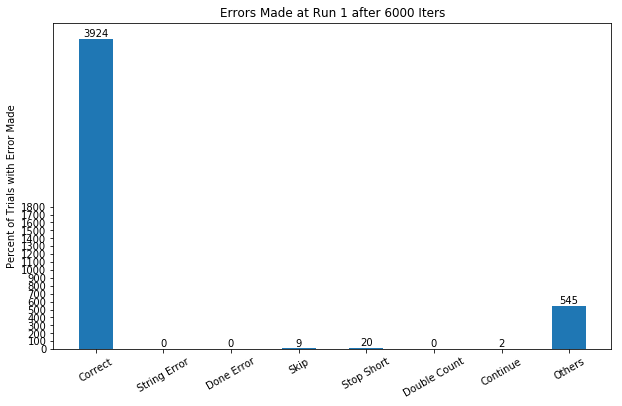

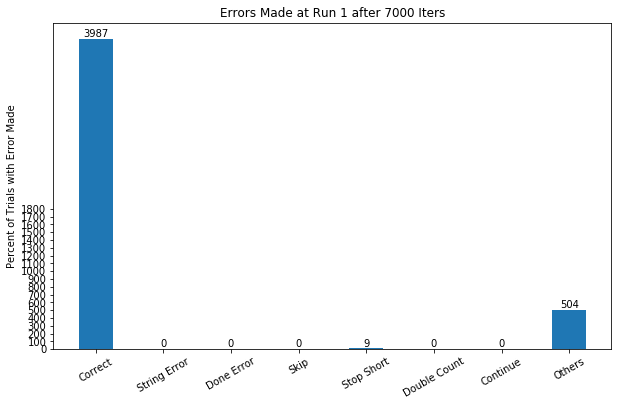

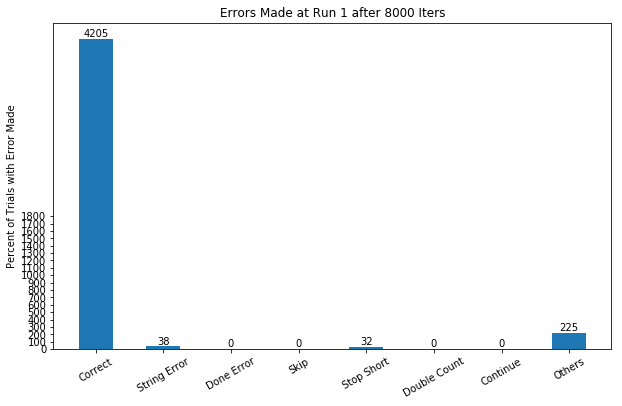

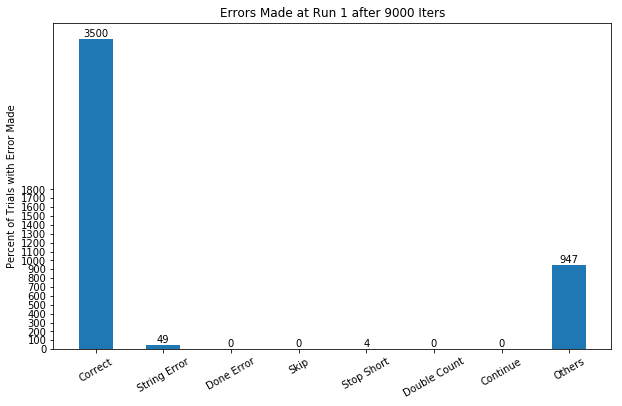

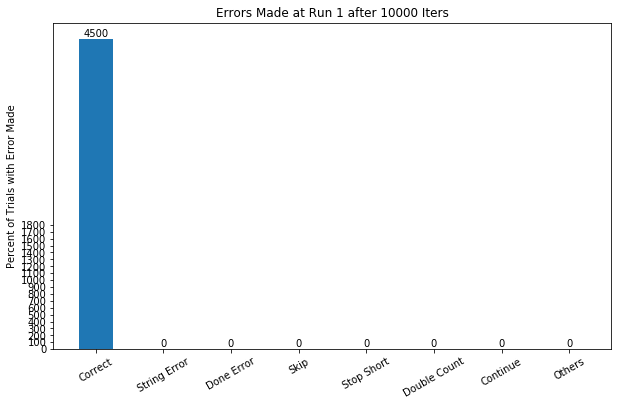

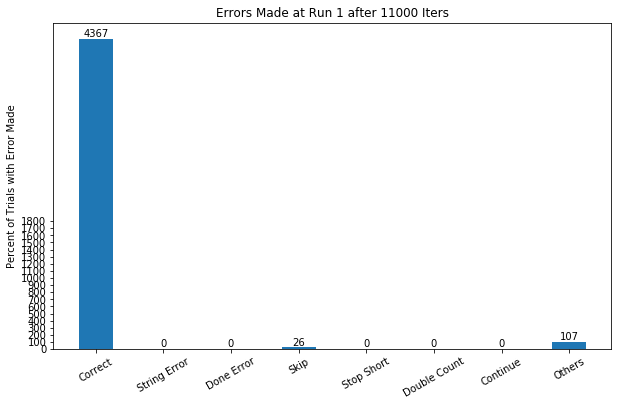

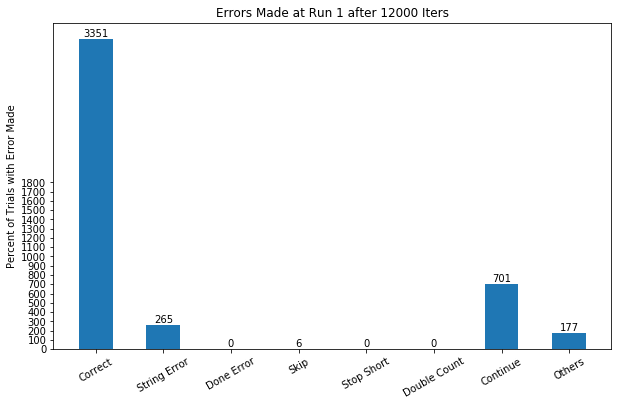

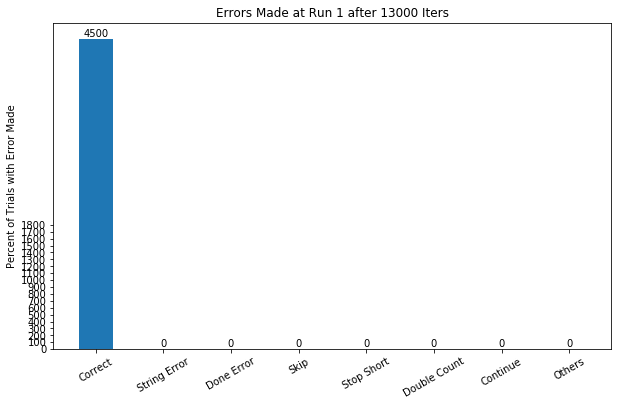

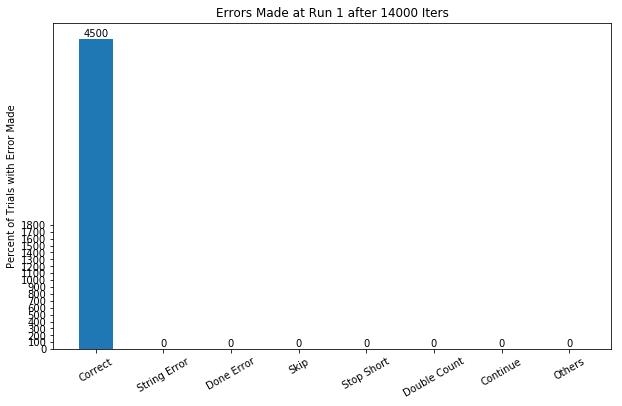

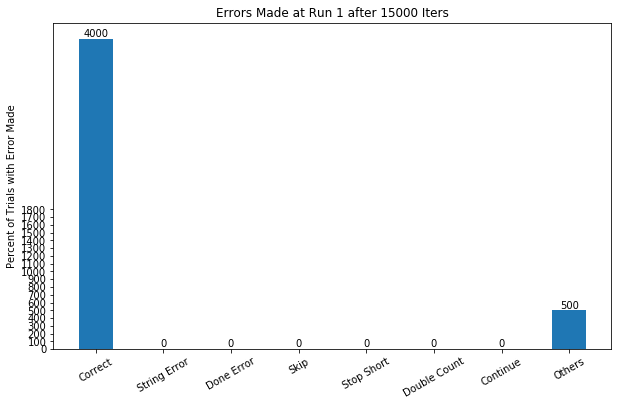

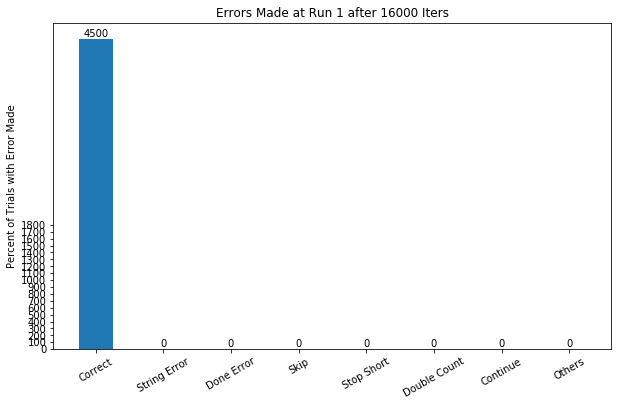

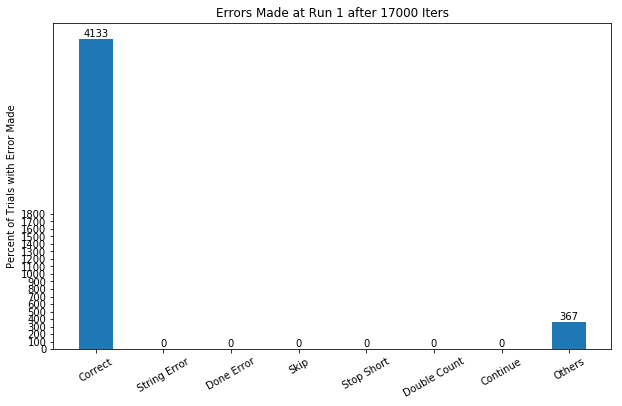

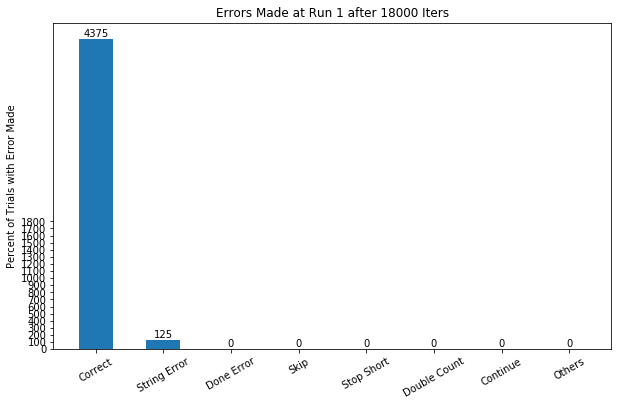

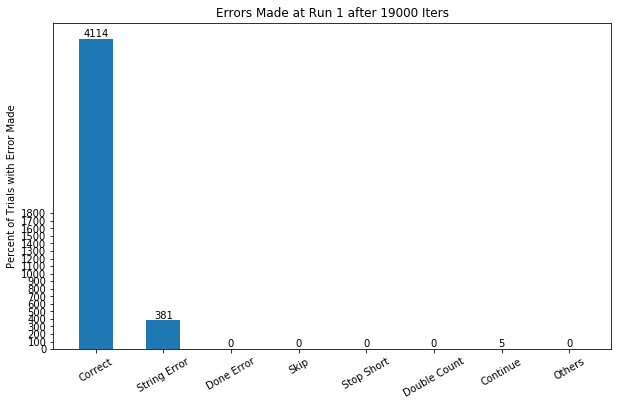

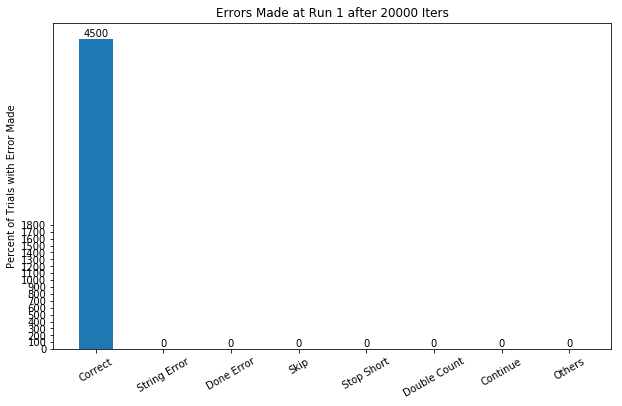

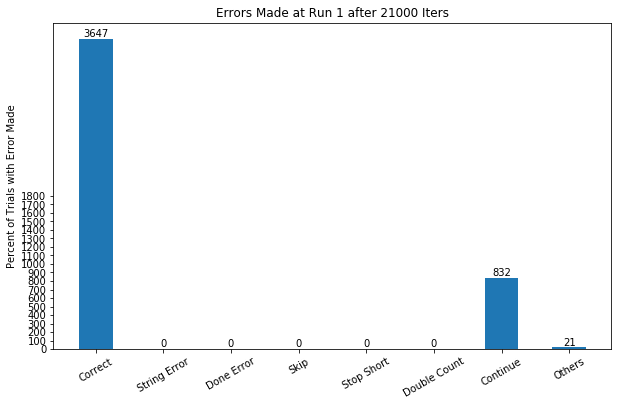

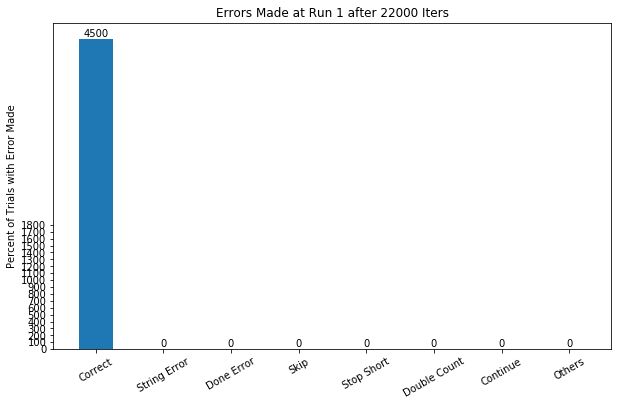

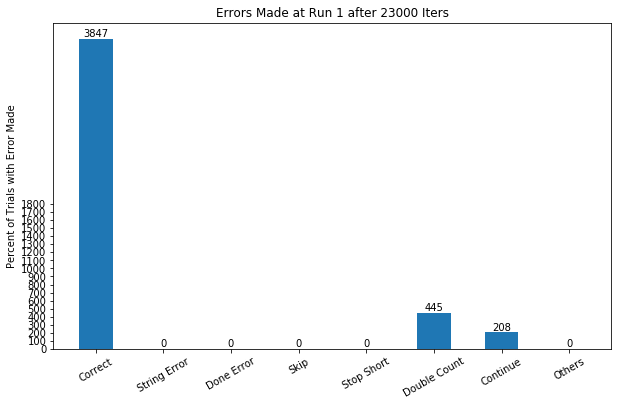

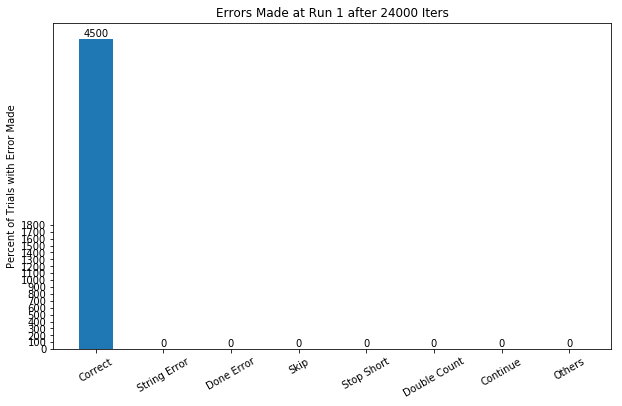

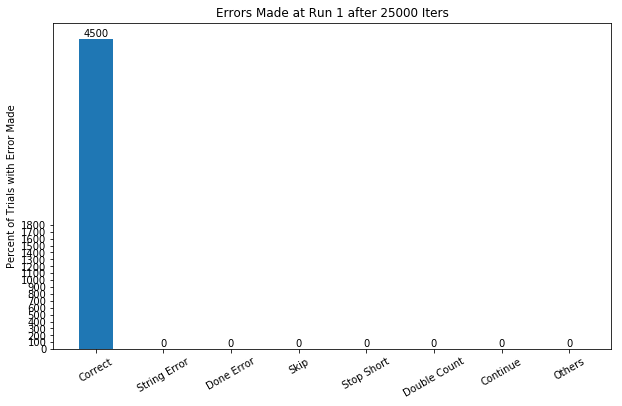

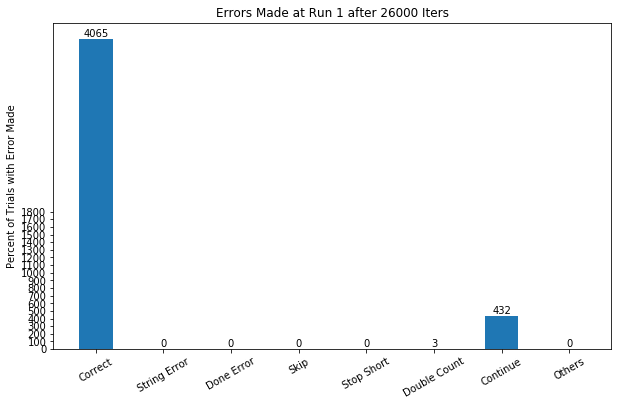

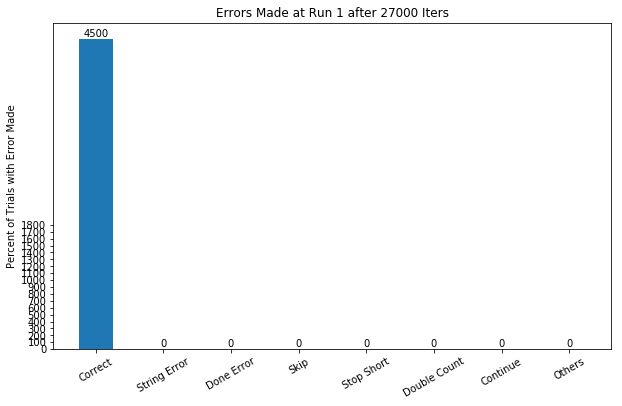

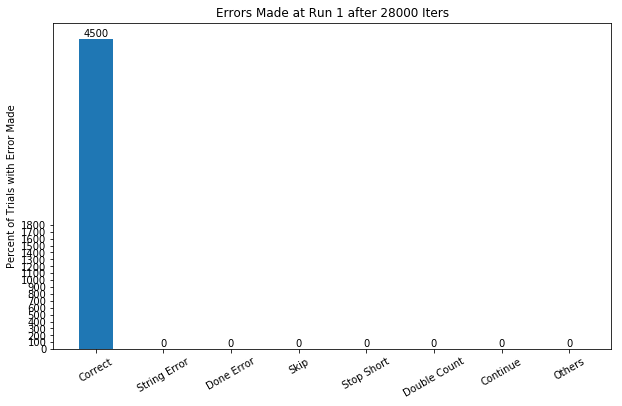

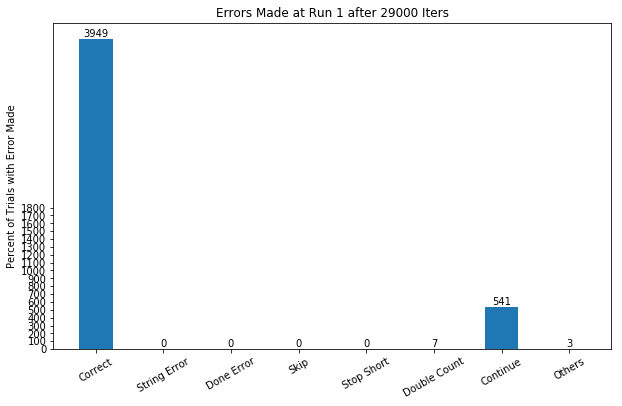

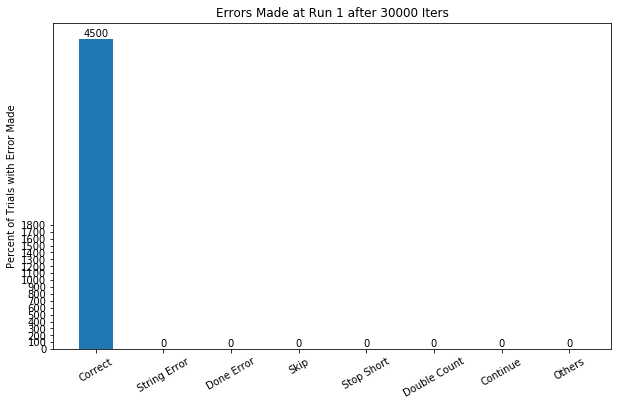

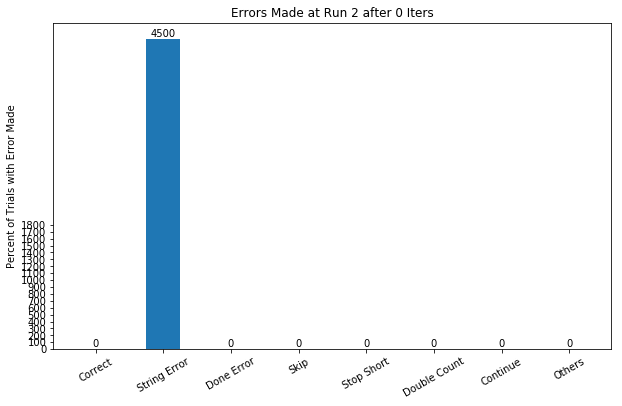

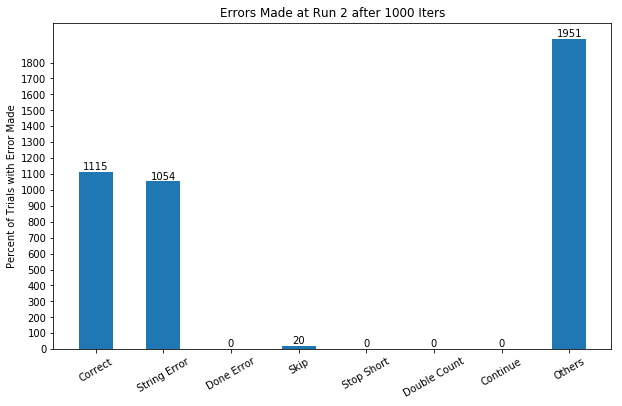

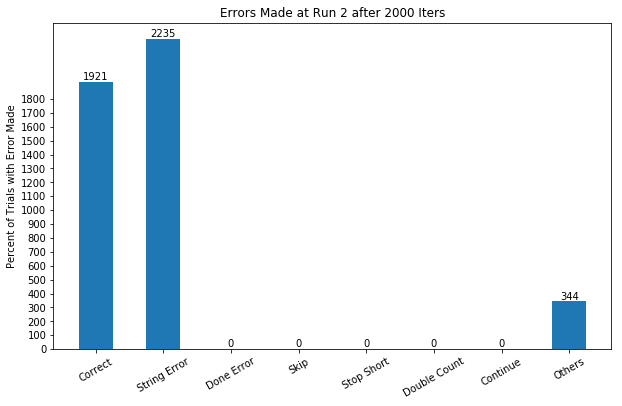

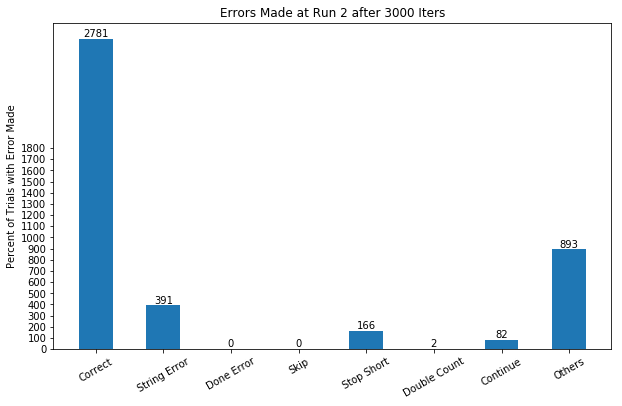

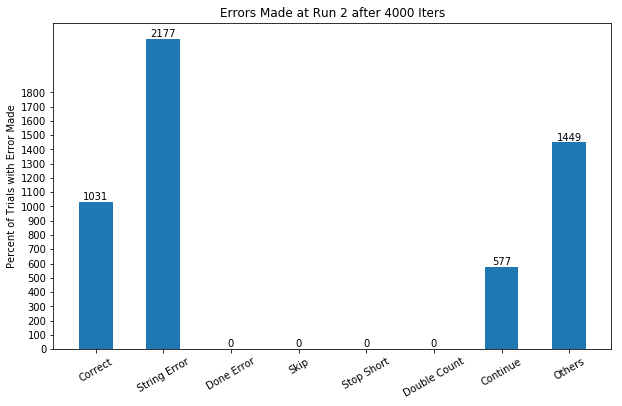

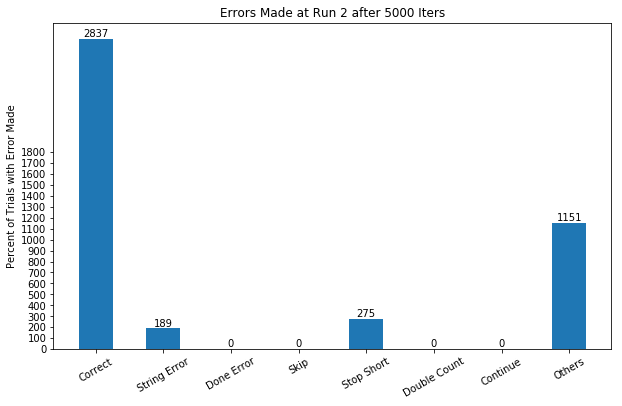

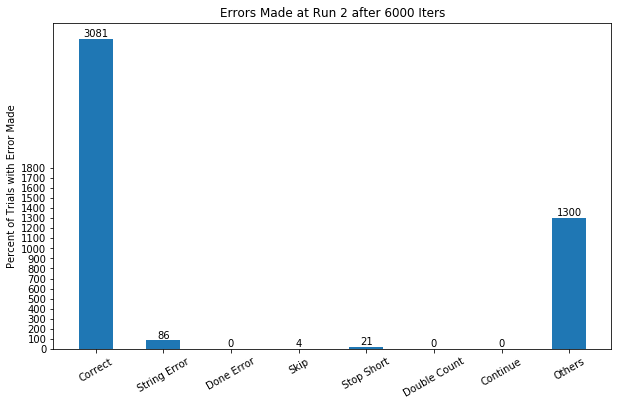

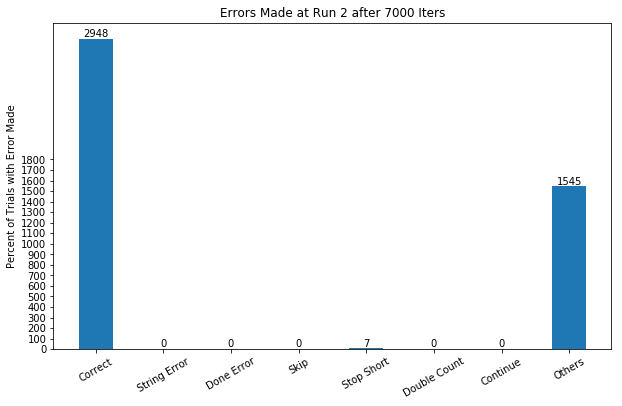

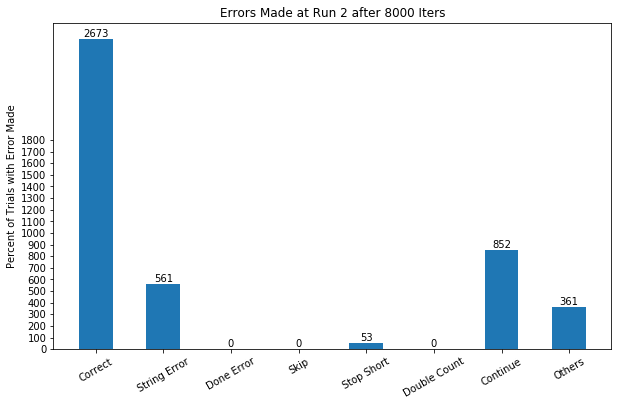

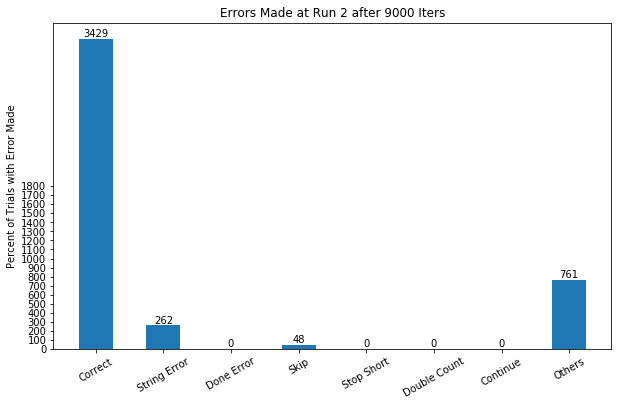

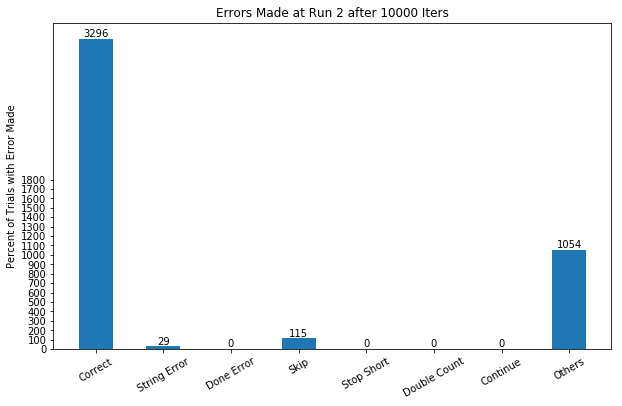

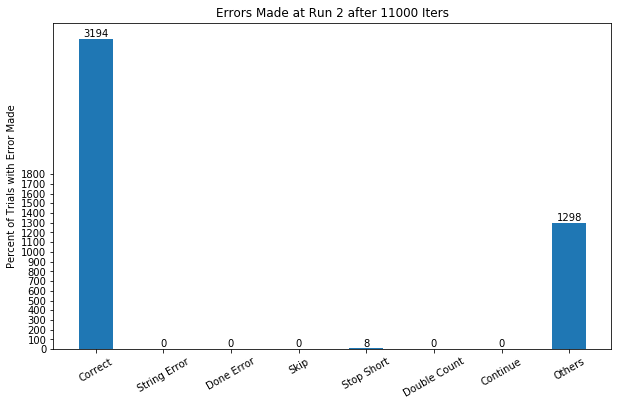

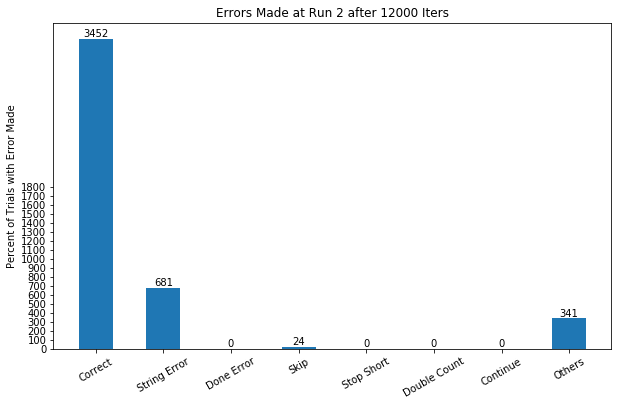

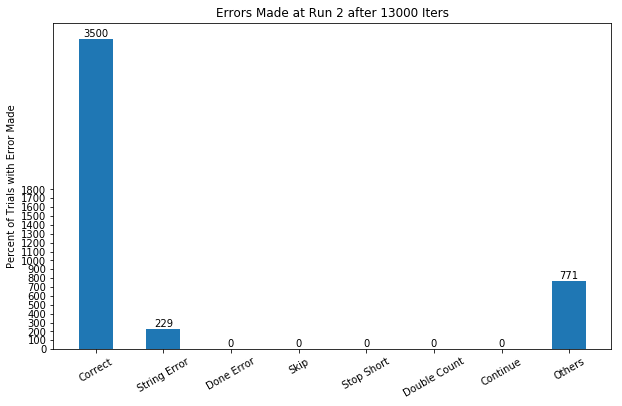

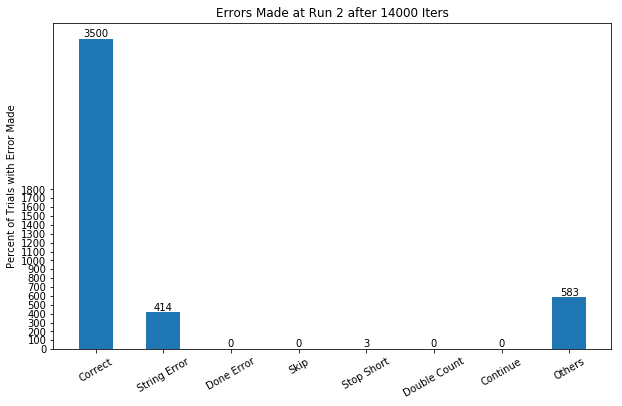

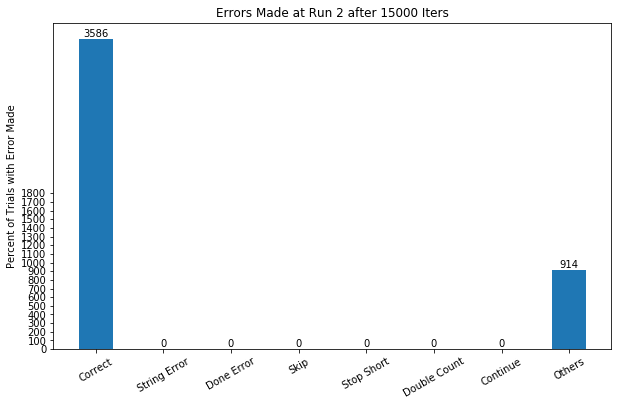

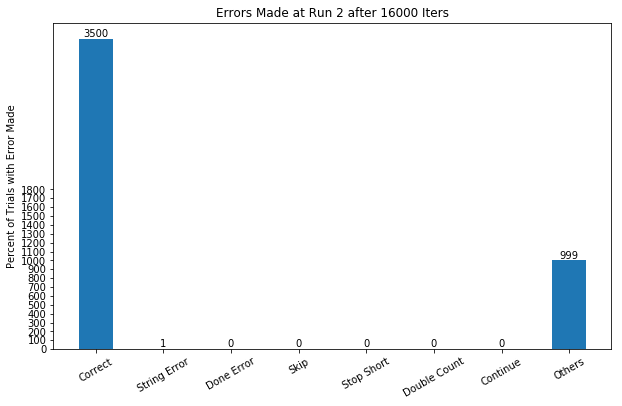

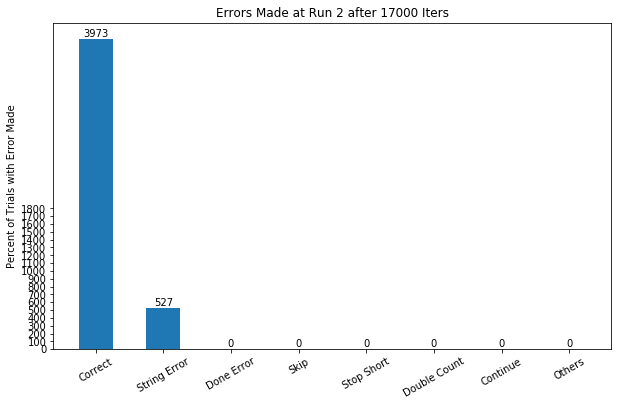

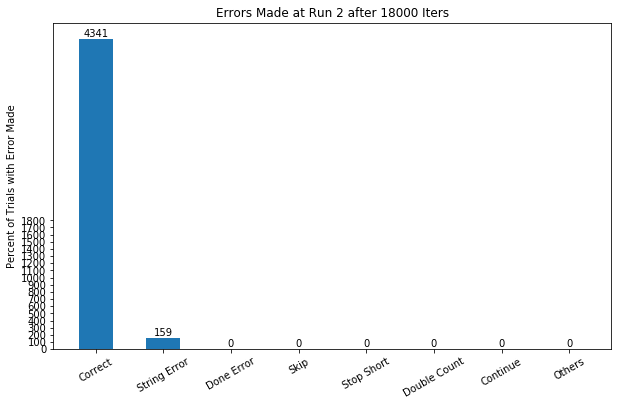

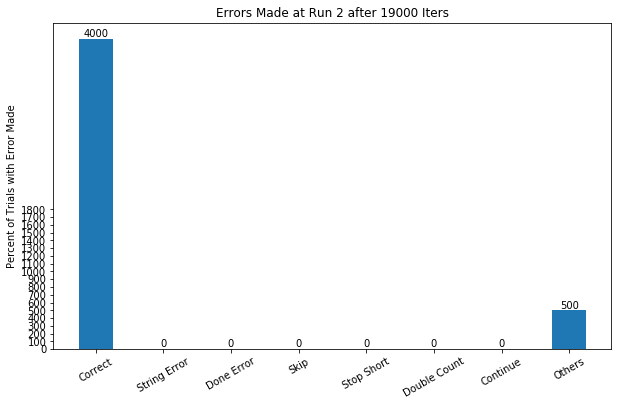

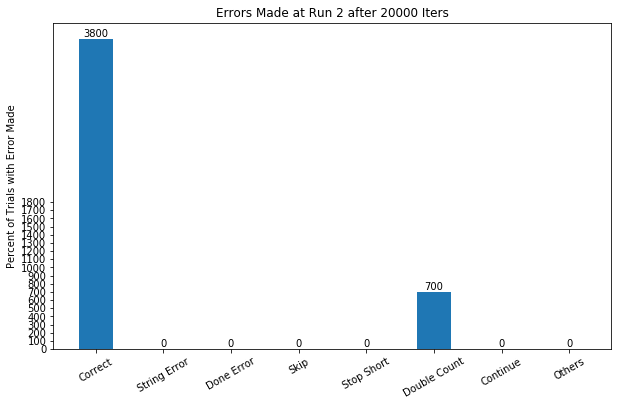

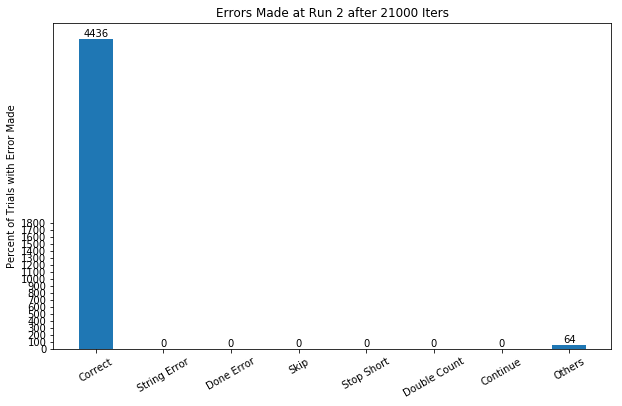

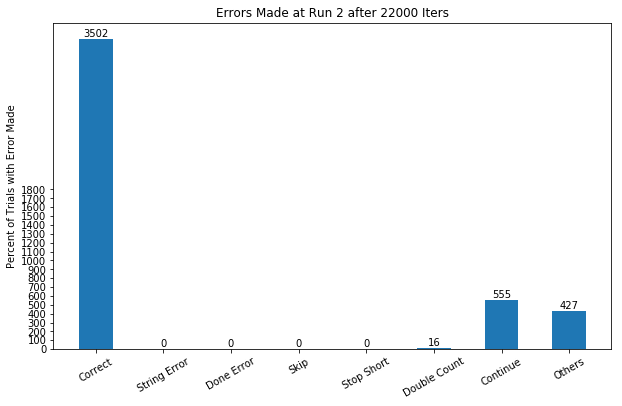

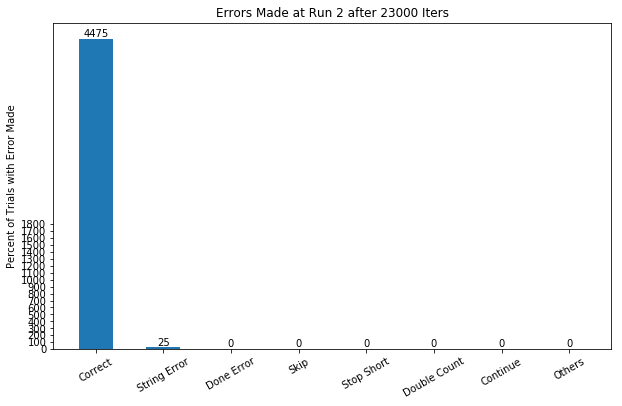

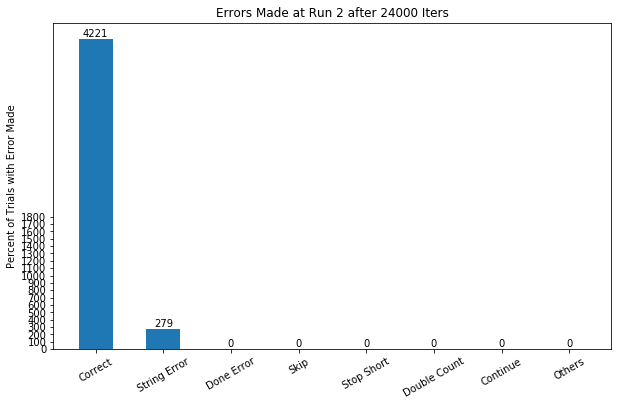

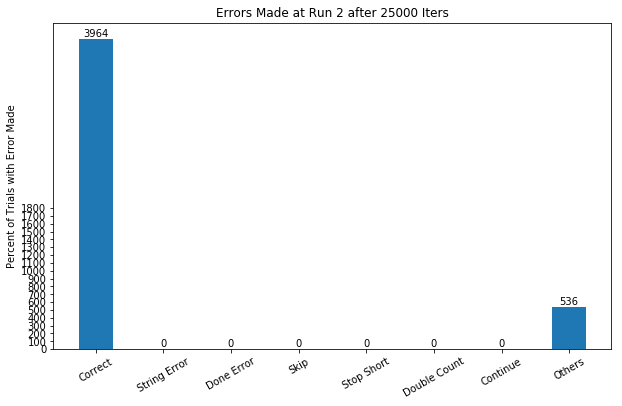

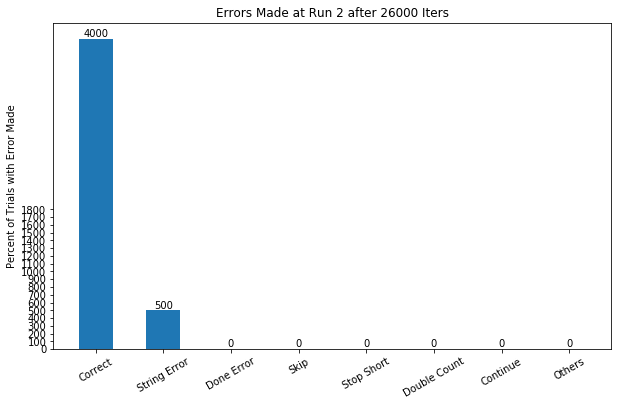

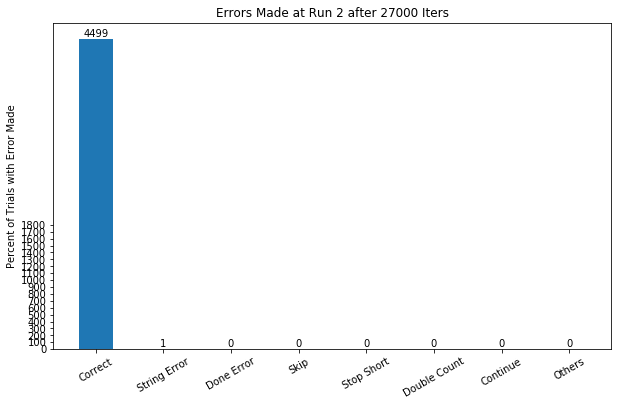

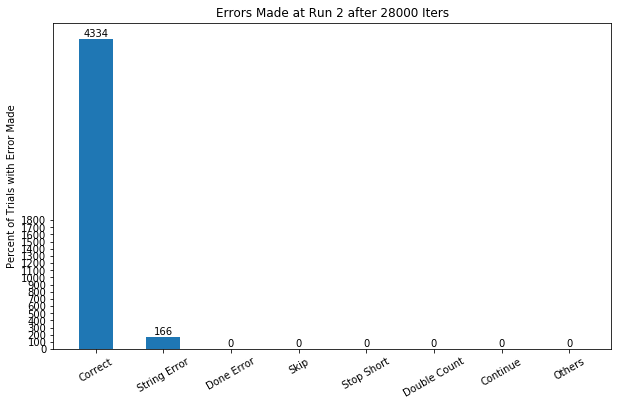

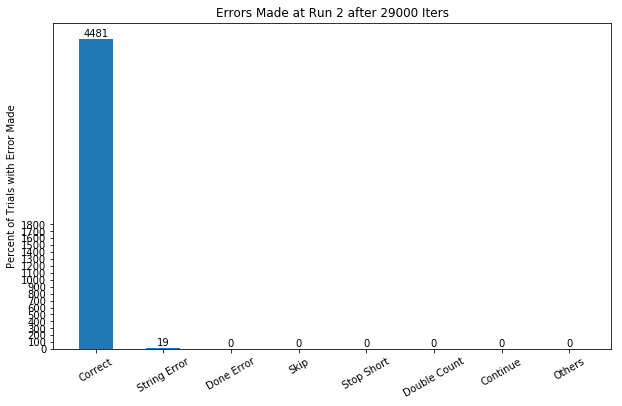

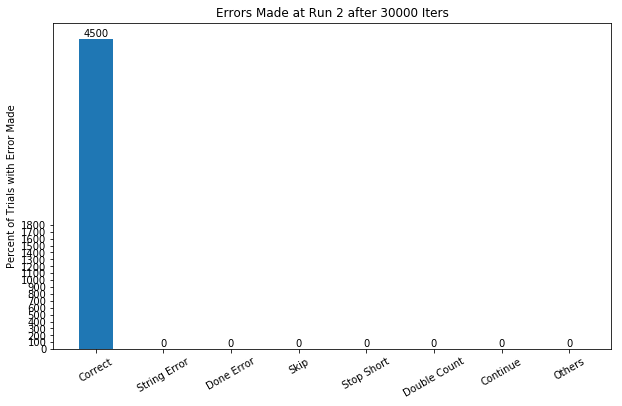

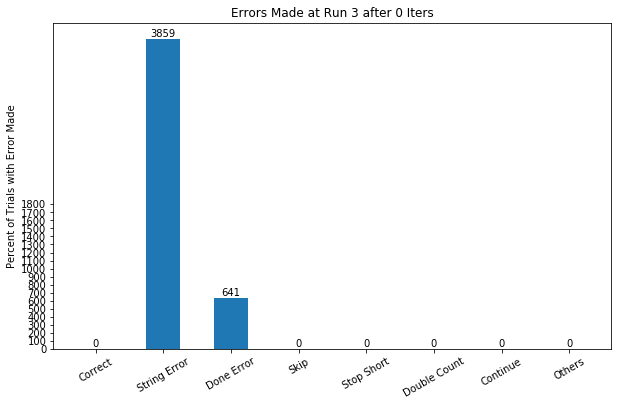

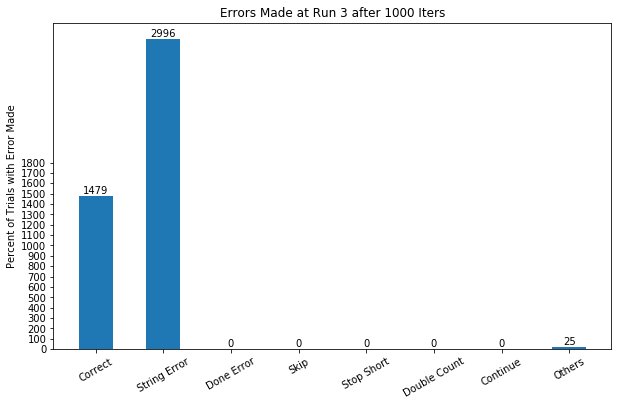

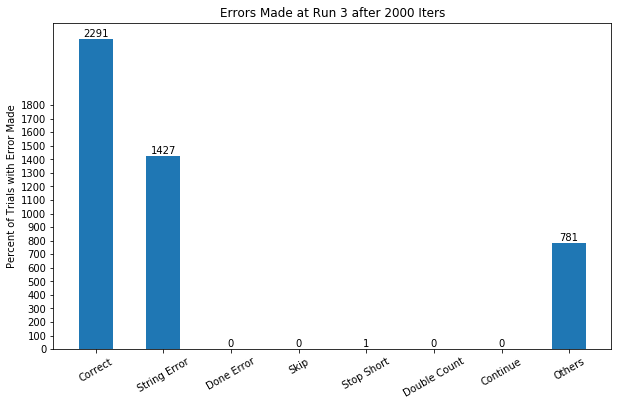

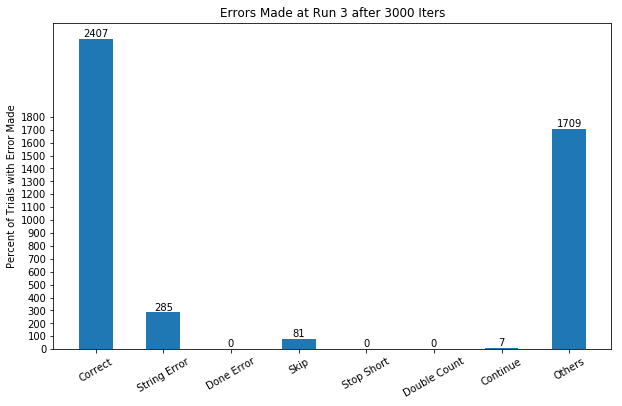

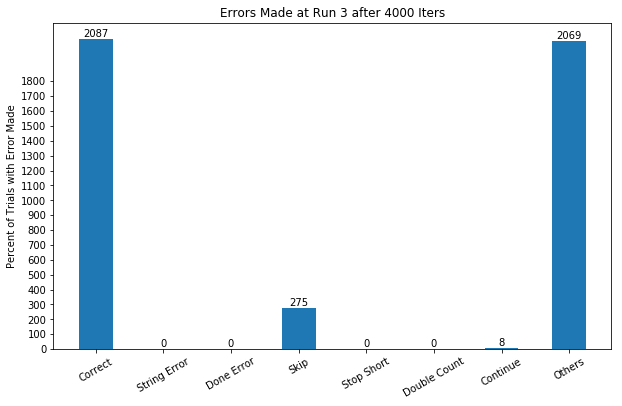

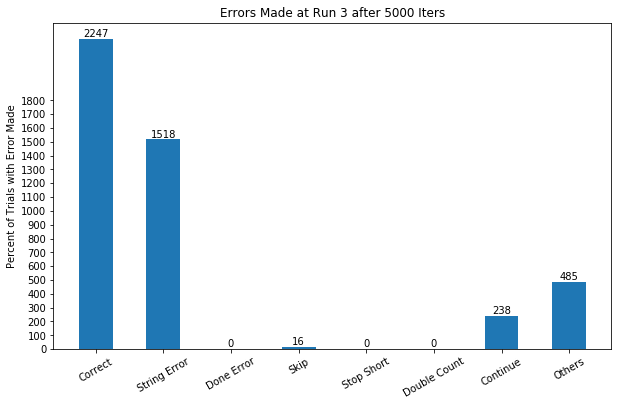

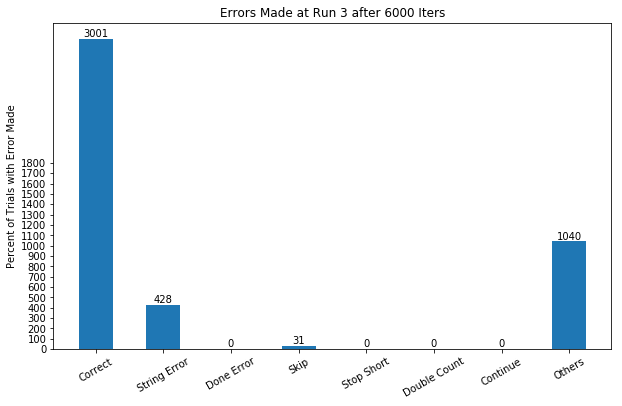

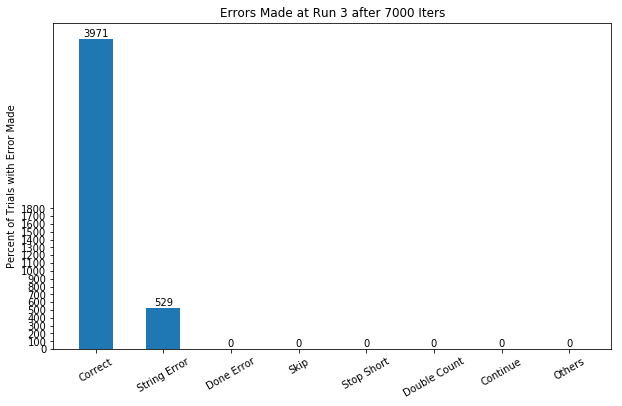

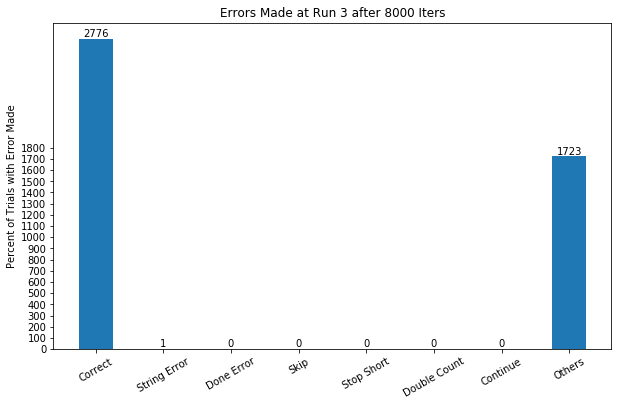

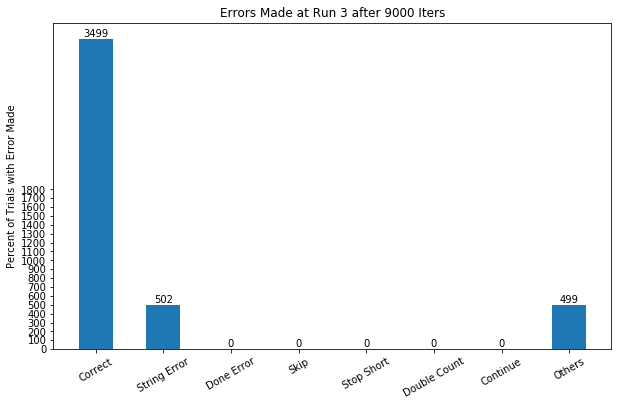

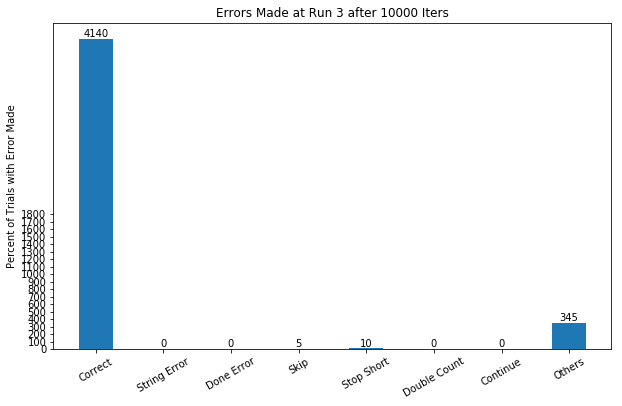

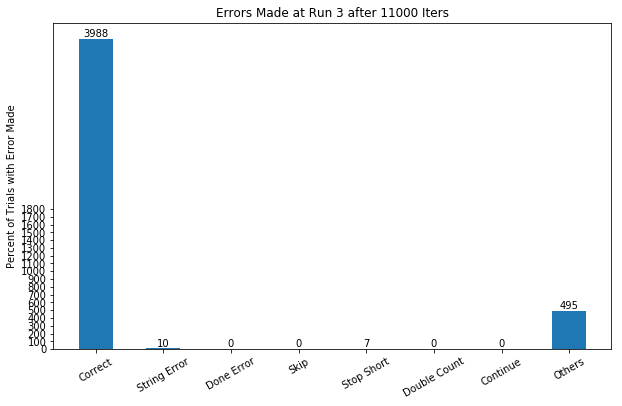

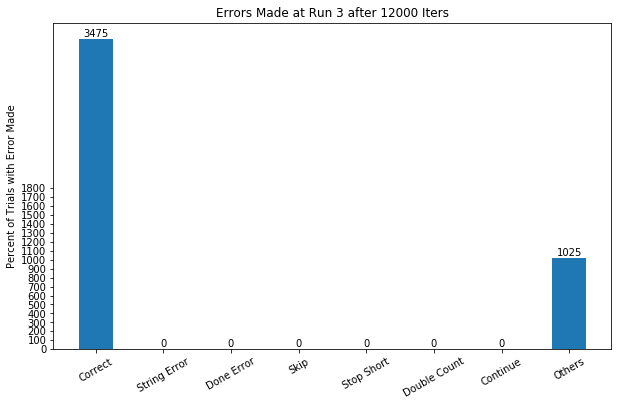

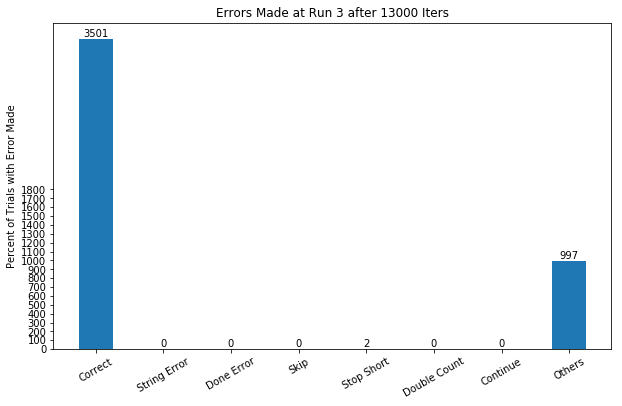

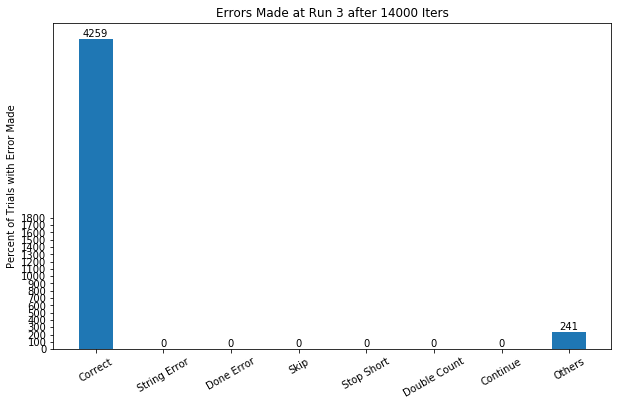

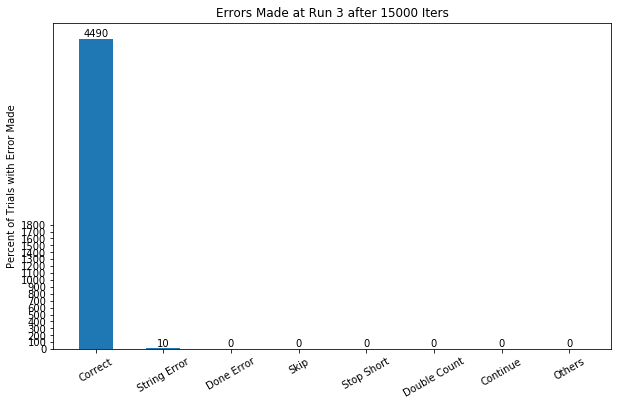

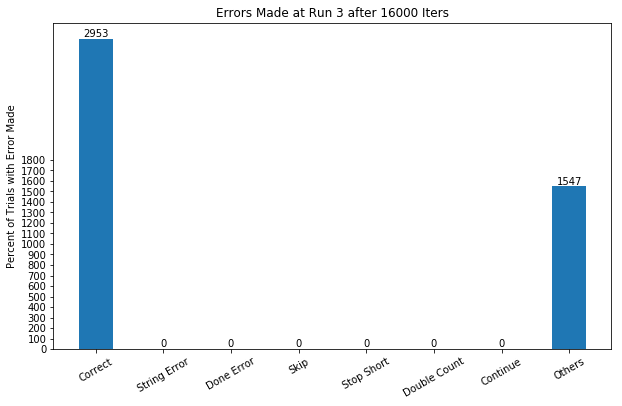

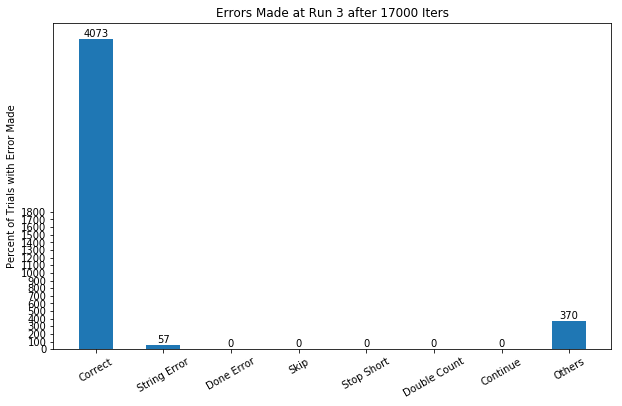

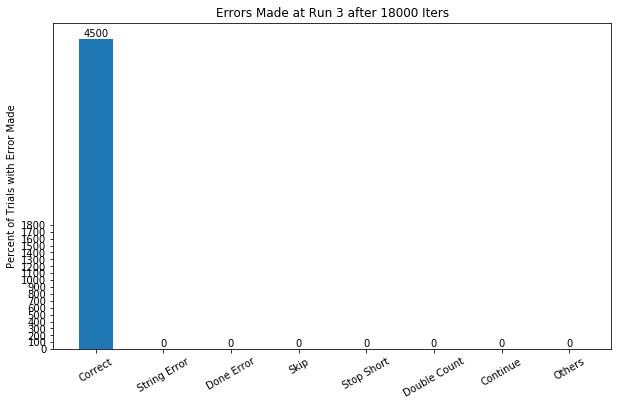

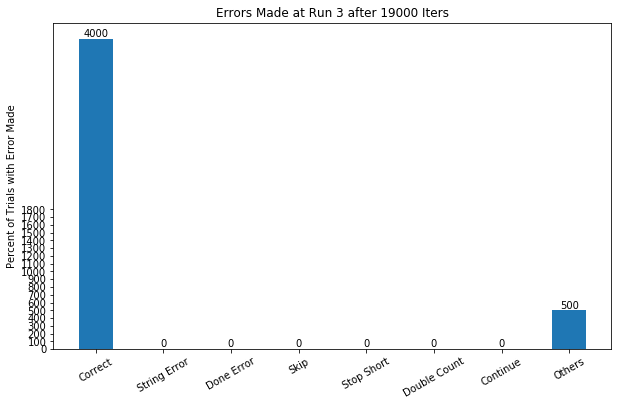

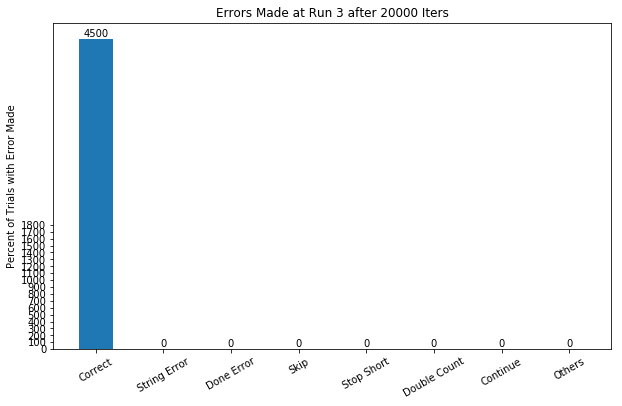

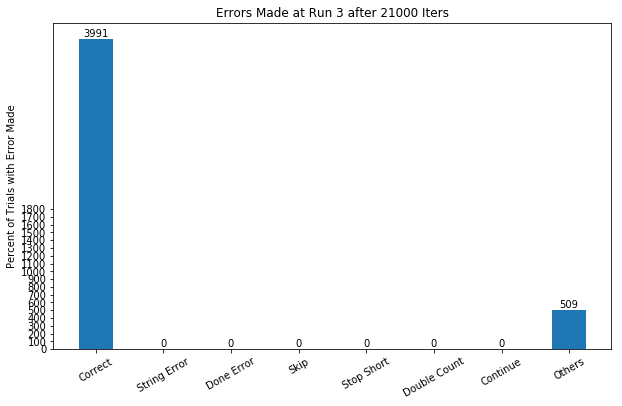

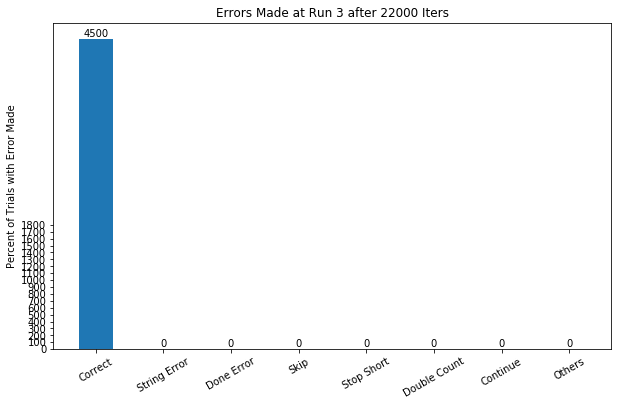

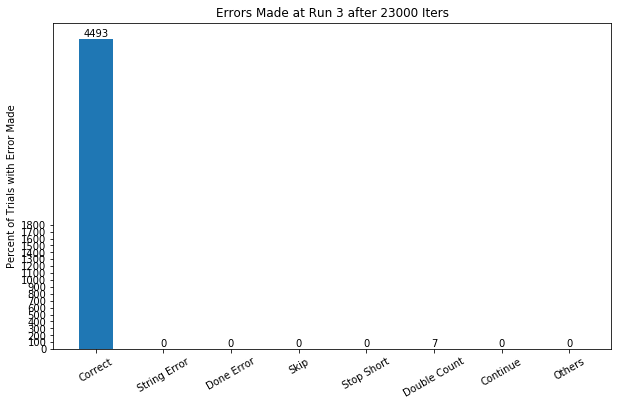

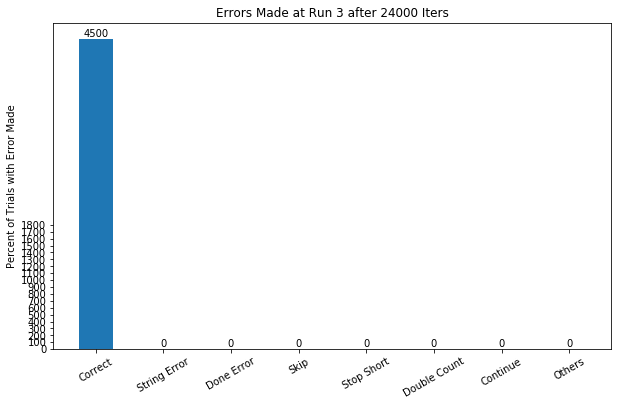

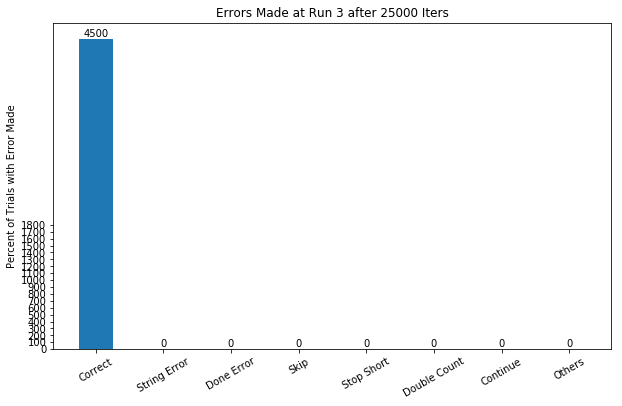

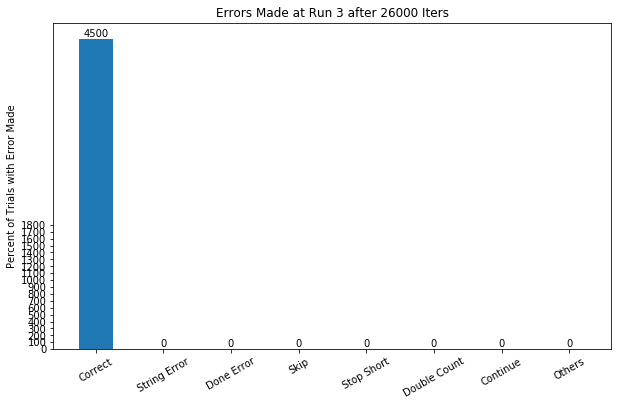

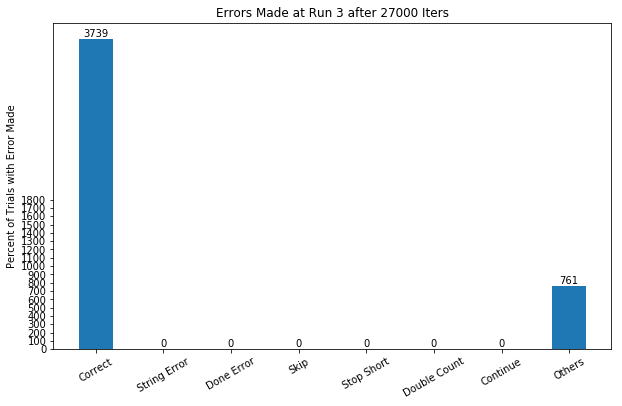

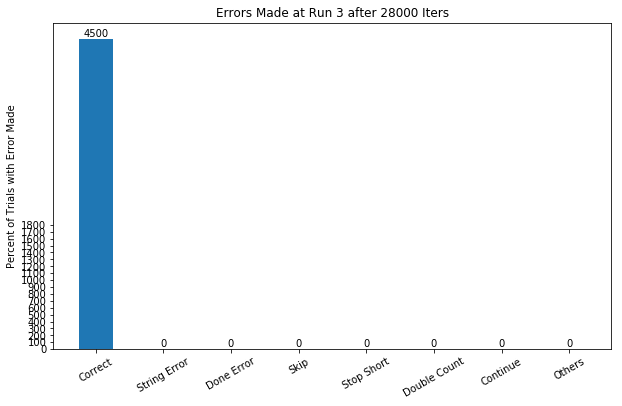

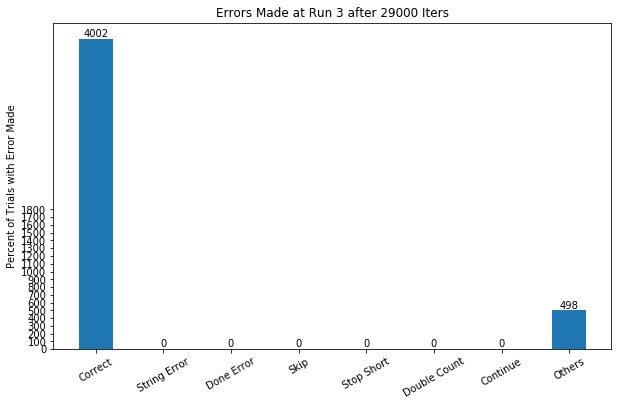

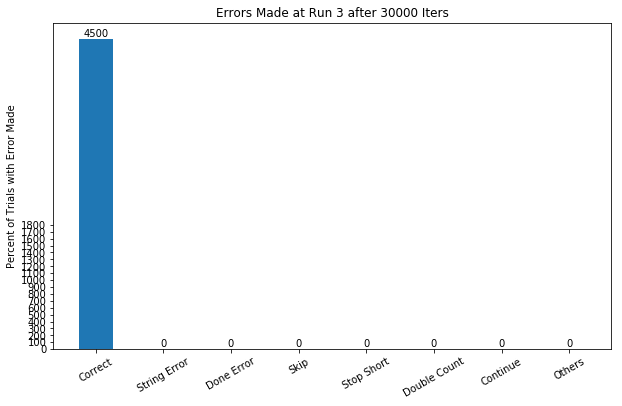

In [30]:
for run in range(num_runs):
    for it in range(num_iters):
        plot_error(run,it)

In [31]:
def plot_error_percent(run, it):
    """Plot the error categories."""
    N = 8
    ind = np.arange(N)    # the x locations for the groups
    width = 0.5       # the width of the bars: can also be len(x) sequence

    p = plt.bar(ind, error[run, it]/num_imgs, width)
    plt.ylabel('Percent of Trials with Error Made')
    plt.title('Errors Made at Run %d after %d Iters' % (run + 1, iter_list[it]))
    plt.xticks(ind, ('Correct', 'String Error', 'Done Error', 'Skip', 'Stop Short', 'Double Count', 'Continue', 'Others'), rotation=30)
    plt.yticks(np.arange(0, 1, 100))
    for a,b in zip(ind, error[run, it]/num_imgs):
        plt.text(a, b+0.05, '%.3f' % b, ha='center', va= 'bottom',fontsize=10)
    plt.show()

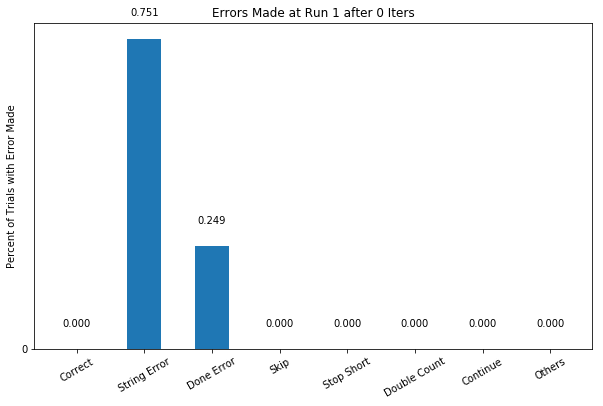

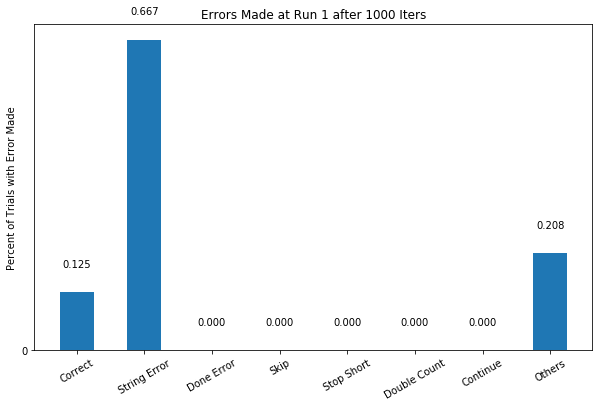

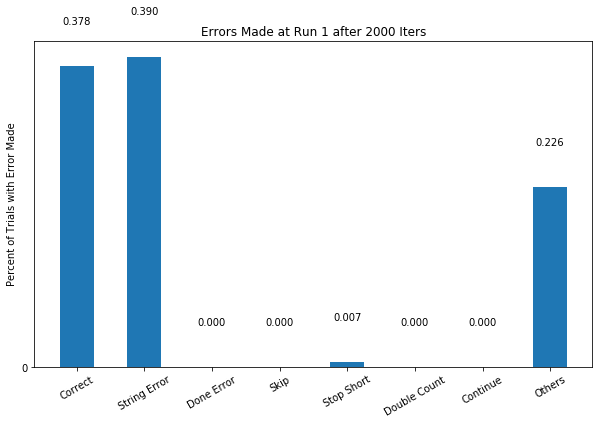

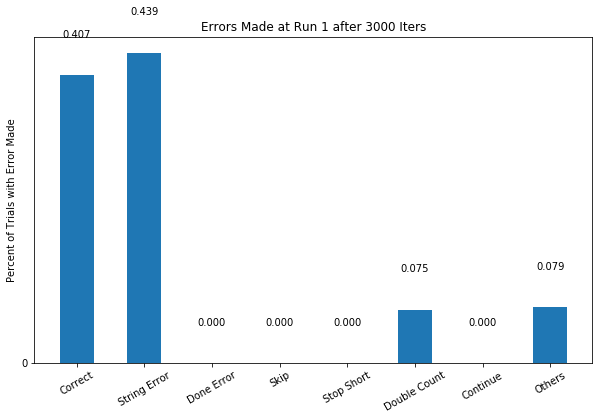

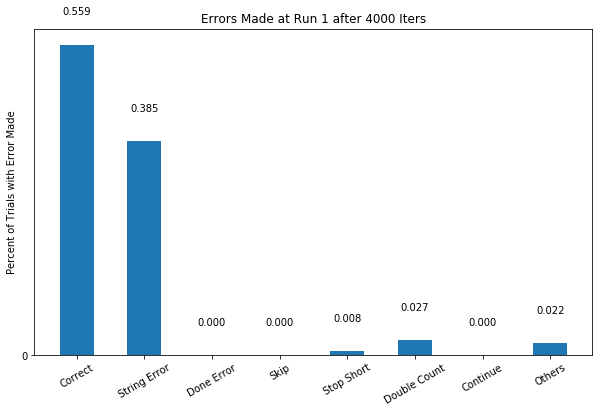

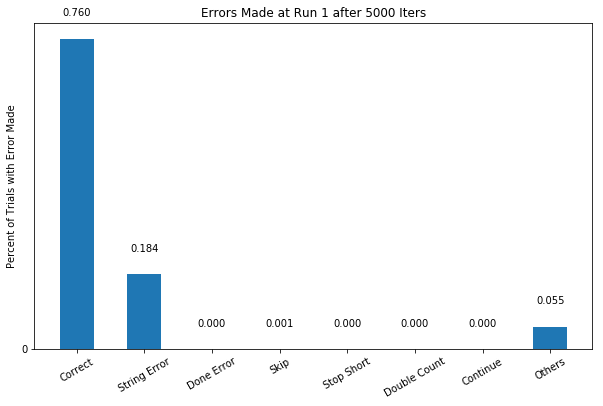

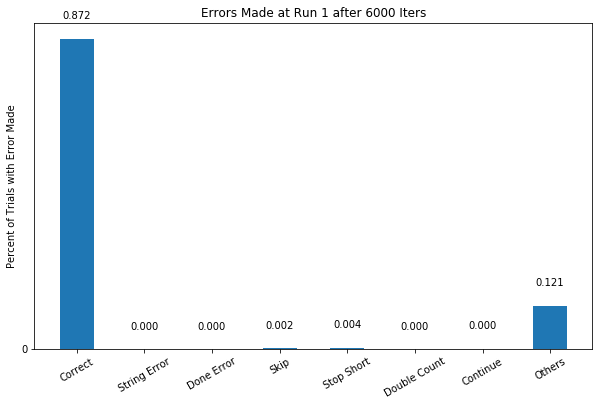

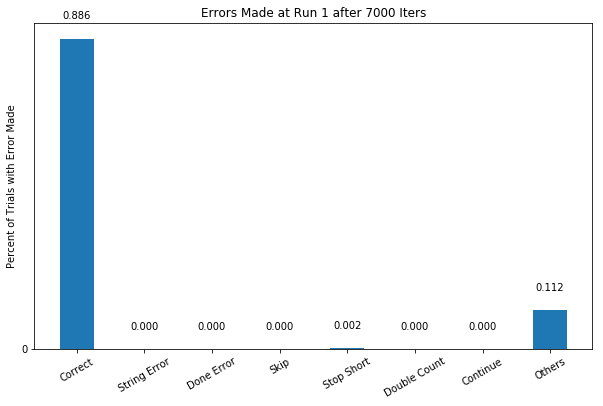

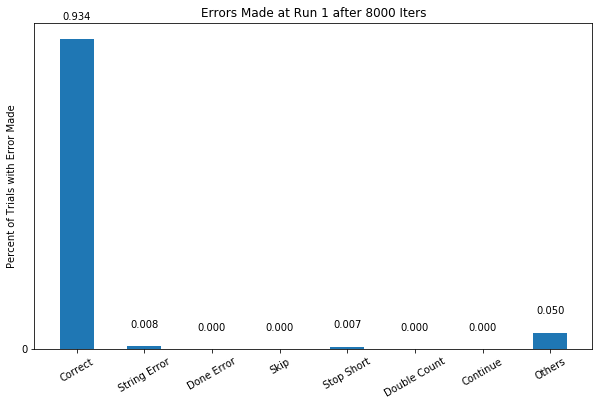

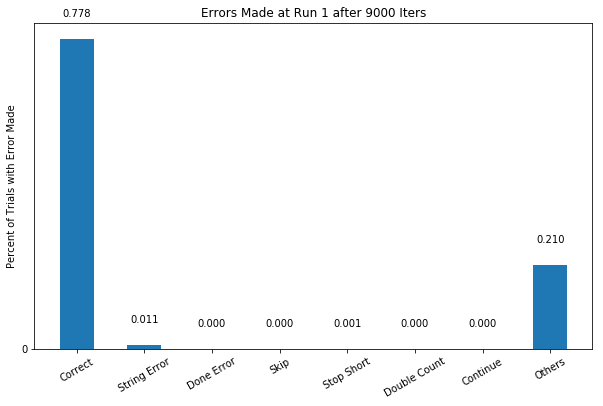

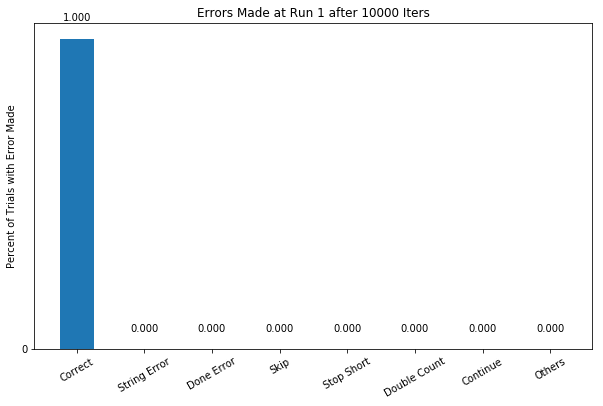

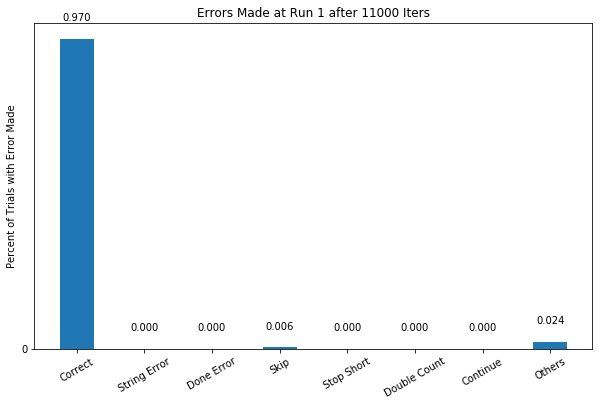

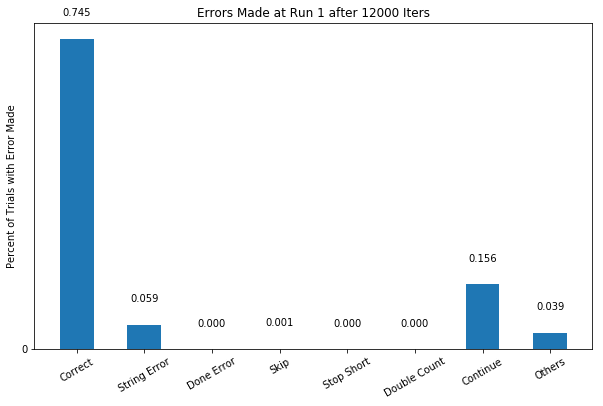

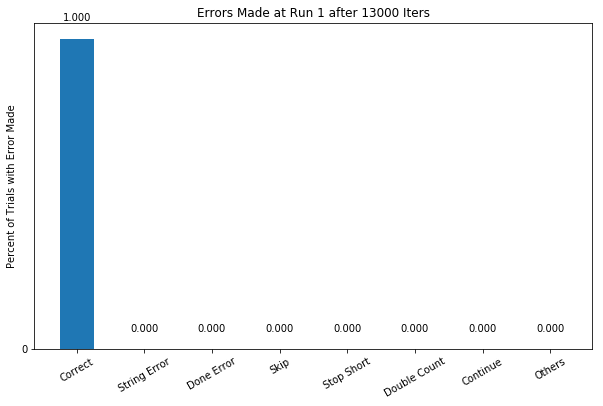

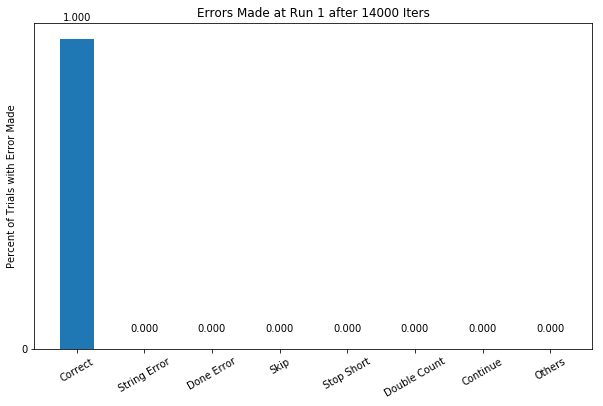

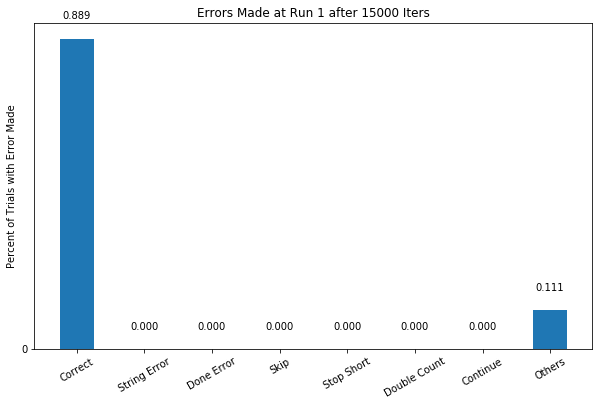

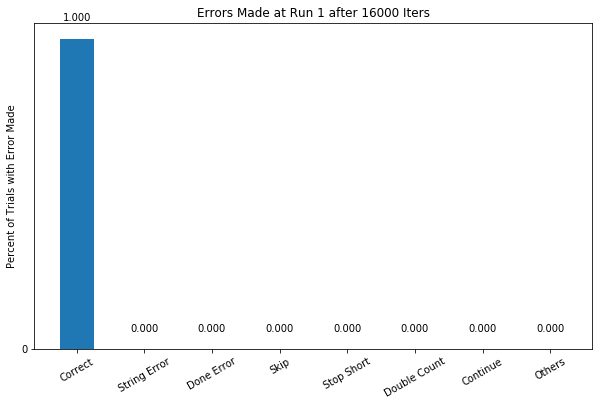

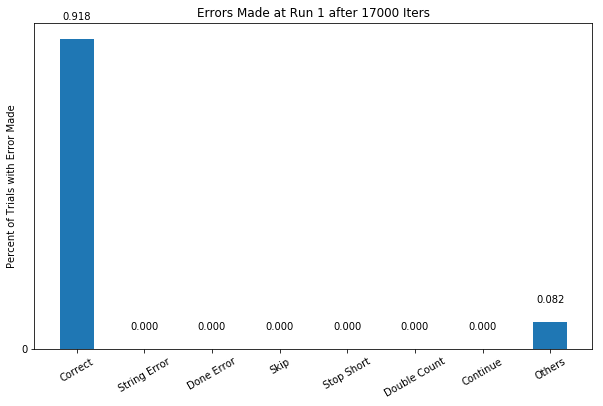

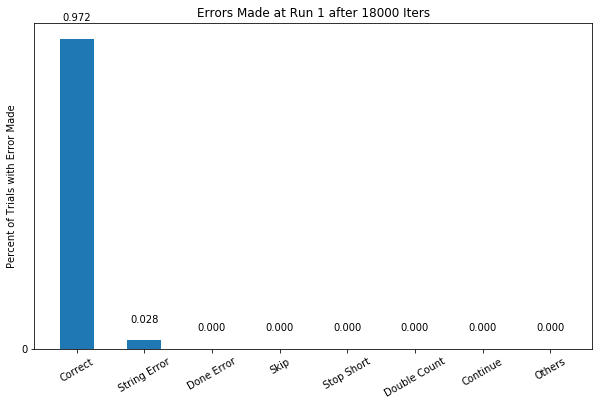

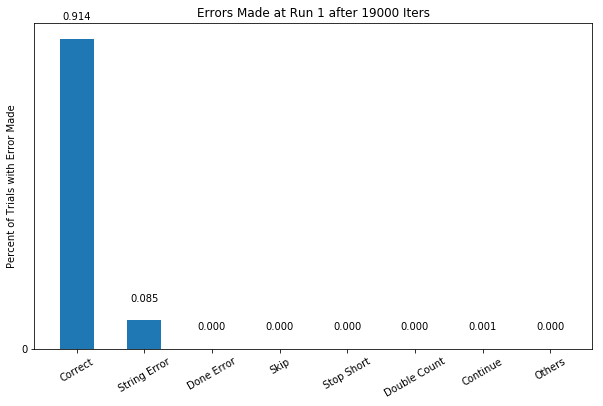

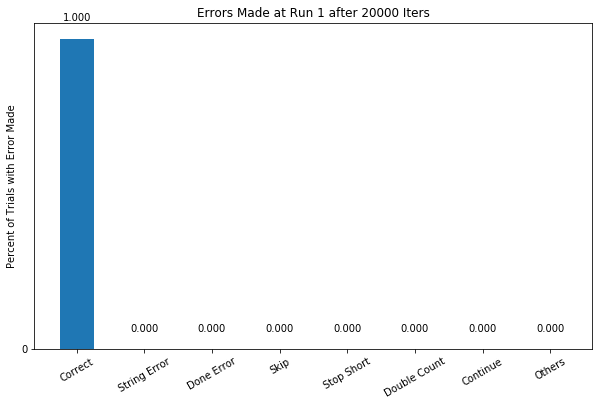

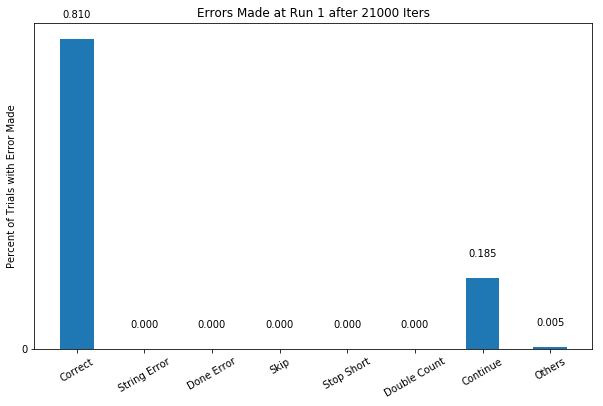

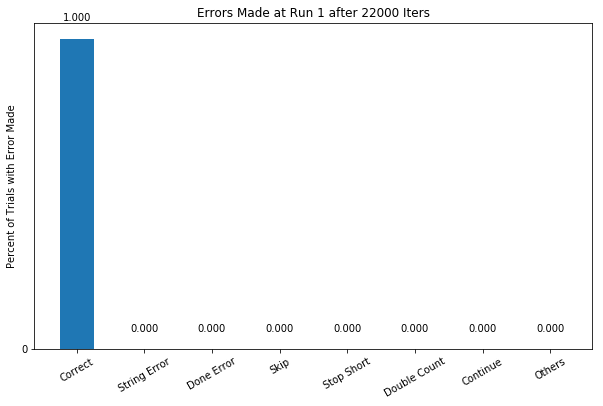

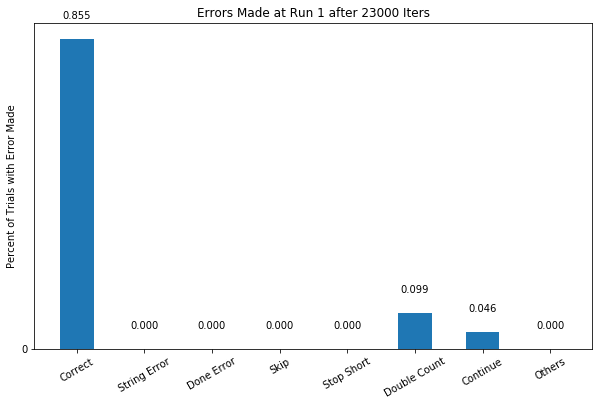

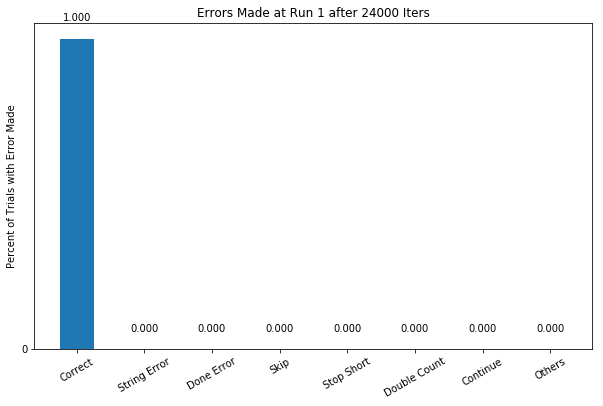

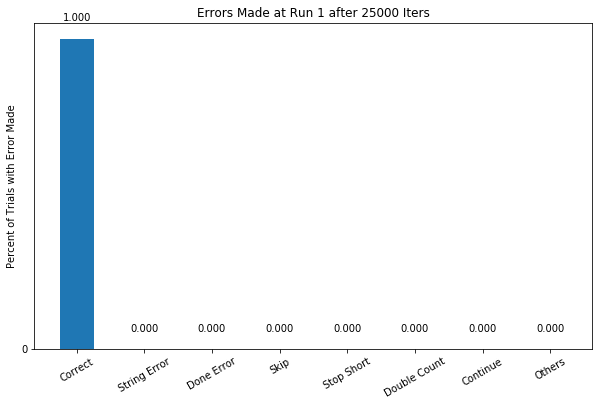

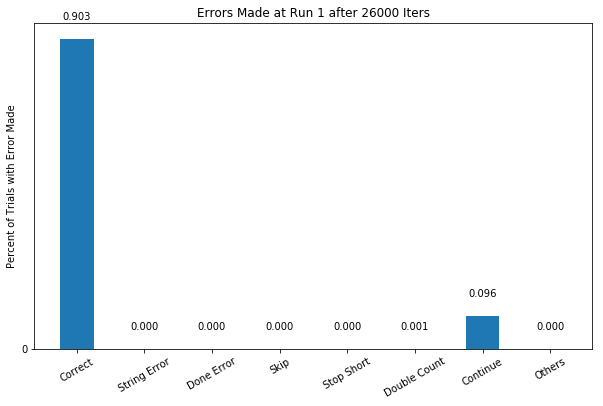

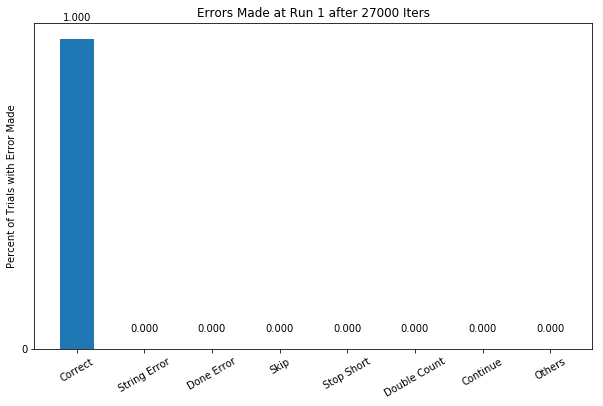

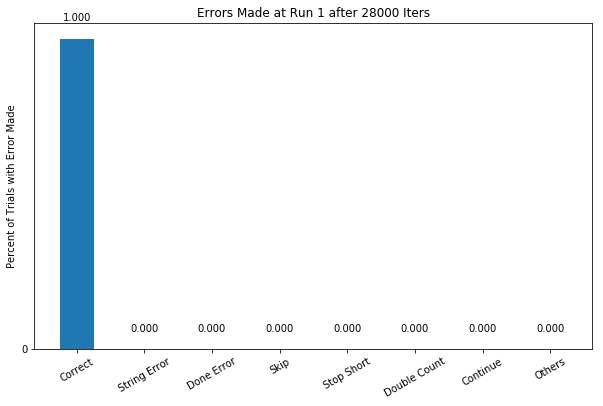

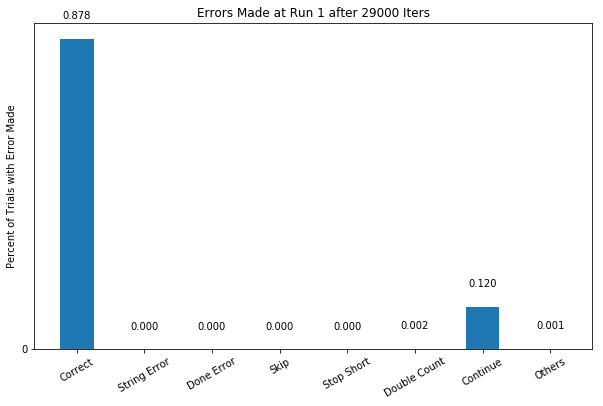

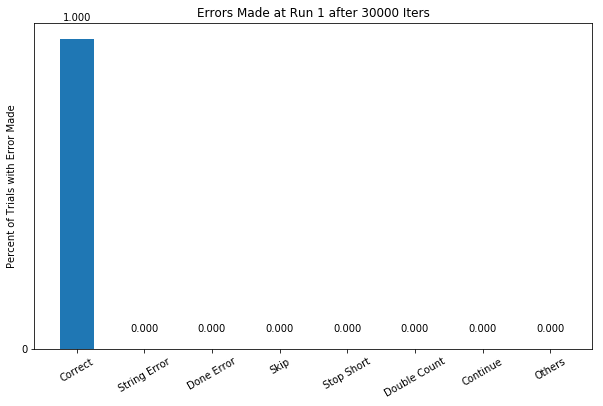

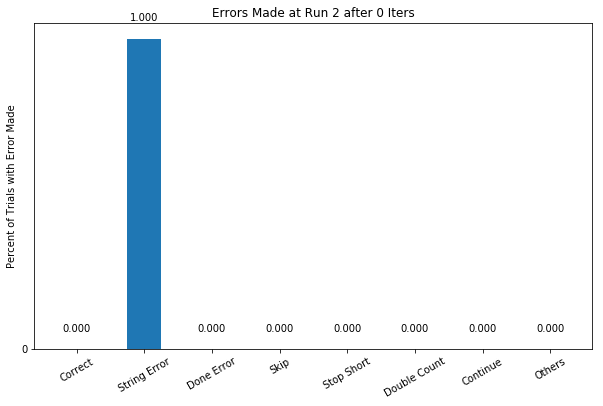

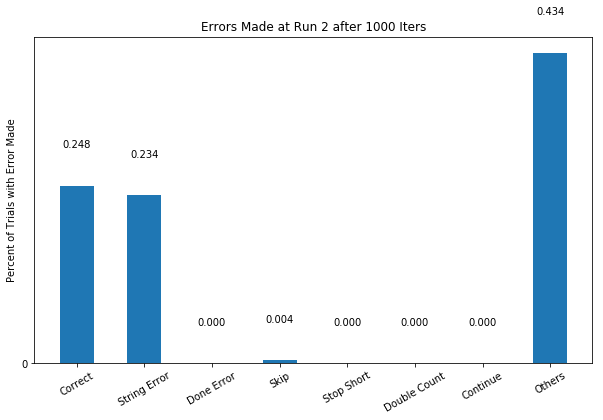

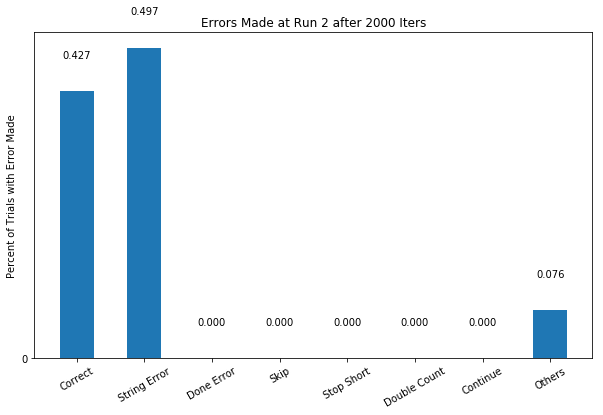

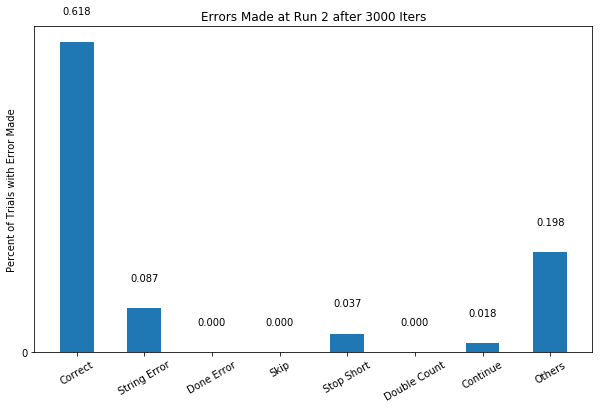

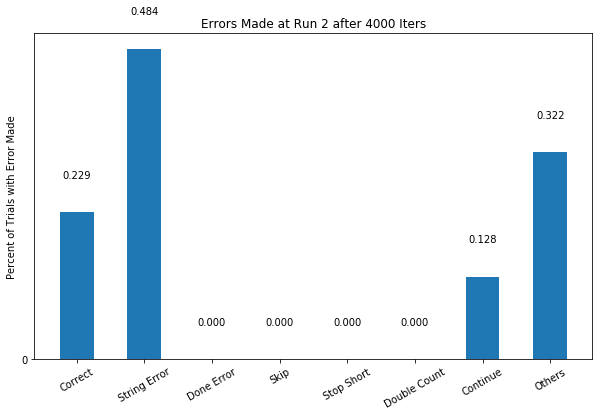

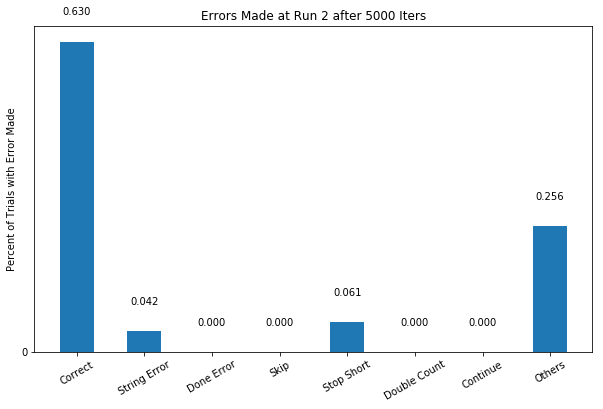

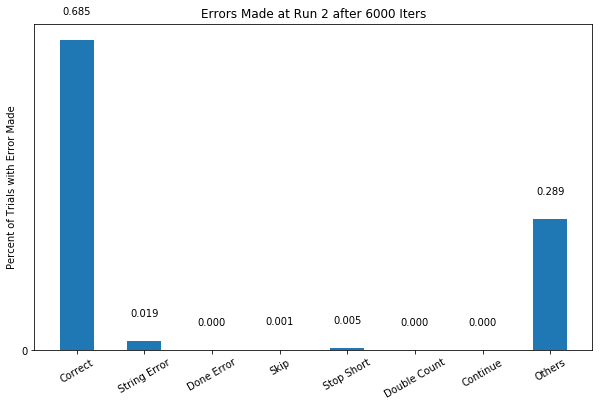

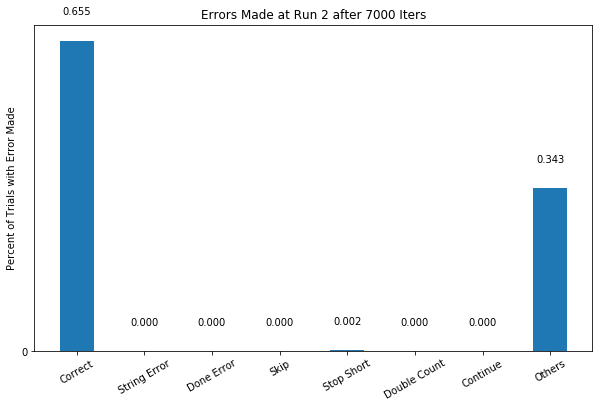

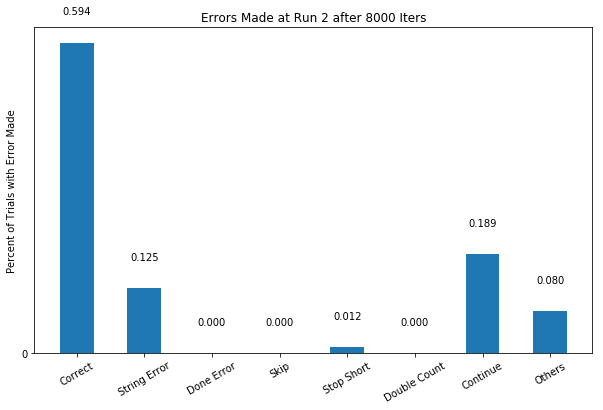

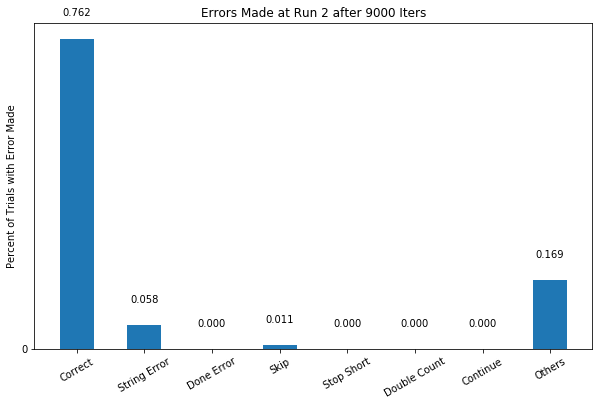

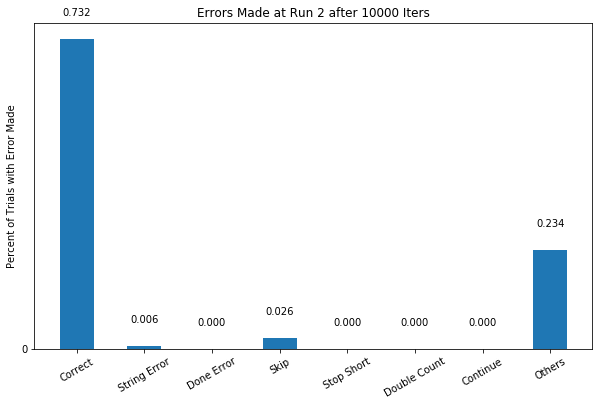

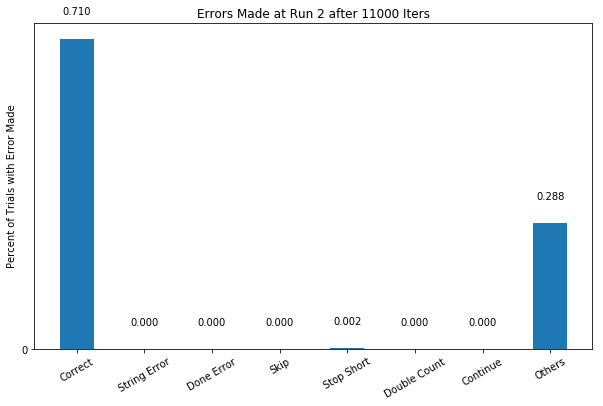

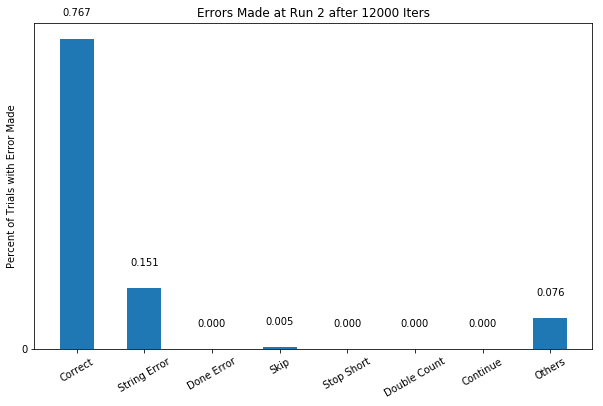

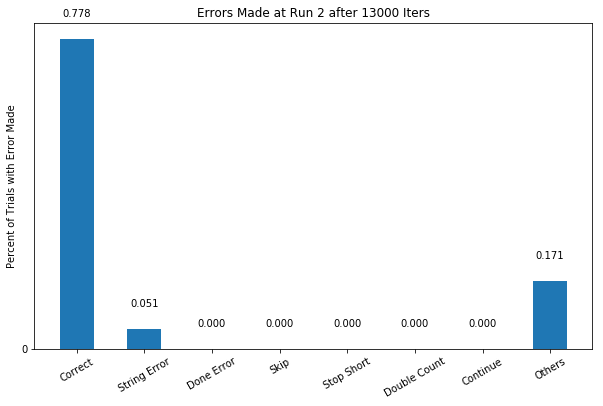

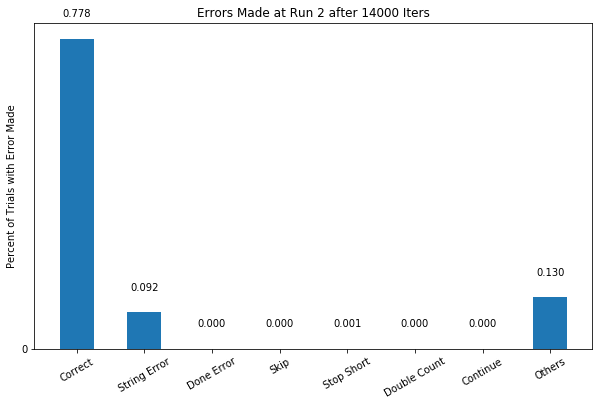

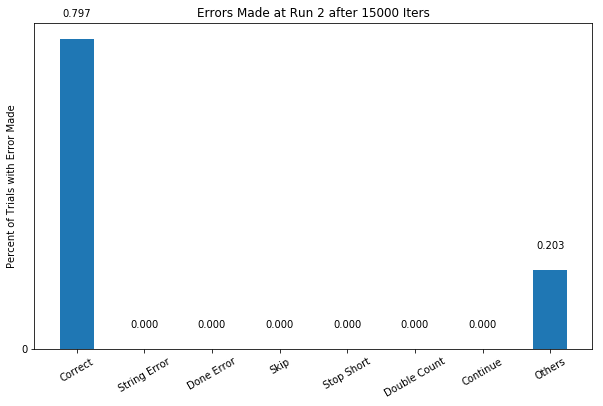

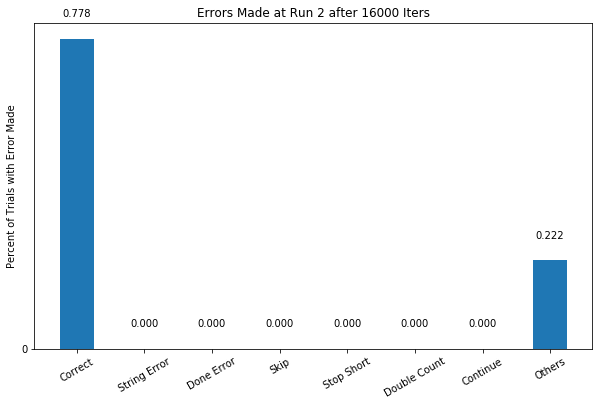

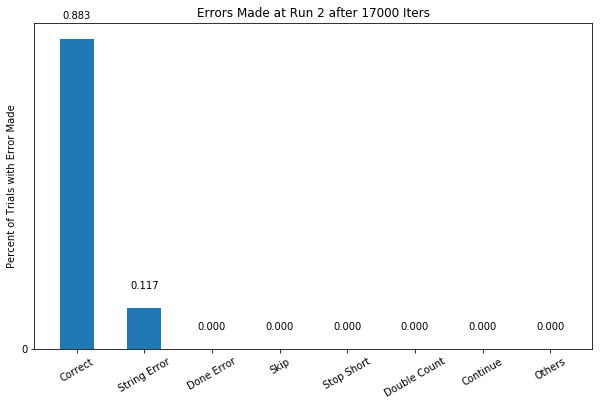

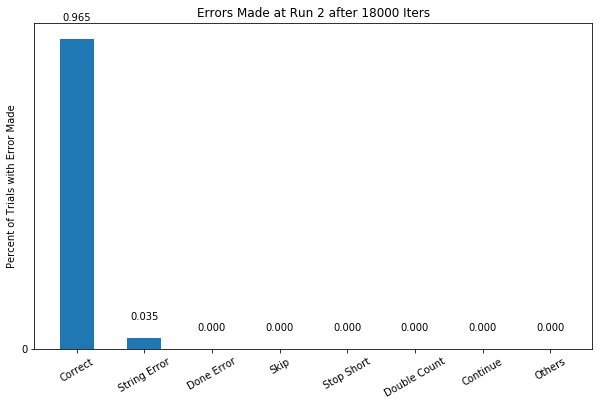

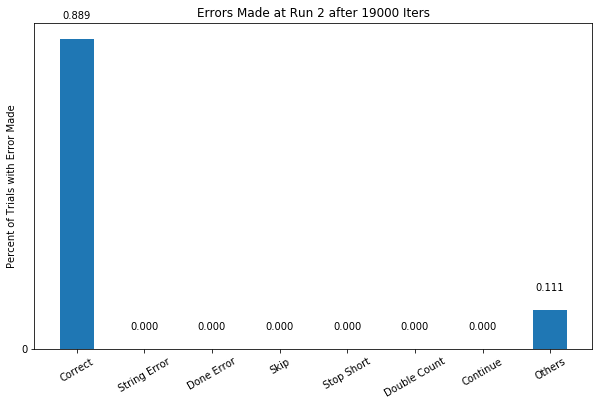

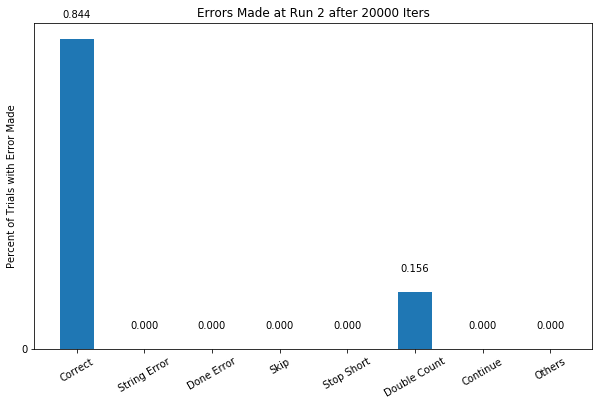

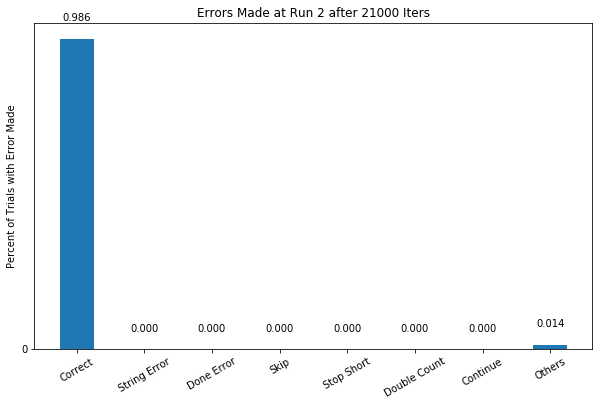

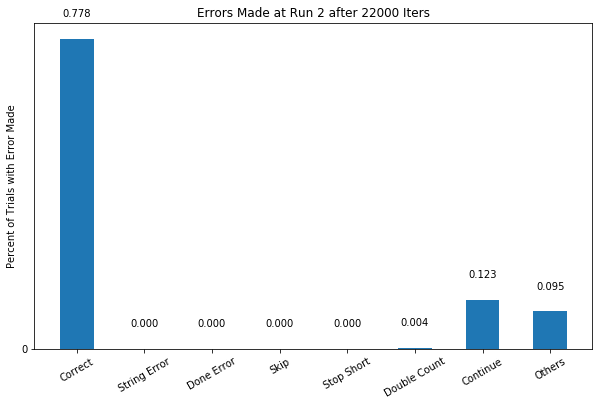

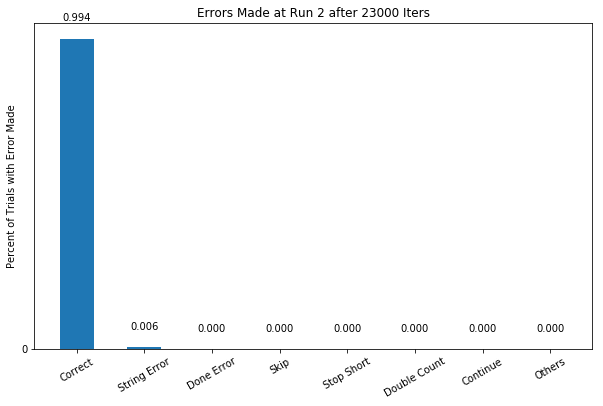

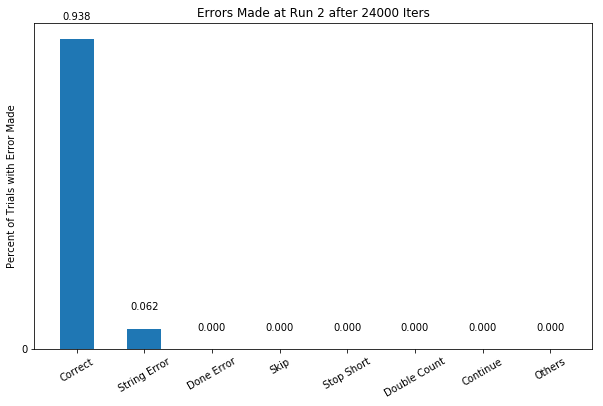

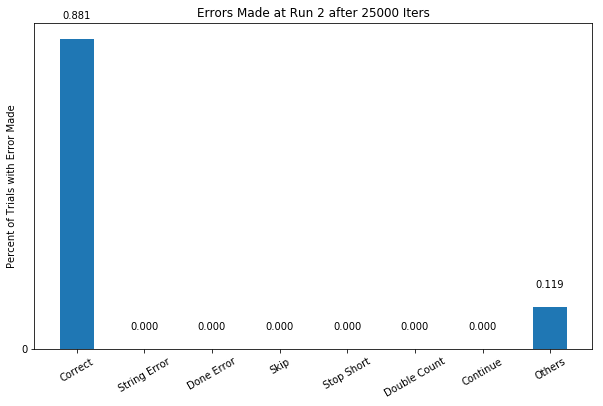

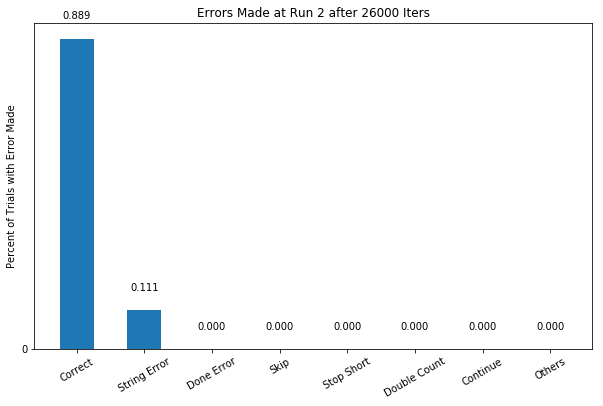

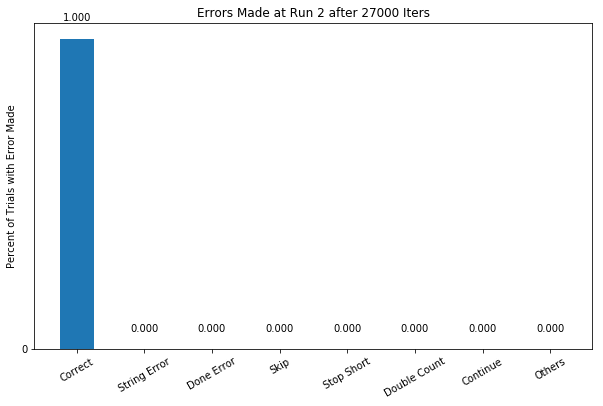

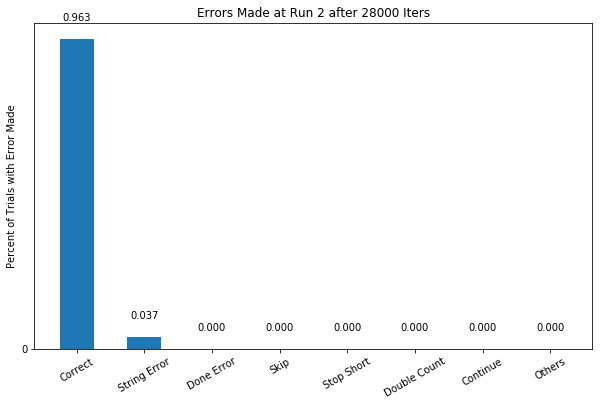

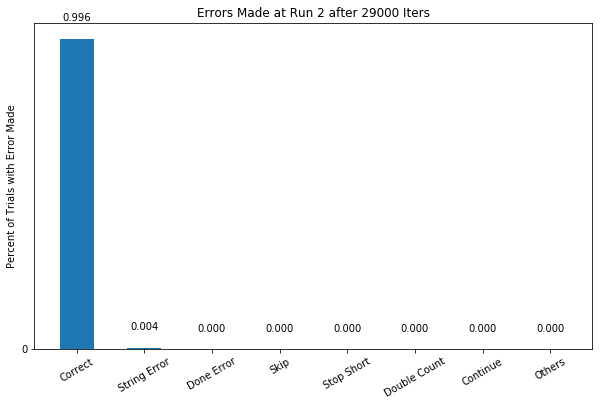

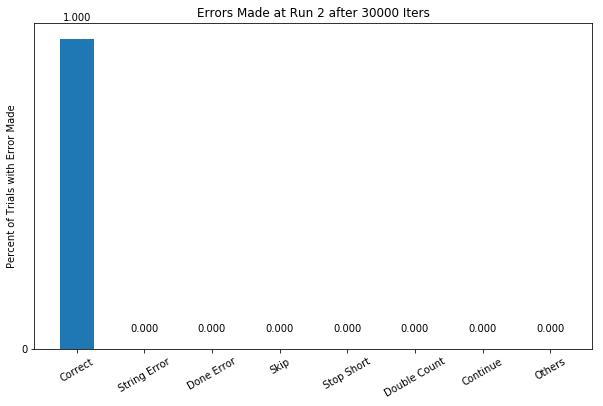

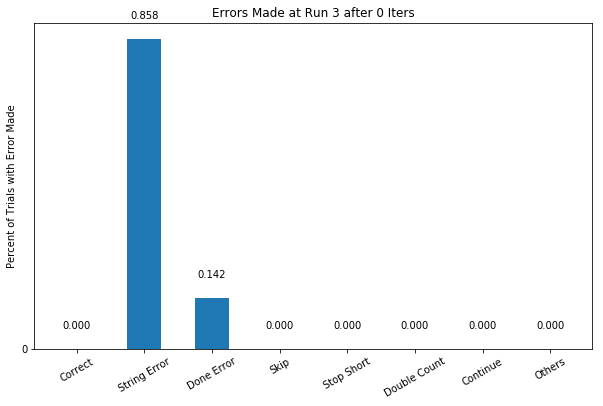

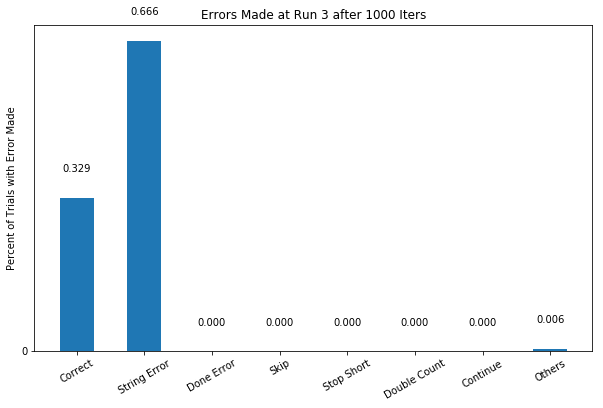

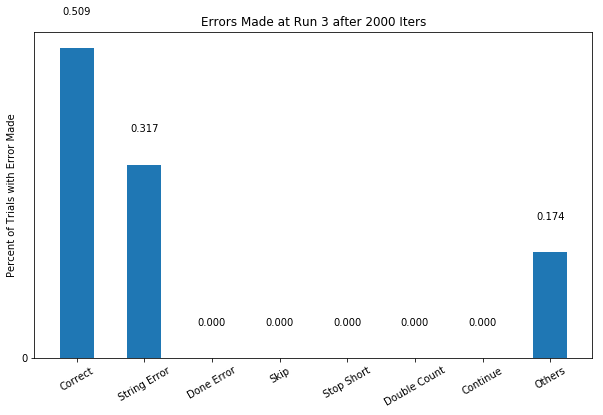

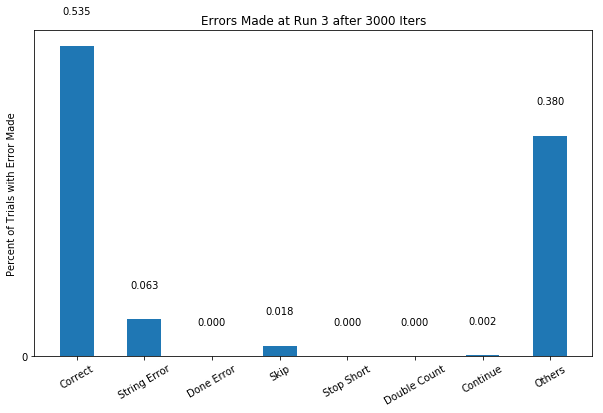

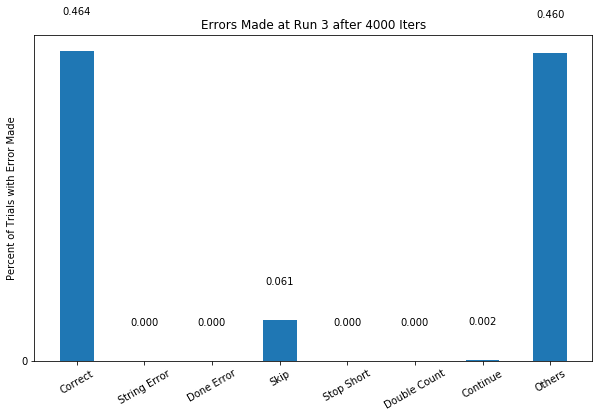

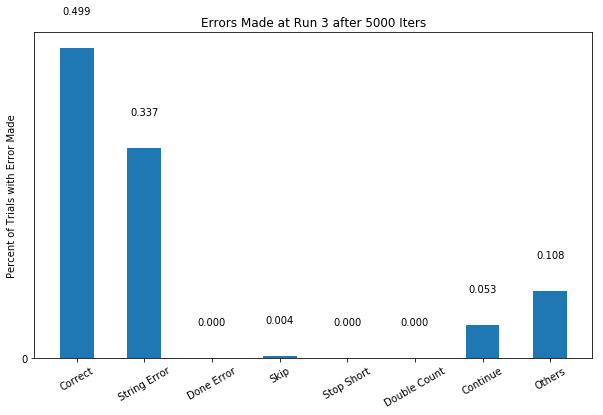

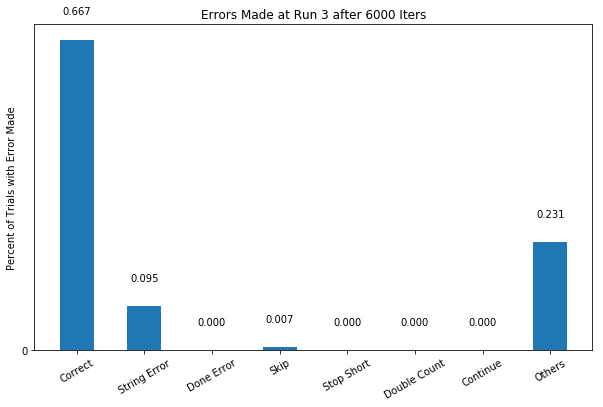

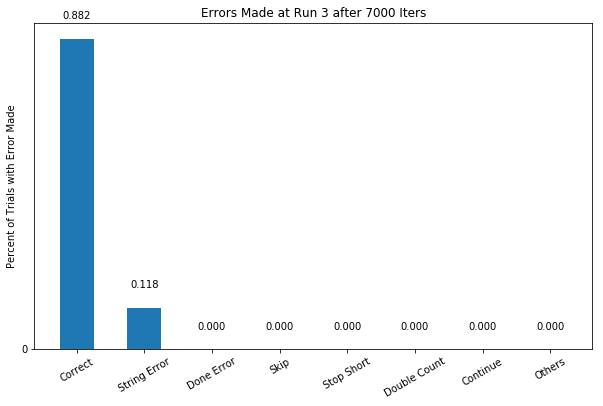

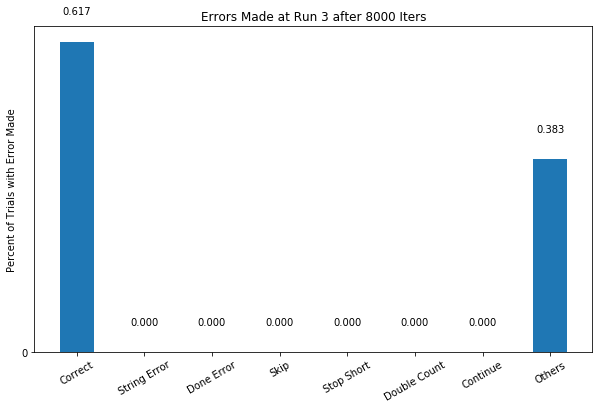

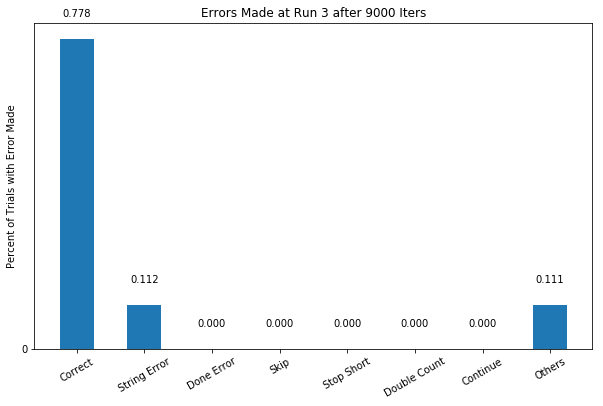

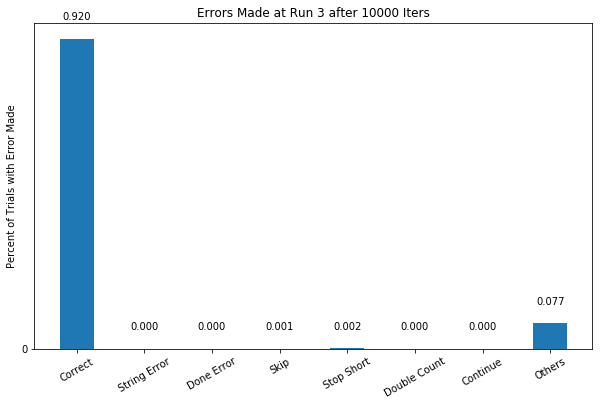

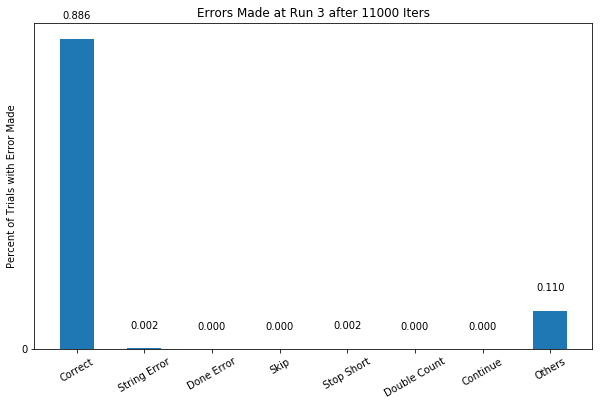

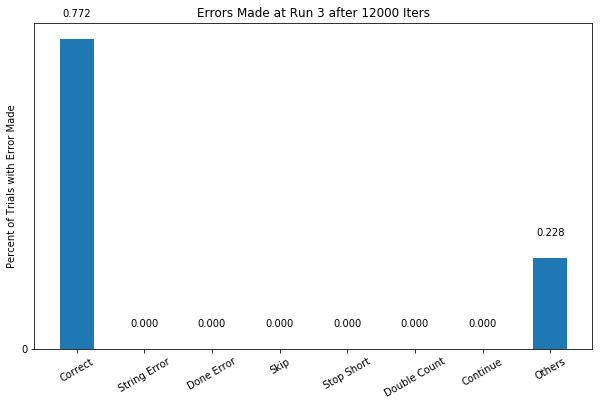

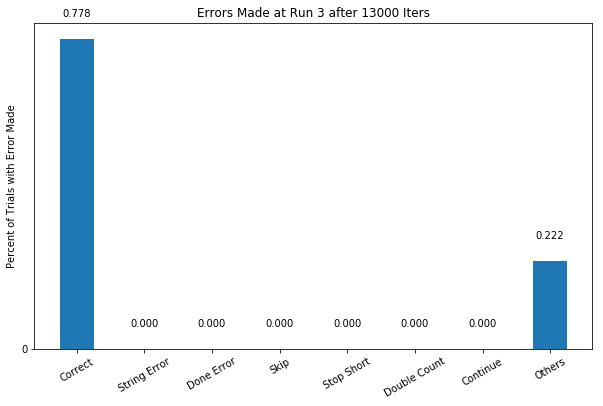

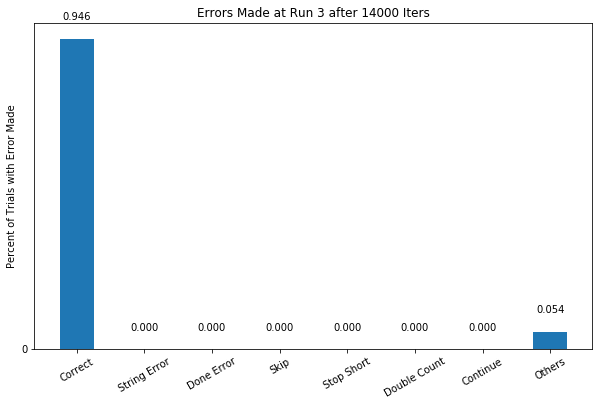

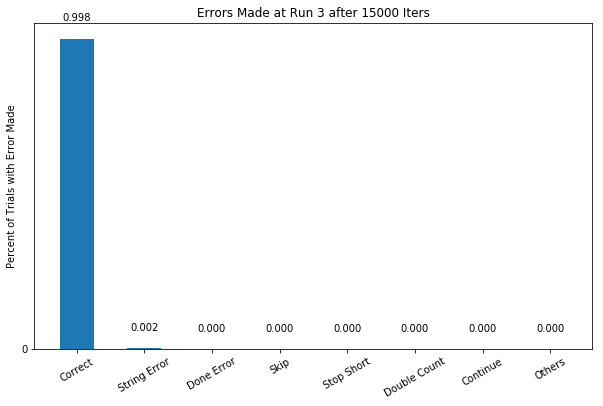

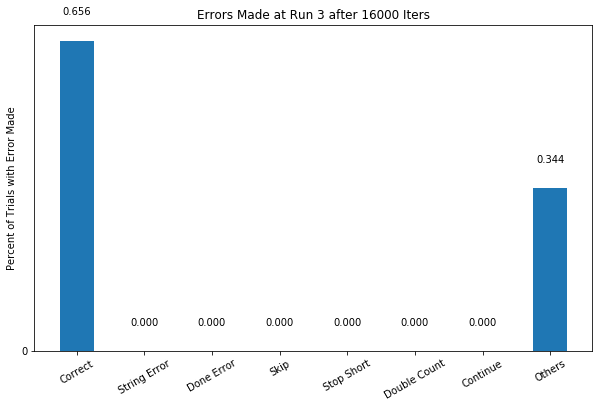

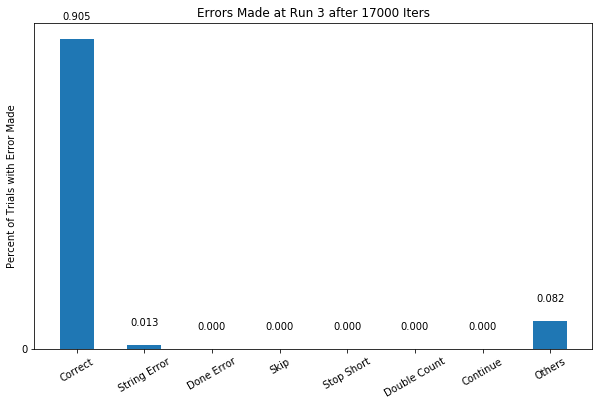

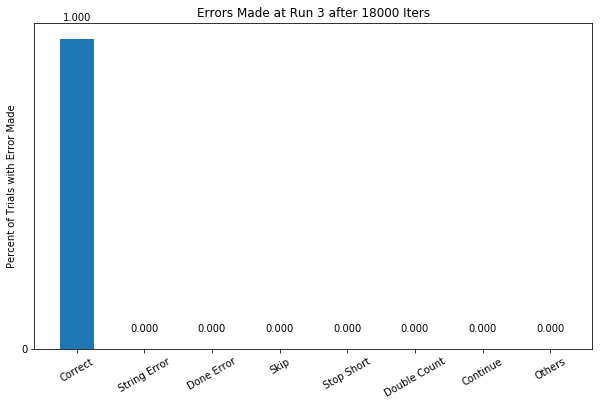

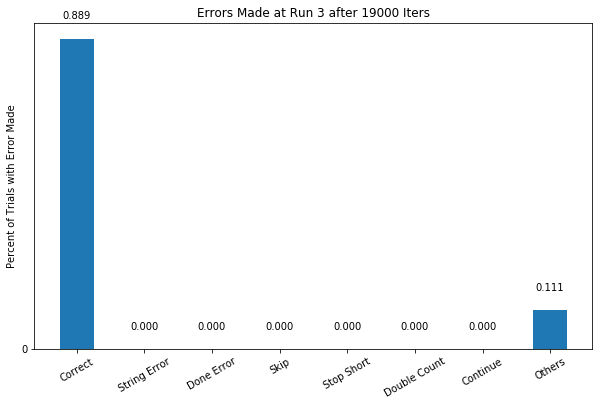

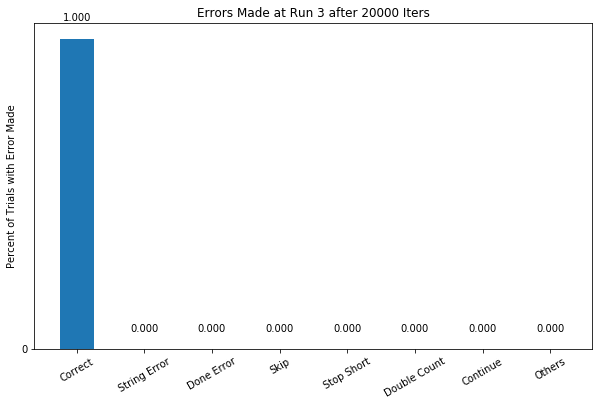

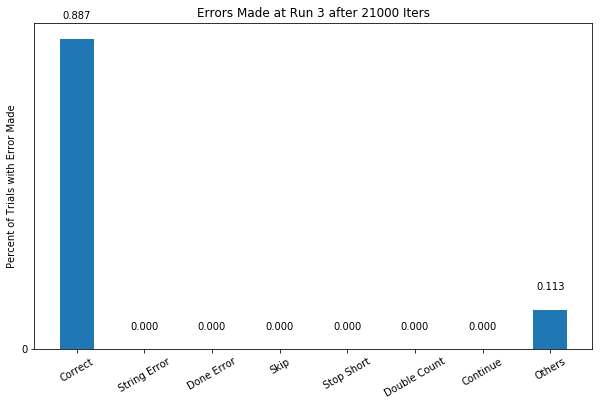

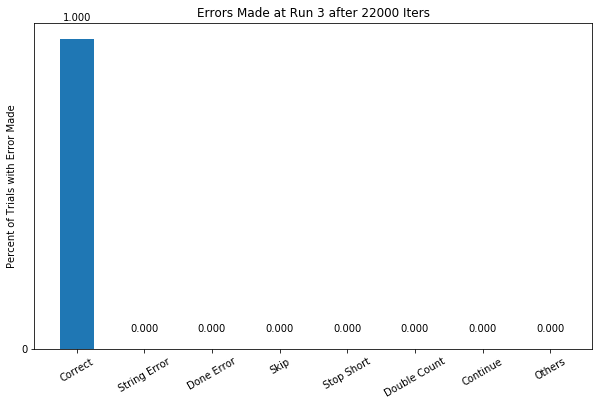

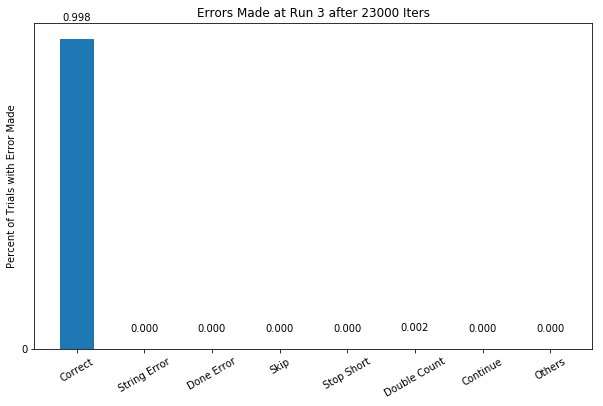

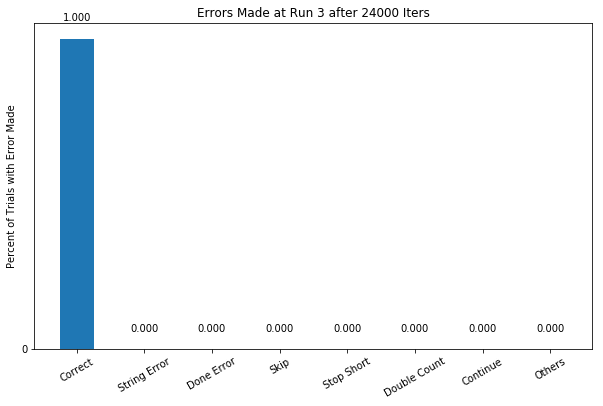

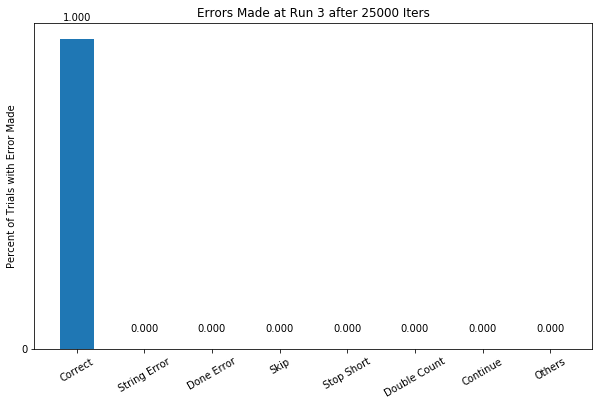

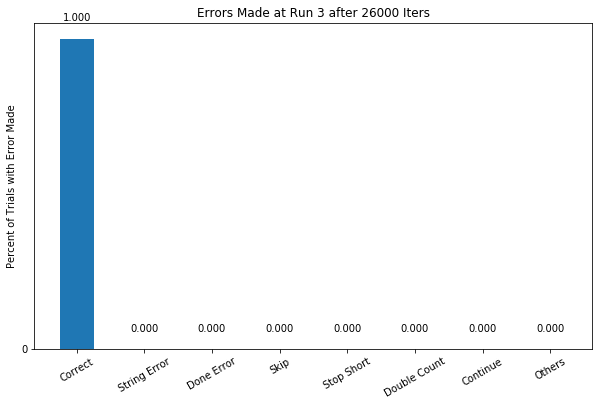

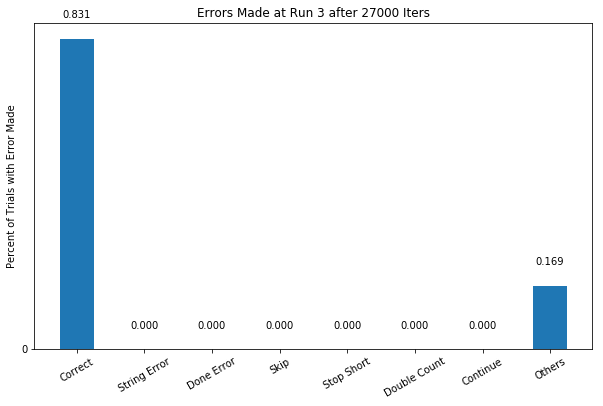

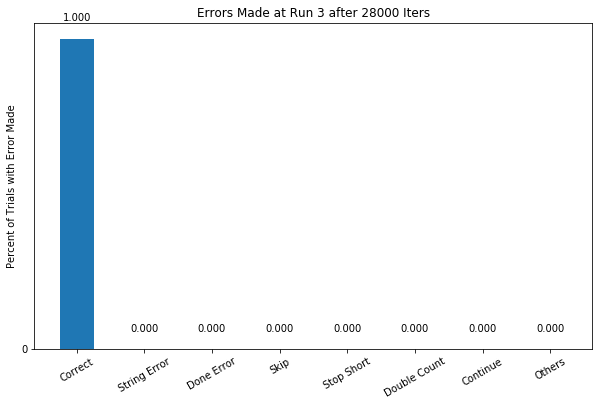

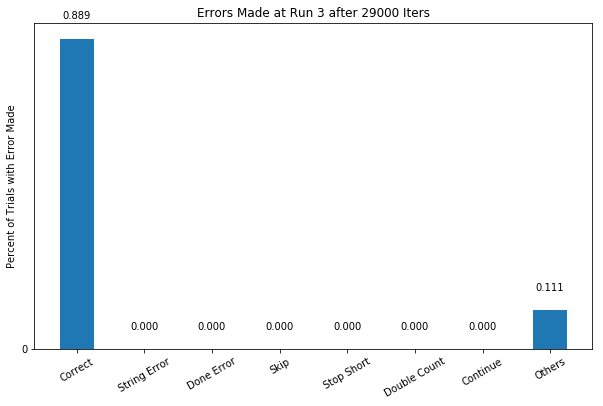

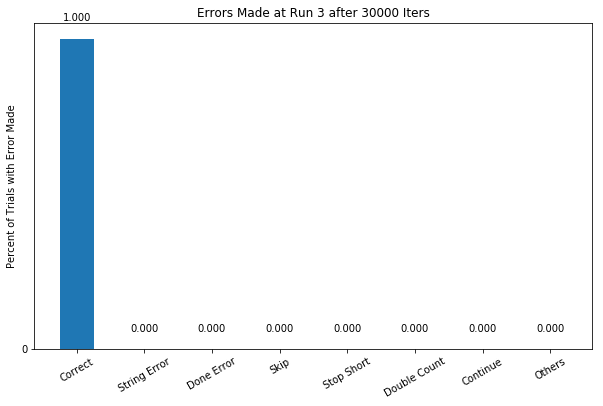

In [32]:
for run in range(num_runs):
    for it in range(num_iters):
        plot_error_percent(run,it)

In [33]:
# TASK 3: point performance
cot_accuracy = np.zeros([num_runs, num_iters])
cot_one =np.ones([num_runs, num_iters, num_imgs]) 

for i in range(num_runs):
    for j in range(num_iters):
        for k in range (num_imgs):
            for p in range (1, 10):
                if sort_cws[i][j][k][10]!=0:
                    cot_one[i][j][k]=0
                    break
                if p!=sort_cws[i][j][k][p]: 
                    cot_one[i][j][k]=0
            cot_accuracy[i][j]+=cot_one[i][j][k]
    
cot_accuracy/=9000

def plot_count_accuracy(run):
    """Plot the only count performance."""
    x = iter_list
    y = cot_accuracy[run]
    plot_title = "Performance of Count to 9 at Run %d" % (run + 1)
    plt.title(plot_title)
    plt.plot(x, y, '.-')
    plt.xlabel('Iteration')
    plt.ylabel('Average accuracy')

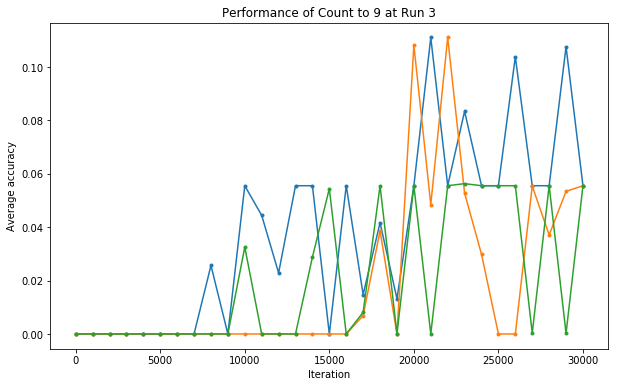

In [34]:
for run in range(num_runs):
    plot_count_accuracy(run)

In [35]:
def adj_all_runs(all_runs_matrix):
    """Adjust all the matrices so tick marks start with 1."""
    
    new_all_runs_matrix = np.zeros([num_runs, num_iters, output_size-1, num_glimpses+1, 1, output_size])
    for m, matrix in enumerate(all_runs_matrix):
        for i in range(num_iters):
            for g in range(num_glimpses):
                new_all_runs_matrix[m, i, g] = adj_matrix(matrix[i, g])
    return new_all_runs_matrix


def adj_matrix(matrix):
    """Adjust the matrix so tick marks start with 1."""
    
    a = np.zeros([1, output_size])
    temp = np.vstack((a, matrix))
    b = np.zeros([output_size + 1, 1])
    new_matrix = np.hstack((b, temp))
    return new_matrix


confidence_all_runs_adj = confidence_all_runs#adj_all_runs(confidence_all_runs)
choice_all_runs_adj = choice_all_runs#adj_all_runs(choice_all_runs)

In [36]:
confidence_avg = np.mean(confidence_all_runs_adj, axis=0)
choice_avg = np.mean(choice_all_runs_adj, axis=0)

In [37]:
def plot_confidence(iter_idx, it, num_blobs, run=None):
    """Plot the confidence heatmap."""
    
    if run is None:
        matrix = np.zeros([10,10])
        for g in range (10):
            matrix[:,g] = confidence_avg[iter_idx, num_blobs, g, 0]
        plot_title = "%d Blobs:Confidence after %d Iters" % (num_blobs+1, it)

    else:
        matrix = np.zeros([10,10])
        for g in range (10):
            matrix = confidence_all_runs_adj[run, iter_idx, num_blobs, g, 0]
        plot_title = "%d Blobs:Confidence at Run %d after %d Iters" % (num_blobs+1, run + 1, it)
    plot_heatmap(matrix, num_blobs, plot_title)


def plot_choice(iter_idx, it, num_blobs, run=None):
    """Plot the choice heatmap."""
    
    if run is None:
        matrix = np.zeros([10,10])
        for g in range (10):
            matrix[:,g] = choice_avg[iter_idx, num_blobs, g, 0]
        plot_title = "%d Blobs:Choice after %d Iterations" % (num_blobs+1, it)
    else:
        matrix = np.zeros([10,10])
        for g in range (10):
            matrix = choice_all_runs_adj[run, iter_idx, num_blobs, g, 0]
        plot_title = "%d Blobs:Choice at Run %d after %d Iterations" % (num_blobs+1, run + 1, it)
    plot_heatmap(matrix, num_blobs, plot_title)
    
    
def plot_heatmap(matrix, num_blobs, plot_title):
    """Plot heatmap."""
    
    data = [go.Heatmap(
        z=matrix,
        colorscale="Jet"
    )]

    layout = go.Layout(
        title=plot_title,
        yaxis=dict(
#             range=[max_blobs + m, min_blobs - m],
            range=[0 - m, 9 + m],
            title="Count Word",
            dtick=1,
            tickcolor='#FFF'
        ),
        xaxis=dict(
            range=[0 - m, 9 + m],
            title="Glimpses",
            dtick=1,
            tickcolor='#FFF'
        ),
        width=400,
        height=400,
        plot_bgcolor="#000",
        paper_bgcolor="#000",
        font=dict(
            color="#FFF"
        ),
        titlefont=dict(
            color="#FFF"
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [38]:
#for n, num in enumerate(blob_list):
    #for i, it in enumerate(iter_list):
        #plot_confidence(i, it, num)
        #plot_choice(i, it, num)

In [39]:
for n, num in enumerate(blob_list): 
    #for i, it in enumerate(iter_list):
    plot_confidence(19, 4000000, num)
    #plot_choice(18, 3000000, num)

IndexError: index 9 is out of bounds for axis 1 with size 9

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

# Confidence
F = plt.figure(1, (50,50))
F.clf()

ZS = np.zeros([num_iters*(output_size-1),10,10])
extent = (0, 10, 0, 10) 
    
matrix = np.zeros([10, 10])
for num_blobs in range (output_size-1):
    for iter_idx in range (num_iters):
        for g in range (10):
            matrix[:,g] = confidence_avg[iter_idx, num_blobs, g, 0]
            ZS[iter_idx+num_iters*num_blobs] = matrix

extent = extent[0], extent[1], extent[2], extent[3] 

grid = ImageGrid(F, 212,
                 nrows_ncols=(output_size-1, num_iters),
                 direction="row",
                 axes_pad=0.05,
                 add_all=True,
                 label_mode="1",
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.05,
                 )

grid[0].set_xlabel("Glimpse")
grid[0].set_ylabel("Count Word")

vmax, vmin = np.max(ZS), np.min(ZS)
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

for ax, im_title in zip(grid, ["iter=0", "400", "800", "1600", "3200", "6400", "12800", "25600", "51200", "102400", "153600", "204800", "307200", "409600", "614400", "819200", "1000000", "2000000", "3000000", "4000000"]):
    ax.set_title(im_title)
    ax.patch.set_alpha(0.5)
        
for ax, z in zip(grid, ZS):
    im = ax.imshow(z, norm=norm,
                   origin="lower", extent=extent,
                   interpolation="nearest")

# With cbar_mode="single", cax attribute of all axes are identical.
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

grid[0].set_xticks([1,2,3,4,5,6,7,8,9,10])
grid[0].set_yticks([0,1,2,3,4,5,6,7,8,9])

plt.draw()
plt.show()

In [ ]:
# Choice
F = plt.figure(1, (50,50))
F.clf()

ZS = np.zeros([num_iters*(output_size-1),10,10])
extent = (0, 10, 0, 10) 
    
matrix = np.zeros([10, 10])
for num_blobs in range (output_size-1):
    for iter_idx in range (num_iters):
        for g in range (10):
            matrix[:,g] = choice_avg[iter_idx, num_blobs, g, 0]
            ZS[iter_idx+num_iters*num_blobs] = matrix

extent = extent[0], extent[1], extent[2], extent[3] 

grid = ImageGrid(F, 212,
                 nrows_ncols=(output_size-1, num_iters),
                 direction="row",
                 axes_pad=0.05,
                 add_all=True,
                 label_mode="1",
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.05,
                 )

grid[0].set_xlabel("Glimpse")
grid[0].set_ylabel("Count Word")

vmax, vmin = np.max(ZS), np.min(ZS)
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

for ax, im_title in zip(grid, ["iter=0", "400", "800", "1600", "3200", "6400", "12800", "25600", "51200", "102400", "153600", "204800", "307200", "409600", "614400", "819200", "1000000", "2000000", "3000000", "4000000"]):
    ax.set_title(im_title)
    ax.patch.set_alpha(0.5)
        
for ax, z in zip(grid, ZS):
    im = ax.imshow(z, norm=norm,
                   origin="lower", extent=extent,
                   interpolation="nearest")

# With cbar_mode="single", cax attribute of all axes are identical.
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

grid[0].set_xticks([1,2,3,4,5,6,7,8,9,10])
grid[0].set_yticks([0,1,2,3,4,5,6,7,8,9])

plt.draw()
plt.show()

##### 